In [1]:
%load_ext autoreload
%autoreload 2

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt
import time
import napari

In [2]:
os.chdir('/home/ali/packages/s2p-lbm/')

from suite3d.job import Job
from suite3d import lbmio, utils, ui
from suite3d import tiff_utils as tfu
from suite3d import file_utils as flu

In [3]:
subjects_dir =   '/mnt/zortex-subjects/'
expt_info = { 
    'subject':         'SS003',
    'date' :          '2024-08-06',
    'expnum' :         list(n.arange(1,20)),}

tifs, si_params, exp_str = flu.find_exp(subjects_dir, **expt_info, verbose=False)

job_params = {    
    # number of channels recorded in the tiff file, typically 30
    'n_ch_tif' : 26,
    # number of planes in the deeper cavity, typically 15
    'cavity_size' : 13,
    # convert from the Scanimage channel ordering to deep-to-shallow ordering
    # in our case, ScanImage channel numbers are in temporal order. 
    'planes' : n.array([ 0,  2,  4,  6,  8, 10, 12, 14,
                        16, 18, 20, 22, 24, 1,  3, 5,  7,9,11, 13, 15,17,19,21]),
    # number of files to use for the initial pass
    'n_init_files' :   4,
    
    # number of pixels to fuse between the ROI strips
    # the auto-detection doesn't always work well, recommend 
    # manually tuning it to reduce the stitching artifacts
    'fuse_shift_override' : 6,
    
    # will try to automatically estimate crosstalk using 
    # the shallowest crosstalk_n_planes planes. if you want to override,
    # set override_crosstalk = float between 0 and 1
    'subtract_crosstalk' : True,
    
    # volume rate in acquisition
    'fs' : flu.get_si_params(tifs[0])['vol_rate'],
    
    # 3D GPU registration - fast! 
    # for now, 3D + GPU are well-tested, other options might have minor bugs
    # if you run into them, let us know! we'll fix them
    '3d_reg' : False,
    'gpu_reg' : True,
}

In [4]:

job_params['fs'] = si_params['vol_rate']

savedir = os.path.join('/mnt/md0/runs', expt_info['subject'], expt_info['date'])
os.makedirs(savedir, exist_ok=True)

In [5]:
# Create the job
job = Job('/mnt/md0/runs',exp_str, tifs = tifs,
          params=job_params, create=False, overwrite=True, verbosity = 3)

   Found and loaded params from /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19/params.npy


In [22]:
# optional parameters for initialization
# load 1 file to initialize, and select 200 frames randomly to do initalization on
job.params['n_init_files'] = 1
job.params['init_n_frames'] = None
job.params['init_file_sample_method'] = 'even'
job.params['voxel_size_um'] = (20, 3.0, 3.0)

   Saved a copy of params at /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19/summary
   Updated main params file
Launching initial pass
Saving summary to /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19/summary/summary.npy
   Loading init tifs with 26 channels
      Loading /mnt/zortex-subjects/SS003/2024-08-06/9/2024-08-06_9_SS003_2P_00001_00019.tif
            Loaded mov and masks to GPU for rigid reg in 0.78 sec
            Allocating memory for shifted movie
            GPU RAM: 2 blocks allocated, 3.81 / 6.05 GB used
            Registering plane 0
            Shifting plane 0
            Registering plane 1
            Shifting plane 1
            Registering plane 2
            Shifting plane 2
            Registering plane 3
            Shifting plane 3
            Registering plane 4
            Shifting plane 4
            Registering plane 5
            Shifting plane 5
            Registering plane 6
     

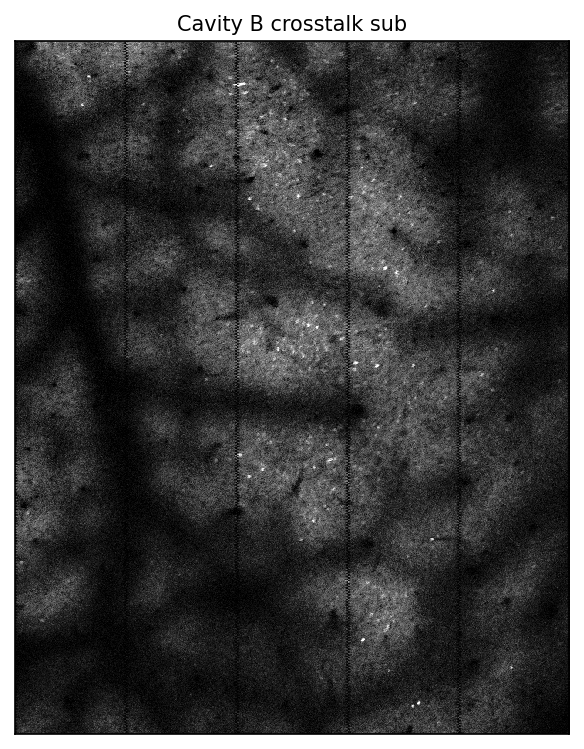

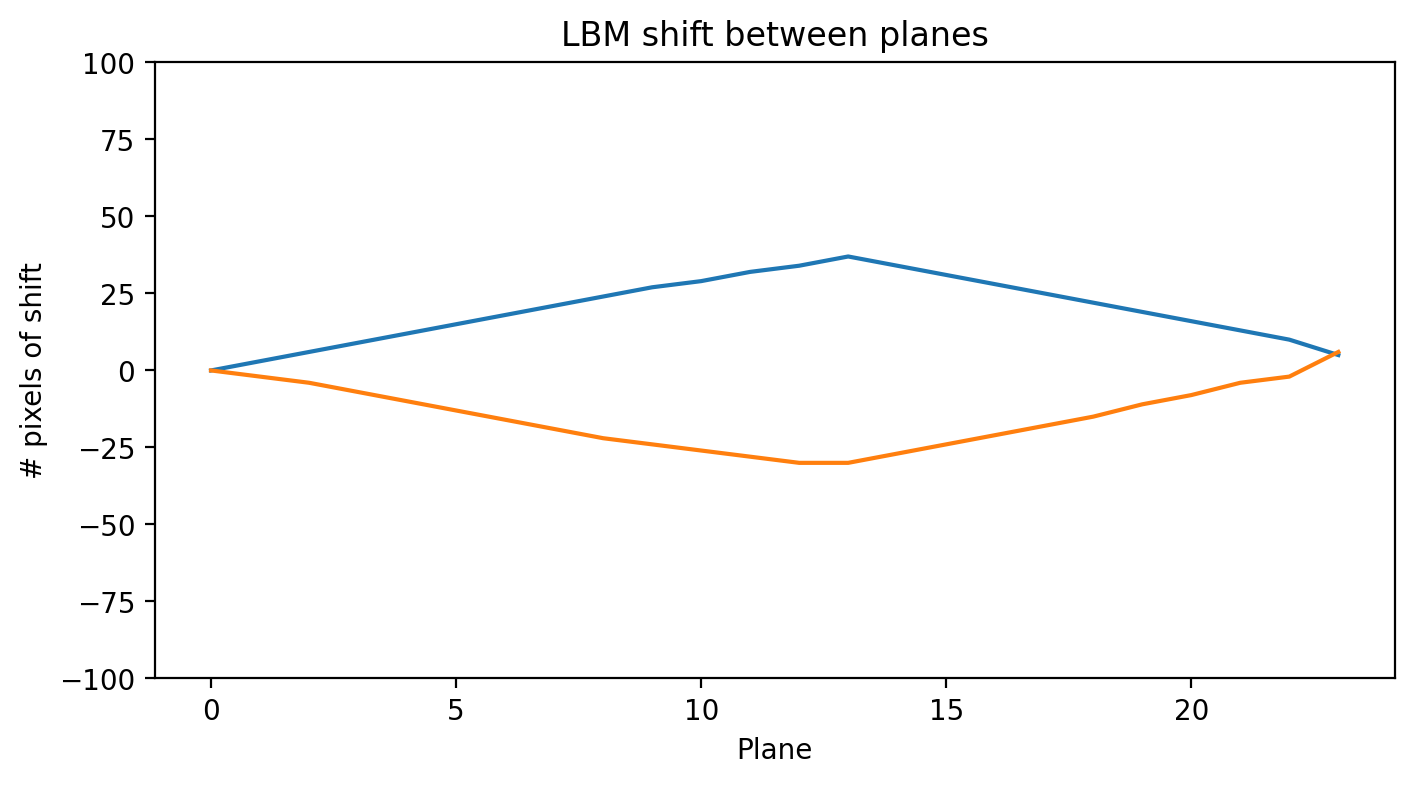

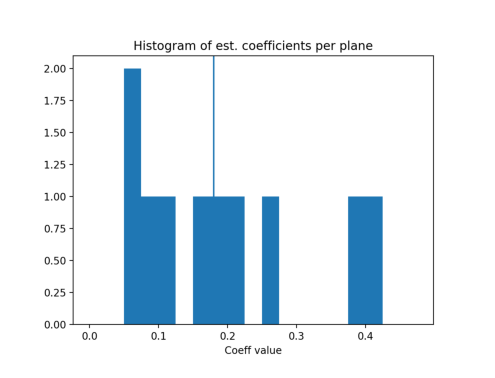

In [31]:
%%time
summary = job.run_init_pass()

In [32]:
summary = job.load_summary()

In [33]:
img = summary['ref_img_3d']

(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f861384b3d0>)

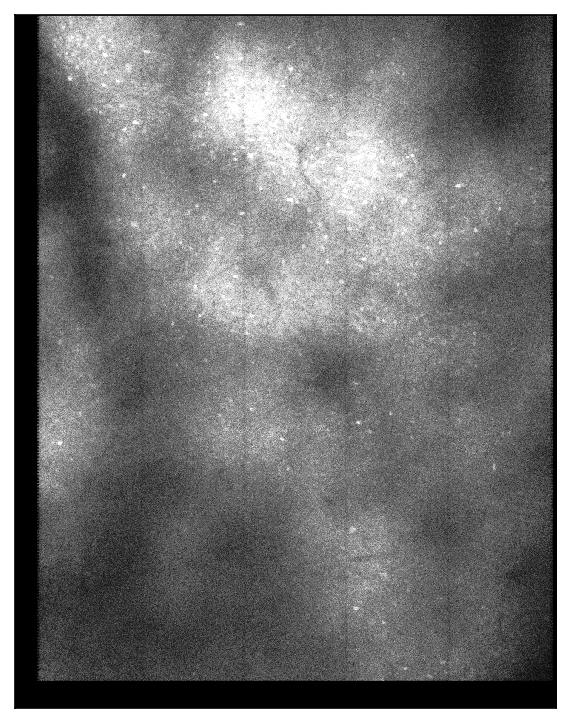

In [34]:
tfu.show_tif(img[0])

In [35]:
# split the large tiffs into files of size 100 after registration
job.params['split_tif_size'] = 100

In [37]:
%%time
job.register(tifs=job.tifs)

      Found dir /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19/registered_fused_data
      Updating self.dirs tag registered_fused_data
   Saved a copy of params at /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19/registered_fused_data
   Updated main params file
   Starting registration: 3D: False, GPU: True
   Overriding fuse shift value to 6
Will analyze 507 tifs in 507 batches
   Enforcing positivity
   Launching IO thread
         Memory at batch 0.  Total Used: 048.706 GB, Virtual Available: 462.317 GB, Virtual Used: 040.879 GB, Swap Used: 007.827 GB
Loading Batch 0 of 506
      Loading /mnt/zortex-subjects/SS003/2024-08-06/1/2024-08-06_1_SS003_2P_00001_00001.tif
    Loaded file into shared memory in 52.02 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.86 sec
    Total time: 55.88 sec
   Loaded 1 files, total 2.90 GB
   Batch 0 IO thread joined
         Memory after IO thread joinTotal Used: 051.680 GB, Virtual Available: 459.344 GB, Virtual Used: 043.851 GB, Swap Used: 007.829 GB
         Memory after movie copied from threadTotal Used: 054.573 GB, Virtual Available: 456.452 GB, Virtual Used: 046.744 GB, Swap Used: 007.829 GB
         Memory after thread memory clearedTotal Used: 051.676 GB, Virtual Available: 459.349 GB, Virtual Used: 043.847 GB, Swap Used: 007.829 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 051.675 GB, Virtual Available: 459.349 GB, Virtual Used: 043.846 GB, Swap Used: 007.829 GB
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/SS003/2024-08-06/1/2024-08-06_1_SS003_2P_00001_00002.tif
         Registered batch in 0.04 sec
         Shifted batch in 0.15 sec
 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.40 sec
    Total time: 39.57 sec
   Loaded 1 files, total 2.90 GB
   Batch 1 IO thread joined
         Memory after IO thread joinTotal Used: 064.827 GB, Virtual Available: 446.198 GB, Virtual Used: 056.998 GB, Swap Used: 007.830 GB
         Memory after movie copied from threadTotal Used: 064.811 GB, Virtual Available: 446.215 GB, Virtual Used: 056.981 GB, Swap Used: 007.830 GB
         Memory after thread memory clearedTotal Used: 061.914 GB, Virtual Available: 449.111 GB, Virtual Used: 054.084 GB, Swap Used: 007.830 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 061.914 GB, Virtual Available: 449.111 GB, Virtual Used: 054.084 GB, Swap Used: 007.830 GB
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/SS003/2024-08-06/1/2024-08-06_1_SS003_2P_00001_00003.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.40 sec
    Total time: 47.65 sec
   Loaded 1 files, total 2.90 GB
   Batch 2 IO thread joined
         Memory after IO thread joinTotal Used: 064.701 GB, Virtual Available: 446.324 GB, Virtual Used: 056.872 GB, Swap Used: 007.830 GB
         Memory after movie copied from threadTotal Used: 064.720 GB, Virtual Available: 446.305 GB, Virtual Used: 056.890 GB, Swap Used: 007.830 GB
         Memory after thread memory clearedTotal Used: 061.805 GB, Virtual Available: 449.220 GB, Virtual Used: 053.976 GB, Swap Used: 007.830 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 061.805 GB, Virtual Available: 449.220 GB, Virtual Used: 053.976 GB, Swap Used: 007.830 GB
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/SS003/2024-08-06/1/2024-08-06_1_SS003_2P_00001_00004.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.61 sec
    Total time: 55.23 sec
   Loaded 1 files, total 2.90 GB
   Batch 3 IO thread joined
         Memory after IO thread joinTotal Used: 064.750 GB, Virtual Available: 446.276 GB, Virtual Used: 056.920 GB, Swap Used: 007.830 GB
         Memory after movie copied from threadTotal Used: 064.742 GB, Virtual Available: 446.284 GB, Virtual Used: 056.912 GB, Swap Used: 007.830 GB
         Memory after thread memory clearedTotal Used: 061.845 GB, Virtual Available: 449.180 GB, Virtual Used: 054.015 GB, Swap Used: 007.830 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 061.847 GB, Virtual Available: 449.178 GB, Virtual Used: 054.017 GB, Swap Used: 007.830 GB
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/SS003/2024-08-06/1/2024-08-06_1_SS003_2P_00001_00005.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 sec
 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.70 sec
    Total time: 40.40 sec
   Loaded 1 files, total 2.90 GB
   Batch 4 IO thread joined
         Memory after IO thread joinTotal Used: 065.016 GB, Virtual Available: 446.020 GB, Virtual Used: 057.176 GB, Swap Used: 007.840 GB
         Memory after movie copied from threadTotal Used: 065.021 GB, Virtual Available: 446.014 GB, Virtual Used: 057.181 GB, Swap Used: 007.840 GB
         Memory after thread memory clearedTotal Used: 062.113 GB, Virtual Available: 448.923 GB, Virtual Used: 054.272 GB, Swap Used: 007.840 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 062.114 GB, Virtual Available: 448.922 GB, Virtual Used: 054.274 GB, Swap Used: 007.840 GB
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/SS003/2024-08-06/1/2024-08-06_1_SS003_2P_00001_00006.tif
         Registered batch in 0.03 sec
         Shifted batch in 0.19 sec
 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.55 sec
    Total time: 75.78 sec
   Loaded 1 files, total 2.90 GB
   Batch 5 IO thread joined
         Memory after IO thread joinTotal Used: 064.705 GB, Virtual Available: 446.334 GB, Virtual Used: 056.862 GB, Swap Used: 007.843 GB
         Memory after movie copied from threadTotal Used: 064.705 GB, Virtual Available: 446.334 GB, Virtual Used: 056.861 GB, Swap Used: 007.843 GB
         Memory after thread memory clearedTotal Used: 061.810 GB, Virtual Available: 449.229 GB, Virtual Used: 053.967 GB, Swap Used: 007.843 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/SS003/2024-08-06/1/2024-08-06_1_SS003_2P_00001_00007.tif
         After IO thread launch:Total Used: 061.813 GB, Virtual Available: 449.226 GB, Virtual Used: 053.969 GB, Swap Used: 007.843 GB
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 sec
 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.49 sec
    Total time: 40.76 sec
   Loaded 1 files, total 2.90 GB
   Batch 6 IO thread joined
         Memory after IO thread joinTotal Used: 064.698 GB, Virtual Available: 446.346 GB, Virtual Used: 056.849 GB, Swap Used: 007.849 GB
         Memory after movie copied from threadTotal Used: 064.705 GB, Virtual Available: 446.340 GB, Virtual Used: 056.856 GB, Swap Used: 007.849 GB
         Memory after thread memory clearedTotal Used: 061.792 GB, Virtual Available: 449.253 GB, Virtual Used: 053.942 GB, Swap Used: 007.849 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 061.791 GB, Virtual Available: 449.254 GB, Virtual Used: 053.942 GB, Swap Used: 007.849 GB
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/SS003/2024-08-06/1/2024-08-06_1_SS003_2P_00001_00008.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.68 sec
    Total time: 72.25 sec
   Loaded 1 files, total 2.90 GB
   Batch 7 IO thread joined
         Memory after IO thread joinTotal Used: 064.692 GB, Virtual Available: 446.353 GB, Virtual Used: 056.843 GB, Swap Used: 007.849 GB
         Memory after movie copied from threadTotal Used: 064.697 GB, Virtual Available: 446.348 GB, Virtual Used: 056.847 GB, Swap Used: 007.849 GB
         Memory after thread memory clearedTotal Used: 061.788 GB, Virtual Available: 449.256 GB, Virtual Used: 053.939 GB, Swap Used: 007.849 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 061.788 GB, Virtual Available: 449.256 GB, Virtual Used: 053.939 GB, Swap Used: 007.849 GB
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/SS003/2024-08-06/1/2024-08-06_1_SS003_2P_00001_00009.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 sec
 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.93 sec
    Total time: 67.74 sec
   Loaded 1 files, total 2.90 GB
   Batch 8 IO thread joined
         Memory after IO thread joinTotal Used: 064.699 GB, Virtual Available: 446.346 GB, Virtual Used: 056.849 GB, Swap Used: 007.849 GB
         Memory after movie copied from threadTotal Used: 064.697 GB, Virtual Available: 446.347 GB, Virtual Used: 056.848 GB, Swap Used: 007.849 GB
         Memory after thread memory clearedTotal Used: 061.799 GB, Virtual Available: 449.246 GB, Virtual Used: 053.949 GB, Swap Used: 007.849 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 061.799 GB, Virtual Available: 449.246 GB, Virtual Used: 053.949 GB, Swap Used: 007.849 GB
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/SS003/2024-08-06/1/2024-08-06_1_SS003_2P_00001_00010.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 sec
 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.54 sec
    Total time: 71.29 sec
   Loaded 1 files, total 2.90 GB
   Batch 9 IO thread joined
         Memory after IO thread joinTotal Used: 064.694 GB, Virtual Available: 446.357 GB, Virtual Used: 056.838 GB, Swap Used: 007.855 GB
         Memory after movie copied from threadTotal Used: 064.698 GB, Virtual Available: 446.353 GB, Virtual Used: 056.843 GB, Swap Used: 007.855 GB
         Memory after thread memory clearedTotal Used: 061.799 GB, Virtual Available: 449.252 GB, Virtual Used: 053.944 GB, Swap Used: 007.855 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 061.799 GB, Virtual Available: 449.252 GB, Virtual Used: 053.943 GB, Swap Used: 007.855 GB
      Loaded batch of size (24, 100, 900, 720)
      Loading /mnt/zortex-subjects/SS003/2024-08-06/1/2024-08-06_1_SS003_2P_00001_00011.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.70 sec
    Total time: 70.16 sec
   Loaded 1 files, total 2.90 GB
   Batch 10 IO thread joined
         Memory after IO thread joinTotal Used: 064.709 GB, Virtual Available: 446.342 GB, Virtual Used: 056.853 GB, Swap Used: 007.855 GB
         Memory after movie copied from threadTotal Used: 064.702 GB, Virtual Available: 446.349 GB, Virtual Used: 056.847 GB, Swap Used: 007.855 GB
         Memory after thread memory clearedTotal Used: 061.793 GB, Virtual Available: 449.258 GB, Virtual Used: 053.938 GB, Swap Used: 007.855 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 061.793 GB, Virtual Available: 449.258 GB, Virtual Used: 053.938 GB, Swap Used: 007.855 GB
      Loading /mnt/zortex-subjects/SS003/2024-08-06/1/2024-08-06_1_SS003_2P_00001_00012.tif
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.21 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 7.04 sec
    Total time: 71.06 sec
   Loaded 1 files, total 2.90 GB
   Batch 11 IO thread joined
         Memory after IO thread joinTotal Used: 064.688 GB, Virtual Available: 446.364 GB, Virtual Used: 056.831 GB, Swap Used: 007.857 GB
         Memory after movie copied from threadTotal Used: 064.686 GB, Virtual Available: 446.367 GB, Virtual Used: 056.829 GB, Swap Used: 007.857 GB
         Memory after thread memory clearedTotal Used: 061.792 GB, Virtual Available: 449.261 GB, Virtual Used: 053.935 GB, Swap Used: 007.857 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 061.792 GB, Virtual Available: 449.260 GB, Virtual Used: 053.935 GB, Swap Used: 007.857 GB
      Loaded batch of size (24, 100, 900, 720)
      Loading /mnt/zortex-subjects/SS003/2024-08-06/1/2024-08-06_1_SS003_2P_00001_00013.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.04 sec
         Shifted batch in 0.18 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.98 sec
    Total time: 74.78 sec
   Loaded 1 files, total 2.90 GB
   Batch 12 IO thread joined
         Memory after IO thread joinTotal Used: 064.696 GB, Virtual Available: 446.357 GB, Virtual Used: 056.839 GB, Swap Used: 007.857 GB
         Memory after movie copied from threadTotal Used: 064.715 GB, Virtual Available: 446.338 GB, Virtual Used: 056.858 GB, Swap Used: 007.857 GB
         Memory after thread memory clearedTotal Used: 061.806 GB, Virtual Available: 449.246 GB, Virtual Used: 053.949 GB, Swap Used: 007.857 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 061.806 GB, Virtual Available: 449.246 GB, Virtual Used: 053.949 GB, Swap Used: 007.857 GB
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/SS003/2024-08-06/1/2024-08-06_1_SS003_2P_00001_00014.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.45 sec
    Total time: 73.57 sec
   Loaded 1 files, total 2.90 GB
   Batch 13 IO thread joined
         Memory after IO thread joinTotal Used: 064.699 GB, Virtual Available: 446.353 GB, Virtual Used: 056.843 GB, Swap Used: 007.857 GB
         Memory after movie copied from threadTotal Used: 064.702 GB, Virtual Available: 446.351 GB, Virtual Used: 056.845 GB, Swap Used: 007.857 GB
         Memory after thread memory clearedTotal Used: 061.794 GB, Virtual Available: 449.259 GB, Virtual Used: 053.937 GB, Swap Used: 007.857 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 061.794 GB, Virtual Available: 449.258 GB, Virtual Used: 053.938 GB, Swap Used: 007.857 GB
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/SS003/2024-08-06/1/2024-08-06_1_SS003_2P_00001_00015.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.91 sec
    Total time: 59.13 sec
   Loaded 1 files, total 2.90 GB
   Batch 14 IO thread joined
         Memory after IO thread joinTotal Used: 064.692 GB, Virtual Available: 446.360 GB, Virtual Used: 056.836 GB, Swap Used: 007.857 GB
         Memory after movie copied from threadTotal Used: 064.695 GB, Virtual Available: 446.357 GB, Virtual Used: 056.838 GB, Swap Used: 007.857 GB
         Memory after thread memory clearedTotal Used: 061.790 GB, Virtual Available: 449.262 GB, Virtual Used: 053.934 GB, Swap Used: 007.857 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 061.791 GB, Virtual Available: 449.262 GB, Virtual Used: 053.934 GB, Swap Used: 007.857 GB
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/SS003/2024-08-06/1/2024-08-06_1_SS003_2P_00001_00016.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 7.00 sec
    Total time: 51.75 sec
   Loaded 1 files, total 2.90 GB
   Batch 15 IO thread joined
         Memory after IO thread joinTotal Used: 064.697 GB, Virtual Available: 446.355 GB, Virtual Used: 056.841 GB, Swap Used: 007.857 GB
         Memory after movie copied from threadTotal Used: 064.693 GB, Virtual Available: 446.359 GB, Virtual Used: 056.836 GB, Swap Used: 007.857 GB
         Memory after thread memory clearedTotal Used: 061.790 GB, Virtual Available: 449.263 GB, Virtual Used: 053.933 GB, Swap Used: 007.857 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 061.790 GB, Virtual Available: 449.262 GB, Virtual Used: 053.933 GB, Swap Used: 007.857 GB
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/SS003/2024-08-06/1/2024-08-06_1_SS003_2P_00001_00017.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 7.54 sec
    Total time: 66.33 sec
   Loaded 1 files, total 2.90 GB
   Batch 16 IO thread joined
         Memory after IO thread joinTotal Used: 064.694 GB, Virtual Available: 446.359 GB, Virtual Used: 056.837 GB, Swap Used: 007.857 GB
         Memory after movie copied from threadTotal Used: 064.692 GB, Virtual Available: 446.360 GB, Virtual Used: 056.835 GB, Swap Used: 007.857 GB
         Memory after thread memory clearedTotal Used: 061.794 GB, Virtual Available: 449.258 GB, Virtual Used: 053.938 GB, Swap Used: 007.857 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 061.796 GB, Virtual Available: 449.256 GB, Virtual Used: 053.939 GB, Swap Used: 007.857 GB
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/SS003/2024-08-06/1/2024-08-06_1_SS003_2P_00001_00018.tif
         Registered batch in 0.03 sec
         Shifted batch in 0.19 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.14 sec
    Total time: 60.62 sec
   Loaded 1 files, total 2.90 GB
   Batch 17 IO thread joined
         Memory after IO thread joinTotal Used: 064.703 GB, Virtual Available: 446.352 GB, Virtual Used: 056.844 GB, Swap Used: 007.859 GB
         Memory after movie copied from threadTotal Used: 064.714 GB, Virtual Available: 446.341 GB, Virtual Used: 056.855 GB, Swap Used: 007.859 GB
         Memory after thread memory clearedTotal Used: 061.804 GB, Virtual Available: 449.251 GB, Virtual Used: 053.945 GB, Swap Used: 007.859 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 061.804 GB, Virtual Available: 449.251 GB, Virtual Used: 053.944 GB, Swap Used: 007.859 GB
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/SS003/2024-08-06/1/2024-08-06_1_SS003_2P_00001_00019.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.72 sec
    Total time: 53.12 sec
   Loaded 1 files, total 2.90 GB
   Batch 18 IO thread joined
         Memory after IO thread joinTotal Used: 064.700 GB, Virtual Available: 446.355 GB, Virtual Used: 056.840 GB, Swap Used: 007.859 GB
         Memory after movie copied from threadTotal Used: 064.698 GB, Virtual Available: 446.357 GB, Virtual Used: 056.838 GB, Swap Used: 007.859 GB
         Memory after thread memory clearedTotal Used: 061.791 GB, Virtual Available: 449.264 GB, Virtual Used: 053.931 GB, Swap Used: 007.859 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 061.792 GB, Virtual Available: 449.263 GB, Virtual Used: 053.932 GB, Swap Used: 007.859 GB
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/SS003/2024-08-06/1/2024-08-06_1_SS003_2P_00001_00020.tif
         Registered batch in 0.03 sec
         Shifted batch in 0.19 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.08 sec
    Total time: 56.75 sec
   Loaded 1 files, total 2.90 GB
   Batch 19 IO thread joined
         Memory after IO thread joinTotal Used: 064.701 GB, Virtual Available: 446.354 GB, Virtual Used: 056.841 GB, Swap Used: 007.859 GB
         Memory after movie copied from threadTotal Used: 064.695 GB, Virtual Available: 446.359 GB, Virtual Used: 056.836 GB, Swap Used: 007.859 GB
         Memory after thread memory clearedTotal Used: 061.797 GB, Virtual Available: 449.258 GB, Virtual Used: 053.937 GB, Swap Used: 007.859 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 061.797 GB, Virtual Available: 449.258 GB, Virtual Used: 053.937 GB, Swap Used: 007.859 GB
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/SS003/2024-08-06/1/2024-08-06_1_SS003_2P_00001_00021.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.73 sec
    Total time: 59.68 sec
   Loaded 1 files, total 2.90 GB
   Batch 20 IO thread joined
         Memory after IO thread joinTotal Used: 064.696 GB, Virtual Available: 446.359 GB, Virtual Used: 056.837 GB, Swap Used: 007.859 GB
         Memory after movie copied from threadTotal Used: 064.692 GB, Virtual Available: 446.363 GB, Virtual Used: 056.833 GB, Swap Used: 007.859 GB
         Memory after thread memory clearedTotal Used: 061.793 GB, Virtual Available: 449.262 GB, Virtual Used: 053.934 GB, Swap Used: 007.859 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 061.796 GB, Virtual Available: 449.259 GB, Virtual Used: 053.937 GB, Swap Used: 007.859 GB
      Loaded batch of size (24, 100, 900, 720)
      Loading /mnt/zortex-subjects/SS003/2024-08-06/1/2024-08-06_1_SS003_2P_00001_00022.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.65 sec
    Total time: 65.03 sec
   Loaded 1 files, total 2.90 GB
   Batch 21 IO thread joined
         Memory after IO thread joinTotal Used: 064.695 GB, Virtual Available: 446.360 GB, Virtual Used: 056.836 GB, Swap Used: 007.859 GB
         Memory after movie copied from threadTotal Used: 064.695 GB, Virtual Available: 446.360 GB, Virtual Used: 056.835 GB, Swap Used: 007.859 GB
         Memory after thread memory clearedTotal Used: 061.797 GB, Virtual Available: 449.258 GB, Virtual Used: 053.938 GB, Swap Used: 007.859 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 061.799 GB, Virtual Available: 449.256 GB, Virtual Used: 053.940 GB, Swap Used: 007.859 GB
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/SS003/2024-08-06/1/2024-08-06_1_SS003_2P_00001_00023.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.35 sec
    Total time: 32.25 sec
   Loaded 1 files, total 2.90 GB
   Batch 22 IO thread joined
         Memory after IO thread joinTotal Used: 064.697 GB, Virtual Available: 446.358 GB, Virtual Used: 056.838 GB, Swap Used: 007.859 GB
         Memory after movie copied from threadTotal Used: 064.694 GB, Virtual Available: 446.361 GB, Virtual Used: 056.835 GB, Swap Used: 007.859 GB
         Memory after thread memory clearedTotal Used: 061.794 GB, Virtual Available: 449.261 GB, Virtual Used: 053.934 GB, Swap Used: 007.859 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 061.794 GB, Virtual Available: 449.261 GB, Virtual Used: 053.935 GB, Swap Used: 007.859 GB
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/SS003/2024-08-06/1/2024-08-06_1_SS003_2P_00001_00024.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Completed rigid registration in 17.40 sec
    Workers completed in 5.70 sec
    Total time: 34.75 sec
         Computed non-rigid shifts in 18.43 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.70 sec
         After GPU Batch:    Total Used: 076.556 GB, Virtual Available: 434.499 GB, Virtual Used: 068.697 GB, Swap Used: 007.859 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 1.41 sec
         Computed non-rigid shifts in 2.05 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 2.52 sec
         After GPU Batch:    Total Used: 071.009 GB, Virtual Available: 440.047 GB, Virtual Used: 063.149 GB, Swap Used: 007.860 GB
      Concatenating m

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.06 sec
    Total time: 29.01 sec
         Registered batch in 0.03 sec
         Shifted batch in 0.19 sec
         Freeing all blocks
         Completed rigid registration in 7.73 sec
         Computed non-rigid shifts in 8.33 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.29 sec
         After GPU Batch:    Total Used: 071.502 GB, Virtual Available: 439.553 GB, Virtual Used: 063.642 GB, Swap Used: 007.860 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 071.506 GB, Virtual Available: 439.549 GB, Virtual Used: 063.646 GB, Swap Used: 007.860 GB
      Saving fused, registered file of shape (24, 100, 937, 732) to /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19/registered_fused_data/fused_reg_data0023.npy
         Saved in 5.32 sec
         After full batch saving:Total Used: 066.941 GB, Virtual Av

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 4.25 sec
         After GPU Batch:    Total Used: 070.648 GB, Virtual Available: 440.407 GB, Virtual Used: 062.789 GB, Swap Used: 007.860 GB
         Sending frames 20-30 to GPU for rigid registration
    Workers completed in 3.34 sec
    Total time: 7.59 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.66 sec
   Loaded 1 files, total 0.61 GB
         Computed non-rigid shifts in 1.10 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.14 sec
         After GPU Batch:    Total Used: 064.917 GB, Virtual Available: 446.139 GB, Virtual Used: 057.057 GB, Swap Used: 007.860 GB
         Sending frames 30-40 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.75 sec
    Total time: 30.27 sec
   Loaded 1 files, total 2.90 GB
   Batch 26 IO thread joined
         Memory after IO thread joinTotal Used: 057.084 GB, Virtual Available: 453.971 GB, Virtual Used: 049.224 GB, Swap Used: 007.860 GB
         Memory after movie copied from threadTotal Used: 059.370 GB, Virtual Available: 451.685 GB, Virtual Used: 051.511 GB, Swap Used: 007.860 GB
         Memory after thread memory clearedTotal Used: 056.466 GB, Virtual Available: 454.589 GB, Virtual Used: 048.606 GB, Swap Used: 007.860 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 056.465 GB, Virtual Available: 454.590 GB, Virtual Used: 048.606 GB, Swap Used: 007.860 GB
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/SS003/2024-08-06/2/2024-08-06_2_SS003_2P_00001_00002.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.09 sec
    Total time: 32.39 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 9.94 sec
         Computed non-rigid shifts in 10.57 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.67 sec
         After GPU Batch:    Total Used: 074.503 GB, Virtual Available: 436.552 GB, Virtual Used: 066.644 GB, Swap Used: 007.860 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.45 sec
         Freeing all blocks
         Completed rigid registration in 2.25 sec
         Computed non-rigid shifts in 2.95 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 3.71 sec
         After GPU Batch:    Total Used: 068.354 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.80 sec
    Total time: 36.07 sec
   Loaded 1 files, total 2.90 GB
   Batch 28 IO thread joined
         Memory after IO thread joinTotal Used: 064.773 GB, Virtual Available: 446.283 GB, Virtual Used: 056.913 GB, Swap Used: 007.860 GB
         Memory after movie copied from threadTotal Used: 064.777 GB, Virtual Available: 446.278 GB, Virtual Used: 056.918 GB, Swap Used: 007.860 GB
         Memory after thread memory clearedTotal Used: 061.868 GB, Virtual Available: 449.188 GB, Virtual Used: 054.008 GB, Swap Used: 007.860 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 061.868 GB, Virtual Available: 449.187 GB, Virtual Used: 054.008 GB, Swap Used: 007.860 GB
      Loaded batch of size (24, 100, 900, 720)
      Loading /mnt/zortex-subjects/SS003/2024-08-06/2/2024-08-06_2_SS003_2P_00001_00004.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.26 sec
    Total time: 31.99 sec
   Loaded 1 files, total 2.90 GB
   Batch 29 IO thread joined
         Memory after IO thread joinTotal Used: 066.209 GB, Virtual Available: 444.846 GB, Virtual Used: 058.350 GB, Swap Used: 007.860 GB
         Memory after movie copied from threadTotal Used: 066.218 GB, Virtual Available: 444.837 GB, Virtual Used: 058.359 GB, Swap Used: 007.860 GB
         Memory after thread memory clearedTotal Used: 063.325 GB, Virtual Available: 447.730 GB, Virtual Used: 055.465 GB, Swap Used: 007.860 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 063.325 GB, Virtual Available: 447.730 GB, Virtual Used: 055.465 GB, Swap Used: 007.860 GB
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/SS003/2024-08-06/2/2024-08-06_2_SS003_2P_00001_00005.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 7.09 sec
    Total time: 30.32 sec
         Non rigid transformed (on CPU) in 8.77 sec
         After GPU Batch:    Total Used: 082.978 GB, Virtual Available: 428.078 GB, Virtual Used: 075.118 GB, Swap Used: 007.860 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 082.978 GB, Virtual Available: 428.077 GB, Virtual Used: 075.118 GB, Swap Used: 007.860 GB
      Saving fused, registered file of shape (24, 100, 937, 732) to /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19/registered_fused_data/fused_reg_data0029.npy
         Saved in 3.52 sec
         After full batch saving:Total Used: 065.373 GB, Virtual Available: 445.682 GB, Virtual Used: 057.514 GB, Swap Used: 007.860 GB
         Memory at batch 30. Total Used: 065.373 GB, Virtual Available: 445.683 GB, Virtual Used: 057.513 GB, Swap Used: 007.860 GB
Loading Batch 30 of 506
   Loaded 1 files, total 2.90 GB
   Batch 30 IO threa

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 3.70 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 071.318 GB, Virtual Available: 439.737 GB, Virtual Used: 063.458 GB, Swap Used: 007.860 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 31. Total Used: 071.540 GB, Virtual Available: 439.515 GB, Virtual Used: 063.681 GB, Swap Used: 007.860 GB
Loading Batch 31 of 506


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    Workers completed in 6.16 sec
    Total time: 30.49 sec
   Loaded 1 files, total 2.90 GB
   Batch 31 IO thread joined
         Memory after IO thread joinTotal Used: 064.785 GB, Virtual Available: 446.270 GB, Virtual Used: 056.926 GB, Swap Used: 007.860 GB
         Memory after movie copied from threadTotal Used: 064.787 GB, Virtual Available: 446.268 GB, Virtual Used: 056.927 GB, Swap Used: 007.860 GB
         Memory after thread memory clearedTotal Used: 061.877 GB, Virtual Available: 449.179 GB, Virtual Used: 054.017 GB, Swap Used: 007.860 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 061.877 GB, Virtual Available: 449.178 GB, Virtual Used: 054.017 GB, Swap Used: 007.860 GB
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/SS003/2024-08-06/2/2024-08-06_2_SS003_2P_00001_00007.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.91 sec
    Total time: 29.51 sec
         Non rigid transformed (on CPU) in 7.93 sec
         After GPU Batch:    Total Used: 075.716 GB, Virtual Available: 435.339 GB, Virtual Used: 067.857 GB, Swap Used: 007.860 GB
         Sending frames 70-80 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.19 sec
         Freeing all blocks
         Completed rigid registration in 1.19 sec
         Computed non-rigid shifts in 1.77 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.83 sec
         After GPU Batch:    Total Used: 073.347 GB, Virtual Available: 437.708 GB, Virtual Used: 065.488 GB, Swap Used: 007.860 GB
         Sending frames 80-90 to GPU for rigid registration
   Loaded 1 files, total 2.90 GB
         Registered batch in 0.03 sec
         Shifted batch in 0.44 sec
         Freeing all blocks
         Completed rigid registration in

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.29 sec
    Total time: 33.04 sec
         Non rigid transformed (on CPU) in 7.82 sec
         After GPU Batch:    Total Used: 082.784 GB, Virtual Available: 428.271 GB, Virtual Used: 074.925 GB, Swap Used: 007.860 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 082.784 GB, Virtual Available: 428.271 GB, Virtual Used: 074.925 GB, Swap Used: 007.860 GB
      Saving fused, registered file of shape (24, 100, 937, 732) to /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19/registered_fused_data/fused_reg_data0032.npy
         Saved in 4.44 sec
         After full batch saving:Total Used: 065.446 GB, Virtual Available: 445.609 GB, Virtual Used: 057.586 GB, Swap Used: 007.860 GB
         Memory at batch 33. Total Used: 065.446 GB, Virtual Available: 445.609 GB, Virtual Used: 057.586 GB, Swap Used: 007.860 GB
Loading Batch 33 of 506
   Loaded 1 files, total 2.90 GB
   Batch 33 IO threa

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.08 sec
    Total time: 38.91 sec
   Loaded 1 files, total 2.90 GB
   Batch 34 IO thread joined
         Memory after IO thread joinTotal Used: 064.784 GB, Virtual Available: 446.271 GB, Virtual Used: 056.925 GB, Swap Used: 007.860 GB
         Memory after movie copied from threadTotal Used: 064.777 GB, Virtual Available: 446.279 GB, Virtual Used: 056.917 GB, Swap Used: 007.860 GB
         Memory after thread memory clearedTotal Used: 061.882 GB, Virtual Available: 449.173 GB, Virtual Used: 054.022 GB, Swap Used: 007.860 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 061.882 GB, Virtual Available: 449.174 GB, Virtual Used: 054.022 GB, Swap Used: 007.860 GB
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/SS003/2024-08-06/2/2024-08-06_2_SS003_2P_00001_00010.tif
         Registered batch in 0.03 sec
         Shifted batch in 0.19 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Saved in 3.94 sec
         After full batch saving:Total Used: 080.590 GB, Virtual Available: 430.511 GB, Virtual Used: 072.684 GB, Swap Used: 007.905 GB
         Memory at batch 35. Total Used: 080.605 GB, Virtual Available: 430.496 GB, Virtual Used: 072.700 GB, Swap Used: 007.905 GB
Loading Batch 35 of 506
    Workers completed in 5.17 sec
    Total time: 27.27 sec
   Loaded 1 files, total 2.90 GB
   Batch 35 IO thread joined
         Memory after IO thread joinTotal Used: 068.043 GB, Virtual Available: 443.058 GB, Virtual Used: 060.138 GB, Swap Used: 007.905 GB
         Memory after movie copied from threadTotal Used: 068.052 GB, Virtual Available: 443.049 GB, Virtual Used: 060.147 GB, Swap Used: 007.905 GB
         Memory after thread memory clearedTotal Used: 065.141 GB, Virtual Available: 445.960 GB, Virtual Used: 057.236 GB, Swap Used: 007.905 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 065.141 GB, Virtual Available: 445.960 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.73 sec
    Total time: 29.70 sec
         Non rigid transformed (on CPU) in 8.13 sec
         After GPU Batch:    Total Used: 083.350 GB, Virtual Available: 427.771 GB, Virtual Used: 075.425 GB, Swap Used: 007.925 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 083.236 GB, Virtual Available: 427.885 GB, Virtual Used: 075.310 GB, Swap Used: 007.925 GB
      Saving fused, registered file of shape (24, 100, 937, 732) to /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19/registered_fused_data/fused_reg_data0035.npy
         Saved in 4.79 sec
         After full batch saving:Total Used: 065.413 GB, Virtual Available: 445.708 GB, Virtual Used: 057.488 GB, Swap Used: 007.925 GB
         Memory at batch 36. Total Used: 065.417 GB, Virtual Available: 445.704 GB, Virtual Used: 057.491 GB, Swap Used: 007.925 GB
Loading Batch 36 of 506
   Loaded 1 files, total 2.90 GB
   Batch 36 IO threa

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 11.20 sec
    Total time: 33.54 sec
         Registered batch in 0.03 sec
         Shifted batch in 0.19 sec
         Freeing all blocks
         Completed rigid registration in 16.12 sec
         Computed non-rigid shifts in 16.78 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.70 sec
         After GPU Batch:    Total Used: 079.978 GB, Virtual Available: 431.143 GB, Virtual Used: 072.052 GB, Swap Used: 007.925 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.41 sec
         Freeing all blocks
         Completed rigid registration in 1.49 sec
         Computed non-rigid shifts in 2.08 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 2.45 sec
         After GPU Batch:    Total Used: 073.816 GB

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.71 sec
    Total time: 35.03 sec
         Non rigid transformed (on CPU) in 7.46 sec
         After GPU Batch:    Total Used: 074.770 GB, Virtual Available: 436.351 GB, Virtual Used: 066.845 GB, Swap Used: 007.925 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 1.21 sec
         Computed non-rigid shifts in 1.81 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.62 sec
         After GPU Batch:    Total Used: 072.255 GB, Virtual Available: 438.866 GB, Virtual Used: 064.330 GB, Swap Used: 007.925 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 2.90 GB
         Registered batch in 0.04 sec
         Shifted batch in 0.44 sec
         Freeing all blocks
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 5.77 sec
         After GPU Batch:    Total Used: 081.395 GB, Virtual Available: 429.726 GB, Virtual Used: 073.470 GB, Swap Used: 007.925 GB
         Sending frames 90-100 to GPU for rigid registration
    Workers completed in 5.61 sec
    Total time: 34.75 sec
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 2.41 sec
         Computed non-rigid shifts in 3.00 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.28 sec
         After GPU Batch:    Total Used: 071.321 GB, Virtual Available: 439.800 GB, Virtual Used: 063.396 GB, Swap Used: 007.925 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 071.325 GB, Virtual Available: 439.796 GB, Virtual Used: 063.400 GB, Swap Used: 007.925 GB
      Saving fused, registered file of shape 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.20 sec
    Total time: 28.62 sec
         Non rigid transformed (on CPU) in 6.53 sec
         After GPU Batch:    Total Used: 081.001 GB, Virtual Available: 430.120 GB, Virtual Used: 073.075 GB, Swap Used: 007.926 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.96 sec
         Computed non-rigid shifts in 1.54 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.22 sec
         After GPU Batch:    Total Used: 070.936 GB, Virtual Available: 440.186 GB, Virtual Used: 063.010 GB, Swap Used: 007.926 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 1.89 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.39 sec
    Total time: 28.84 sec
         Non rigid transformed (on CPU) in 7.15 sec
         After GPU Batch:    Total Used: 081.221 GB, Virtual Available: 429.901 GB, Virtual Used: 073.295 GB, Swap Used: 007.927 GB
         Sending frames 70-80 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.88 sec
         Computed non-rigid shifts in 1.43 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.94 sec
         After GPU Batch:    Total Used: 073.978 GB, Virtual Available: 437.144 GB, Virtual Used: 066.052 GB, Swap Used: 007.927 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 1.67 sec
         Computed non-r

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 7.85 sec
    Total time: 31.29 sec
         Non rigid transformed (on CPU) in 9.50 sec
         After GPU Batch:    Total Used: 083.435 GB, Virtual Available: 427.687 GB, Virtual Used: 075.508 GB, Swap Used: 007.927 GB
         Sending frames 60-70 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 1.20 sec
         Computed non-rigid shifts in 1.85 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.22 sec
         After GPU Batch:    Total Used: 072.701 GB, Virtual Available: 438.421 GB, Virtual Used: 064.774 GB, Swap Used: 007.927 GB
         Sending frames 70-80 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.19 sec
         Freeing all blocks
         Completed rigid registration in 5.55 sec
         Computed non-r

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 17.61 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.50 sec
    Total time: 32.50 sec
         Non rigid transformed (on CPU) in 2.27 sec
         After GPU Batch:    Total Used: 072.845 GB, Virtual Available: 438.279 GB, Virtual Used: 064.917 GB, Swap Used: 007.928 GB
         Sending frames 60-70 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 1.11 sec
         Computed non-rigid shifts in 1.72 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.64 sec
         After GPU Batch:    Total Used: 070.579 GB, Virtual Available: 440.544 GB, Virtual Used: 062.652 GB, Swap Used: 007.928 GB
         Sending frames 70-80 to GPU for rigid registration
         Registered batch in 0.03 sec
        

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.03 sec
         After GPU Batch:    Total Used: 087.128 GB, Virtual Available: 423.996 GB, Virtual Used: 079.200 GB, Swap Used: 007.928 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 087.171 GB, Virtual Available: 423.953 GB, Virtual Used: 079.243 GB, Swap Used: 007.928 GB
      Saving fused, registered file of shape (24, 100, 937, 732) to /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19/registered_fused_data/fused_reg_data0043.npy
    Workers completed in 5.81 sec
    Total time: 28.12 sec
         Saved in 3.62 sec
         After full batch saving:Total Used: 064.946 GB, Virtual Available: 446.178 GB, Virtual Used: 057.018 GB, Swap Used: 007.928 GB
         Memory at batch 44. Total Used: 064.945 GB, Virtual Available: 446.178 GB, Virtual Used: 057.018 GB, Swap Used: 007.928 GB
Loading Batch 44 of 506
   Loaded 1 files, total 2.90 GB
   Batch 44 IO threa

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Saved in 4.66 sec
         After full batch saving:Total Used: 082.601 GB, Virtual Available: 428.560 GB, Virtual Used: 074.636 GB, Swap Used: 007.965 GB
         Memory at batch 45. Total Used: 082.605 GB, Virtual Available: 428.556 GB, Virtual Used: 074.640 GB, Swap Used: 007.965 GB
Loading Batch 45 of 506
    Workers completed in 5.17 sec
    Total time: 31.76 sec
   Loaded 1 files, total 2.90 GB
   Batch 45 IO thread joined
         Memory after IO thread joinTotal Used: 064.805 GB, Virtual Available: 446.356 GB, Virtual Used: 056.840 GB, Swap Used: 007.965 GB
         Memory after movie copied from threadTotal Used: 064.804 GB, Virtual Available: 446.357 GB, Virtual Used: 056.839 GB, Swap Used: 007.965 GB
         Memory after thread memory clearedTotal Used: 061.902 GB, Virtual Available: 449.259 GB, Virtual Used: 053.937 GB, Swap Used: 007.965 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 061.905 GB, Virtual Available: 449.256 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.03 sec
         After GPU Batch:    Total Used: 082.960 GB, Virtual Available: 428.201 GB, Virtual Used: 074.995 GB, Swap Used: 007.965 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 083.008 GB, Virtual Available: 428.153 GB, Virtual Used: 075.043 GB, Swap Used: 007.965 GB
      Saving fused, registered file of shape (24, 100, 937, 732) to /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19/registered_fused_data/fused_reg_data0045.npy
    Workers completed in 5.62 sec
    Total time: 27.27 sec
         Saved in 3.34 sec
         After full batch saving:Total Used: 065.652 GB, Virtual Available: 445.509 GB, Virtual Used: 057.687 GB, Swap Used: 007.965 GB
         Memory at batch 46. Total Used: 065.652 GB, Virtual Available: 445.509 GB, Virtual Used: 057.687 GB, Swap Used: 007.965 GB
Loading Batch 46 of 506
   Loaded 1 files, total 2.90 GB
   Batch 46 IO threa

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 5.34 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 4.89 sec
    Total time: 20.34 sec
         Non rigid transformed (on CPU) in 1.51 sec
         After GPU Batch:    Total Used: 072.647 GB, Virtual Available: 438.514 GB, Virtual Used: 064.682 GB, Swap Used: 007.965 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.67 sec
         Computed non-rigid shifts in 1.11 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 1.97 GB
         Non rigid transformed (on CPU) in 1.15 sec
         After GPU Batch:    Total Used: 069.461 GB, Virtual Available: 441.700 GB, Virtual Used: 061.496 GB, Swap Used: 007.965 GB
         Sending frames 90-100 to GPU for rigid registration
         Regi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.44 sec
    Total time: 30.38 sec
   Loaded 1 files, total 2.90 GB
   Batch 48 IO thread joined
         Memory after IO thread joinTotal Used: 061.876 GB, Virtual Available: 449.285 GB, Virtual Used: 053.911 GB, Swap Used: 007.965 GB
         Memory after movie copied from threadTotal Used: 062.727 GB, Virtual Available: 448.434 GB, Virtual Used: 054.761 GB, Swap Used: 007.965 GB
         Memory after thread memory clearedTotal Used: 059.822 GB, Virtual Available: 451.339 GB, Virtual Used: 051.857 GB, Swap Used: 007.965 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 059.822 GB, Virtual Available: 451.339 GB, Virtual Used: 051.857 GB, Swap Used: 007.965 GB
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/SS003/2024-08-06/3/2024-08-06_3_SS003_2P_00001_00002.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 2.98 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 071.812 GB, Virtual Available: 439.348 GB, Virtual Used: 063.847 GB, Swap Used: 007.965 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 49. Total Used: 072.032 GB, Virtual Available: 439.129 GB, Virtual Used: 064.067 GB, Swap Used: 007.965 GB
Loading Batch 49 of 506


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    Workers completed in 5.72 sec
    Total time: 28.48 sec
   Loaded 1 files, total 2.90 GB
   Batch 49 IO thread joined
         Memory after IO thread joinTotal Used: 064.979 GB, Virtual Available: 446.182 GB, Virtual Used: 057.013 GB, Swap Used: 007.965 GB
         Memory after movie copied from threadTotal Used: 064.977 GB, Virtual Available: 446.184 GB, Virtual Used: 057.012 GB, Swap Used: 007.965 GB
         Memory after thread memory clearedTotal Used: 062.078 GB, Virtual Available: 449.083 GB, Virtual Used: 054.113 GB, Swap Used: 007.965 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 062.078 GB, Virtual Available: 449.083 GB, Virtual Used: 054.113 GB, Swap Used: 007.965 GB
      Loading /mnt/zortex-subjects/SS003/2024-08-06/3/2024-08-06_3_SS003_2P_00001_00003.tif
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.31 sec
    Total time: 27.51 sec
         Non rigid transformed (on CPU) in 7.44 sec
         After GPU Batch:    Total Used: 083.812 GB, Virtual Available: 427.348 GB, Virtual Used: 075.847 GB, Swap Used: 007.965 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 083.711 GB, Virtual Available: 427.450 GB, Virtual Used: 075.746 GB, Swap Used: 007.965 GB
      Saving fused, registered file of shape (24, 100, 937, 732) to /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19/registered_fused_data/fused_reg_data0049.npy
         Saved in 4.58 sec
         After full batch saving:Total Used: 067.464 GB, Virtual Available: 443.697 GB, Virtual Used: 059.499 GB, Swap Used: 007.965 GB
         Memory at batch 50. Total Used: 067.464 GB, Virtual Available: 443.697 GB, Virtual Used: 059.499 GB, Swap Used: 007.965 GB
Loading Batch 50 of 506
   Loaded 1 files, total 2.90 GB
   Batch 50 IO threa

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.02 sec
    Total time: 26.63 sec
         Non rigid transformed (on CPU) in 6.92 sec
         After GPU Batch:    Total Used: 083.327 GB, Virtual Available: 427.834 GB, Virtual Used: 075.362 GB, Swap Used: 007.965 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 083.327 GB, Virtual Available: 427.834 GB, Virtual Used: 075.361 GB, Swap Used: 007.965 GB
      Saving fused, registered file of shape (24, 100, 937, 732) to /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19/registered_fused_data/fused_reg_data0050.npy
         Saved in 4.96 sec
         After full batch saving:Total Used: 066.295 GB, Virtual Available: 444.866 GB, Virtual Used: 058.329 GB, Swap Used: 007.965 GB
         Memory at batch 51. Total Used: 066.295 GB, Virtual Available: 444.866 GB, Virtual Used: 058.329 GB, Swap Used: 007.965 GB
Loading Batch 51 of 506
   Loaded 1 files, total 2.90 GB
   Batch 51 IO threa

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 2.98 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 072.488 GB, Virtual Available: 438.673 GB, Virtual Used: 064.523 GB, Swap Used: 007.965 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 52. Total Used: 072.708 GB, Virtual Available: 438.453 GB, Virtual Used: 064.743 GB, Swap Used: 007.965 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Loading Batch 52 of 506


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Loading Batch 52 of 506
    Workers completed in 4.98 sec
    Total time: 27.50 sec
   Loaded 1 files, total 2.90 GB
   Batch 52 IO thread joined
         Memory after IO thread joinTotal Used: 065.769 GB, Virtual Available: 445.393 GB, Virtual Used: 057.803 GB, Swap Used: 007.966 GB
         Memory after movie copied from threadTotal Used: 065.776 GB, Virtual Available: 445.386 GB, Virtual Used: 057.809 GB, Swap Used: 007.966 GB
         Memory after thread memory clearedTotal Used: 062.870 GB, Virtual Available: 448.293 GB, Virtual Used: 054.903 GB, Swap Used: 007.966 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 062.870 GB, Virtual Available: 448.293 GB, Virtual Used: 054.903 GB, Swap Used: 007.966 GB
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/SS003/2024-08-06/3/2024-08-06_3_SS003_2P_00001_00006.tif
         Registered batch in 0.02 sec
         Sh

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Saved in 3.43 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 074.324 GB, Virtual Available: 436.838 GB, Virtual Used: 066.358 GB, Swap Used: 007.966 GB
         Memory at batch 53. Total Used: 074.335 GB, Virtual Available: 436.827 GB, Virtual Used: 066.368 GB, Swap Used: 007.966 GB
Loading Batch 53 of 506
    Workers completed in 5.07 sec
    Total time: 26.55 sec
   Loaded 1 files, total 2.90 GB
   Batch 53 IO thread joined
         Memory after IO thread joinTotal Used: 065.547 GB, Virtual Available: 445.619 GB, Virtual Used: 057.576 GB, Swap Used: 007.971 GB
         Memory after movie copied from threadTotal Used: 065.543 GB, Virtual Available: 445.623 GB, Virtual Used: 057.572 GB, Swap Used: 007.971 GB
         Memory after thread memory clearedTotal Used: 062.646 GB, Virtual Available: 448.521 GB, Virtual Used: 054.675 GB, Swap Used: 007.971 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/SS003/2024-08-06/3/2024-08-06_3_SS003_2P_00001_00007.tif
         After IO thre

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Completed rigid registration in 6.61 sec
    Workers completed in 6.37 sec
    Total time: 26.12 sec
         Computed non-rigid shifts in 7.45 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.41 sec
         After GPU Batch:    Total Used: 077.923 GB, Virtual Available: 433.244 GB, Virtual Used: 069.952 GB, Swap Used: 007.971 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 077.925 GB, Virtual Available: 433.242 GB, Virtual Used: 069.953 GB, Swap Used: 007.971 GB
      Saving fused, registered file of shape (24, 100, 937, 732) to /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19/registered_fused_data/fused_reg_data0053.npy
   Loaded 1 files, total 2.90 GB
         Saved in 4.24 sec
         After full batch saving:Total Used: 065.968 GB, Virtual Available: 445.199 GB, Virtual Used: 057.997 GB, Swap Used: 007.971 GB

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.97 sec
    Total time: 37.23 sec
   Loaded 1 files, total 2.90 GB
   Batch 55 IO thread joined
         Memory after IO thread joinTotal Used: 066.134 GB, Virtual Available: 445.040 GB, Virtual Used: 058.156 GB, Swap Used: 007.979 GB
         Memory after movie copied from threadTotal Used: 066.034 GB, Virtual Available: 445.140 GB, Virtual Used: 058.055 GB, Swap Used: 007.979 GB
         Memory after thread memory clearedTotal Used: 063.130 GB, Virtual Available: 448.044 GB, Virtual Used: 055.152 GB, Swap Used: 007.979 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 063.130 GB, Virtual Available: 448.044 GB, Virtual Used: 055.152 GB, Swap Used: 007.979 GB
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/SS003/2024-08-06/3/2024-08-06_3_SS003_2P_00001_00009.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.25 sec
    Total time: 40.09 sec
   Loaded 1 files, total 2.90 GB
   Batch 56 IO thread joined
         Memory after IO thread joinTotal Used: 067.124 GB, Virtual Available: 444.053 GB, Virtual Used: 059.142 GB, Swap Used: 007.981 GB
         Memory after movie copied from threadTotal Used: 067.122 GB, Virtual Available: 444.055 GB, Virtual Used: 059.141 GB, Swap Used: 007.981 GB
         Memory after thread memory clearedTotal Used: 064.216 GB, Virtual Available: 446.961 GB, Virtual Used: 056.235 GB, Swap Used: 007.981 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/SS003/2024-08-06/3/2024-08-06_3_SS003_2P_00001_00010.tif
         After IO thread launch:Total Used: 064.216 GB, Virtual Available: 446.961 GB, Virtual Used: 056.235 GB, Swap Used: 007.981 GB
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.21 sec
    Total time: 54.51 sec
   Loaded 1 files, total 2.90 GB
   Batch 57 IO thread joined
         Memory after IO thread joinTotal Used: 065.586 GB, Virtual Available: 445.597 GB, Virtual Used: 057.599 GB, Swap Used: 007.987 GB
         Memory after movie copied from threadTotal Used: 065.585 GB, Virtual Available: 445.597 GB, Virtual Used: 057.598 GB, Swap Used: 007.987 GB
         Memory after thread memory clearedTotal Used: 062.672 GB, Virtual Available: 448.510 GB, Virtual Used: 054.685 GB, Swap Used: 007.987 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/SS003/2024-08-06/3/2024-08-06_3_SS003_2P_00001_00011.tif
         After IO thread launch:Total Used: 062.672 GB, Virtual Available: 448.510 GB, Virtual Used: 054.685 GB, Swap Used: 007.987 GB
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.39 sec
    Total time: 37.30 sec
   Loaded 1 files, total 2.90 GB
   Batch 58 IO thread joined
         Memory after IO thread joinTotal Used: 067.522 GB, Virtual Available: 443.660 GB, Virtual Used: 059.535 GB, Swap Used: 007.987 GB
         Memory after movie copied from threadTotal Used: 067.437 GB, Virtual Available: 443.746 GB, Virtual Used: 059.450 GB, Swap Used: 007.987 GB
         Memory after thread memory clearedTotal Used: 064.530 GB, Virtual Available: 446.652 GB, Virtual Used: 056.543 GB, Swap Used: 007.987 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 064.530 GB, Virtual Available: 446.652 GB, Virtual Used: 056.543 GB, Swap Used: 007.987 GB
      Loaded batch of size (24, 100, 900, 720)
      Loading /mnt/zortex-subjects/SS003/2024-08-06/3/2024-08-06_3_SS003_2P_00001_00012.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 073.140 GB, Virtual Available: 438.042 GB, Virtual Used: 065.153 GB, Swap Used: 007.987 GB
         Memory at batch 59. Total Used: 073.147 GB, Virtual Available: 438.036 GB, Virtual Used: 065.160 GB, Swap Used: 007.987 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Loading Batch 59 of 506


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.14 sec
    Total time: 29.34 sec
   Loaded 1 files, total 2.90 GB
   Batch 59 IO thread joined
         Memory after IO thread joinTotal Used: 065.473 GB, Virtual Available: 445.710 GB, Virtual Used: 057.486 GB, Swap Used: 007.987 GB
         Memory after movie copied from threadTotal Used: 065.468 GB, Virtual Available: 445.715 GB, Virtual Used: 057.481 GB, Swap Used: 007.987 GB
         Memory after thread memory clearedTotal Used: 062.573 GB, Virtual Available: 448.609 GB, Virtual Used: 054.586 GB, Swap Used: 007.987 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 062.573 GB, Virtual Available: 448.609 GB, Virtual Used: 054.586 GB, Swap Used: 007.987 GB
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/SS003/2024-08-06/3/2024-08-06_3_SS003_2P_00001_00013.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 3.11 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 071.574 GB, Virtual Available: 439.609 GB, Virtual Used: 063.587 GB, Swap Used: 007.987 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 60. Total Used: 071.793 GB, Virtual Available: 439.389 GB, Virtual Used: 063.806 GB, Swap Used: 007.987 GB
Loading Batch 60 of 506


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.99 sec
    Total time: 28.82 sec
   Loaded 1 files, total 2.90 GB
   Batch 60 IO thread joined
         Memory after IO thread joinTotal Used: 067.565 GB, Virtual Available: 443.617 GB, Virtual Used: 059.578 GB, Swap Used: 007.987 GB
         Memory after movie copied from threadTotal Used: 067.564 GB, Virtual Available: 443.618 GB, Virtual Used: 059.577 GB, Swap Used: 007.987 GB
         Memory after thread memory clearedTotal Used: 064.656 GB, Virtual Available: 446.527 GB, Virtual Used: 056.669 GB, Swap Used: 007.987 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 064.656 GB, Virtual Available: 446.527 GB, Virtual Used: 056.669 GB, Swap Used: 007.987 GB
      Loaded batch of size (24, 100, 900, 720)
      Loading /mnt/zortex-subjects/SS003/2024-08-06/3/2024-08-06_3_SS003_2P_00001_00014.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Saved in 3.25 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 075.679 GB, Virtual Available: 435.503 GB, Virtual Used: 067.692 GB, Swap Used: 007.987 GB
         Memory at batch 61. Total Used: 075.681 GB, Virtual Available: 435.501 GB, Virtual Used: 067.694 GB, Swap Used: 007.987 GB
Loading Batch 61 of 506


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.



    Workers completed in 4.87 sec
    Total time: 26.70 sec
   Loaded 1 files, total 2.90 GB
   Batch 61 IO thread joined
         Memory after IO thread joinTotal Used: 065.233 GB, Virtual Available: 445.950 GB, Virtual Used: 057.246 GB, Swap Used: 007.987 GB
         Memory after movie copied from threadTotal Used: 065.230 GB, Virtual Available: 445.953 GB, Virtual Used: 057.243 GB, Swap Used: 007.987 GB
         Memory after thread memory clearedTotal Used: 062.328 GB, Virtual Available: 448.854 GB, Virtual Used: 054.341 GB, Swap Used: 007.987 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 062.328 GB, Virtual Available: 448.854 GB, Virtual Used: 054.341 GB, Swap Used: 007.987 GB
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/SS003/2024-08-06/3/2024-08-06_3_SS003_2P_00001_00015.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 2.95 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 071.372 GB, Virtual Available: 439.811 GB, Virtual Used: 063.385 GB, Swap Used: 007.987 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 62. Total Used: 071.592 GB, Virtual Available: 439.591 GB, Virtual Used: 063.605 GB, Swap Used: 007.987 GB

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.



Loading Batch 62 of 506


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.



Loading Batch 62 of 506
    Workers completed in 5.31 sec
    Total time: 29.11 sec
   Loaded 1 files, total 2.90 GB
   Batch 62 IO thread joined
         Memory after IO thread joinTotal Used: 067.624 GB, Virtual Available: 443.558 GB, Virtual Used: 059.637 GB, Swap Used: 007.987 GB
         Memory after movie copied from threadTotal Used: 067.503 GB, Virtual Available: 443.680 GB, Virtual Used: 059.516 GB, Swap Used: 007.987 GB
         Memory after thread memory clearedTotal Used: 064.597 GB, Virtual Available: 446.586 GB, Virtual Used: 056.610 GB, Swap Used: 007.987 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 064.597 GB, Virtual Available: 446.586 GB, Virtual Used: 056.610 GB, Swap Used: 007.987 GB
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/SS003/2024-08-06/3/2024-08-06_3_SS003_2P_00001_00016.tif
         Registered batch in 0.02 sec
         S

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.53 sec
    Total time: 25.32 sec
         Non rigid transformed (on CPU) in 7.87 sec
         After GPU Batch:    Total Used: 077.861 GB, Virtual Available: 433.322 GB, Virtual Used: 069.874 GB, Swap Used: 007.987 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.98 sec
         Computed non-rigid shifts in 1.63 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.12 sec
         After GPU Batch:    Total Used: 072.332 GB, Virtual Available: 438.851 GB, Virtual Used: 064.345 GB, Swap Used: 007.987 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 072.336 GB, Virtual Available: 438.847 GB, Virtual Used: 064.349 GB, Swap Used: 007.987 GB
      Saving fused, registered file of shape 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 5.61 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.88 sec
    Total time: 23.65 sec
         Non rigid transformed (on CPU) in 2.34 sec
         After GPU Batch:    Total Used: 077.556 GB, Virtual Available: 433.627 GB, Virtual Used: 069.569 GB, Swap Used: 007.987 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 1.61 sec
         Computed non-rigid shifts in 2.56 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.33 sec
         After GPU Batch:    Total Used: 075.951 GB, Virtual Available: 435.232 GB, Virtual Used: 067.964 GB, Swap Used: 007.987 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 075.955 G

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.72 sec
    Total time: 24.13 sec
         Non rigid transformed (on CPU) in 6.81 sec
         After GPU Batch:    Total Used: 078.011 GB, Virtual Available: 433.172 GB, Virtual Used: 070.024 GB, Swap Used: 007.987 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 1.01 sec
         Computed non-rigid shifts in 1.62 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.20 sec
         After GPU Batch:    Total Used: 072.230 GB, Virtual Available: 438.952 GB, Virtual Used: 064.243 GB, Swap Used: 007.987 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 072.234 GB, Virtual Available: 438.948 GB, Virtual Used: 064.247 GB, Swap Used: 007.987 GB
      Saving fused, registered file of shape 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Completed rigid registration in 1.16 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process

         Computed non-rigid shifts in 5.15 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.94 sec
    Total time: 25.77 sec
         Non rigid transformed (on CPU) in 3.02 sec
         After GPU Batch:    Total Used: 078.460 GB, Virtual Available: 432.733 GB, Virtual Used: 070.462 GB, Swap Used: 007.998 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 078.462 GB, Virtual Available: 432.732 GB, Virtual Used: 070.464 GB, Swap Used: 007.998 GB
      Saving fused, registered file of shape (24, 100, 937, 732) to /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19/registered_fused_data/fused_reg_data0071.npy
         Saved in 4.00 sec
         After full batch saving:Total Used: 070.131 GB, Virtual Available: 441.063 GB, Virtual Used: 062.133 GB, Swap Used: 007.998 GB
         Memory at batch 72. Total Used: 070.129 GB, Virtual Available: 441.065 GB

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.96 sec
    Total time: 44.74 sec
   Loaded 1 files, total 2.90 GB
   Batch 73 IO thread joined
         Memory after IO thread joinTotal Used: 065.434 GB, Virtual Available: 445.798 GB, Virtual Used: 057.398 GB, Swap Used: 008.036 GB
         Memory after movie copied from threadTotal Used: 065.428 GB, Virtual Available: 445.804 GB, Virtual Used: 057.392 GB, Swap Used: 008.036 GB
         Memory after thread memory clearedTotal Used: 062.524 GB, Virtual Available: 448.707 GB, Virtual Used: 054.488 GB, Swap Used: 008.036 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 062.524 GB, Virtual Available: 448.707 GB, Virtual Used: 054.488 GB, Swap Used: 008.036 GB
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/SS003/2024-08-06/3/2024-08-06_3_SS003_2P_00001_00027.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.39 sec
    Total time: 35.51 sec
   Loaded 1 files, total 2.90 GB
   Batch 74 IO thread joined
         Memory after IO thread joinTotal Used: 067.126 GB, Virtual Available: 444.105 GB, Virtual Used: 059.090 GB, Swap Used: 008.036 GB
         Memory after movie copied from threadTotal Used: 067.035 GB, Virtual Available: 444.196 GB, Virtual Used: 058.999 GB, Swap Used: 008.036 GB
         Memory after thread memory clearedTotal Used: 064.131 GB, Virtual Available: 447.100 GB, Virtual Used: 056.095 GB, Swap Used: 008.036 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 064.131 GB, Virtual Available: 447.100 GB, Virtual Used: 056.095 GB, Swap Used: 008.036 GB
      Loaded batch of size (24, 100, 900, 720)
      Loading /mnt/zortex-subjects/SS003/2024-08-06/3/2024-08-06_3_SS003_2P_00001_00028.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 3.11 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 073.190 GB, Virtual Available: 438.041 GB, Virtual Used: 065.154 GB, Swap Used: 008.036 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 75. Total Used: 073.195 GB, Virtual Available: 438.037 GB, Virtual Used: 065.159 GB, Swap Used: 008.036 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Loading Batch 75 of 506


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    Workers completed in 5.29 sec
    Total time: 29.25 sec
   Loaded 1 files, total 2.90 GB
   Batch 75 IO thread joined
         Memory after IO thread joinTotal Used: 065.760 GB, Virtual Available: 445.474 GB, Virtual Used: 057.721 GB, Swap Used: 008.039 GB
         Memory after movie copied from threadTotal Used: 065.749 GB, Virtual Available: 445.486 GB, Virtual Used: 057.710 GB, Swap Used: 008.039 GB
         Memory after thread memory clearedTotal Used: 062.841 GB, Virtual Available: 448.393 GB, Virtual Used: 054.802 GB, Swap Used: 008.039 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/SS003/2024-08-06/3/2024-08-06_3_SS003_2P_00001_00029.tif
         After IO thread launch:Total Used: 062.841 GB, Virtual Available: 448.393 GB, Virtual Used: 054.802 GB, Swap Used: 008.039 GB
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Completed rigid registration in 5.20 sec
    Workers completed in 6.40 sec
    Total time: 24.06 sec
         Computed non-rigid shifts in 7.47 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.30 sec
         After GPU Batch:    Total Used: 076.020 GB, Virtual Available: 435.214 GB, Virtual Used: 067.982 GB, Swap Used: 008.039 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.63 sec
         Computed non-rigid shifts in 1.13 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.60 sec
         After GPU Batch:    Total Used: 070.976 GB, Virtual Available: 440.259 GB, Virtual Used: 062.937 GB, Swap Used: 008.039 GB
      Concatenating mov

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.93 sec
    Total time: 22.59 sec
         Non rigid transformed (on CPU) in 7.57 sec
         After GPU Batch:    Total Used: 081.451 GB, Virtual Available: 429.784 GB, Virtual Used: 073.412 GB, Swap Used: 008.039 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.93 sec
         Computed non-rigid shifts in 1.52 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.80 sec
         After GPU Batch:    Total Used: 074.990 GB, Virtual Available: 436.245 GB, Virtual Used: 066.951 GB, Swap Used: 008.039 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 1.03 sec
         Computed non-

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.79 sec
         Shifted batch in 1.28 sec
         Freeing all blocks
    Workers completed in 5.83 sec
    Total time: 22.97 sec
         Completed rigid registration in 10.17 sec
         Computed non-rigid shifts in 10.69 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.15 sec
         After GPU Batch:    Total Used: 080.357 GB, Virtual Available: 430.877 GB, Virtual Used: 072.318 GB, Swap Used: 008.039 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.11 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
         Completed rigid registration in 0.73 sec
         Computed non-rigid shifts in 1.17 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.18 sec
         After GPU Batch:    Total Used: 074.069 GB,

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Non rigid transformed (on CPU) in 2.44 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After GPU Batch:    Total Used: 079.476 GB, Virtual Available: 431.758 GB, Virtual Used: 071.437 GB, Swap Used: 008.039 GB
         Sending frames 80-90 to GPU for rigid registration


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
    Workers completed in 5.44 sec
    Total time: 22.26 sec
         Completed rigid registration in 3.87 sec
         Computed non-rigid shifts in 4.32 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.11 sec
         After GPU Batch:    Total Used: 077.062 GB, Virtual Available: 434.178 GB, Virtual Used: 069.018 GB, Swap Used: 008.045 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.27 sec
         Freeing all blocks
         Completed rigid registration in 0.79 sec
         Computed non-rigid shifts in 1.23 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.75 sec
         After GPU Batch:    Total Used: 071.178 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 2.32 sec
         Shifted batch in 2.57 sec
         Freeing all blocks
    Workers completed in 6.01 sec
    Total time: 23.10 sec
         Completed rigid registration in 7.47 sec
         Computed non-rigid shifts in 7.95 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.32 sec
         After GPU Batch:    Total Used: 077.168 GB, Virtual Available: 434.072 GB, Virtual Used: 069.123 GB, Swap Used: 008.045 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.71 sec
   Loaded 1 files, total 2.90 GB
         Computed non-rigid shifts in 1.25 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.74 sec
         After GPU Batch:    Total Used: 070.954 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Completed rigid registration in 3.21 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    Workers completed in 5.55 sec
    Total time: 23.12 sec
         Computed non-rigid shifts in 6.58 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.71 sec
         After GPU Batch:    Total Used: 075.986 GB, Virtual Available: 435.254 GB, Virtual Used: 067.942 GB, Swap Used: 008.045 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.85 sec
         Computed non-rigid shifts in 1.89 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.75 sec
         After GPU Batch:    Total Used: 073.649 GB, Virtual Available: 437.591 GB, Virtual Used: 065.605 GB, Swap Used: 008.045 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 073.649 G

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.31 sec
         Shifted batch in 2.91 sec
         Freeing all blocks
    Workers completed in 5.40 sec
    Total time: 22.58 sec
         Completed rigid registration in 6.02 sec
         Computed non-rigid shifts in 6.72 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.17 sec
         After GPU Batch:    Total Used: 079.029 GB, Virtual Available: 432.211 GB, Virtual Used: 070.985 GB, Swap Used: 008.045 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.71 sec
         Computed non-rigid shifts in 1.15 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.27 sec
         After GPU Batch:    Total Used: 073.323 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Saved in 3.14 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 074.591 GB, Virtual Available: 436.650 GB, Virtual Used: 066.546 GB, Swap Used: 008.045 GB
         Memory at batch 86. Total Used: 074.803 GB, Virtual Available: 436.438 GB, Virtual Used: 066.758 GB, Swap Used: 008.045 GB
Loading Batch 86 of 506


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 074.591 GB, Virtual Available: 436.650 GB, Virtual Used: 066.546 GB, Swap Used: 008.045 GB
    Workers completed in 4.71 sec
    Total time: 27.09 sec
   Loaded 1 files, total 2.90 GB
   Batch 86 IO thread joined
         Memory after IO thread joinTotal Used: 065.677 GB, Virtual Available: 445.564 GB, Virtual Used: 057.632 GB, Swap Used: 008.045 GB
         Memory after movie copied from threadTotal Used: 065.678 GB, Virtual Available: 445.563 GB, Virtual Used: 057.633 GB, Swap Used: 008.045 GB
         Memory after thread memory clearedTotal Used: 062.782 GB, Virtual Available: 448.459 GB, Virtual Used: 054.737 GB, Swap Used: 008.045 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 062.782 GB, Virtual Available: 448.459 GB, Virtual Used: 054.737 GB, Swap Used: 008.045 GB
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-sub

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Completed rigid registration in 1.11 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.68 sec
    Total time: 23.47 sec
         Computed non-rigid shifts in 6.76 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.67 sec
         After GPU Batch:    Total Used: 078.297 GB, Virtual Available: 432.944 GB, Virtual Used: 070.251 GB, Swap Used: 008.045 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.83 sec
         Computed non-rigid shifts in 1.41 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.79 sec
         After GPU Batch:    Total Used: 076.193 GB, Virtual Available: 435.048 GB, Virtual Used: 068.147 GB, Swap Used: 008.045 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 076.196 G

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 5.10 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.68 sec
    Total time: 23.26 sec
         Non rigid transformed (on CPU) in 3.00 sec
         After GPU Batch:    Total Used: 076.182 GB, Virtual Available: 435.059 GB, Virtual Used: 068.136 GB, Swap Used: 008.045 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.19 sec
         Freeing all blocks
         Completed rigid registration in 0.94 sec
         Computed non-rigid shifts in 1.59 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.18 sec
         After GPU Batch:    Total Used: 074.398 GB, Virtual Available: 436.843 GB, Virtual Used: 066.353 GB, Swap Used: 008.045 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 074.404 G

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Completed rigid registration in 2.34 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.60 sec
    Total time: 23.07 sec
         Computed non-rigid shifts in 6.81 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.22 sec
         After GPU Batch:    Total Used: 078.664 GB, Virtual Available: 432.577 GB, Virtual Used: 070.618 GB, Swap Used: 008.045 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.80 sec
         Computed non-rigid shifts in 1.31 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.22 sec
         After GPU Batch:    Total Used: 073.567 GB, Virtual Available: 437.674 GB, Virtual Used: 065.522 GB, Swap Used: 008.045 GB
      Concatenating movie
         Concat in 0.00 sec
         After all 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.94 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.72 sec
    Total time: 23.38 sec
         Non rigid transformed (on CPU) in 3.23 sec
         After GPU Batch:    Total Used: 078.235 GB, Virtual Available: 433.006 GB, Virtual Used: 070.189 GB, Swap Used: 008.045 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.95 sec
         Computed non-rigid shifts in 1.59 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.99 sec
         After GPU Batch:    Total Used: 076.270 GB, Virtual Available: 434.971 GB, Virtual Used: 068.224 GB, Swap Used: 008.045 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 076.275 G

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
    Workers completed in 5.81 sec
    Total time: 22.79 sec
         Completed rigid registration in 6.58 sec
         Computed non-rigid shifts in 7.03 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.14 sec
         After GPU Batch:    Total Used: 077.473 GB, Virtual Available: 433.768 GB, Virtual Used: 069.428 GB, Swap Used: 008.045 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.28 sec
         Freeing all blocks
         Completed rigid registration in 0.86 sec
         Computed non-rigid shifts in 1.30 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.23 sec
         After GPU Batch:    Total Used: 071.480 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.58 sec
         Shifted batch in 2.73 sec
         Freeing all blocks
         Non rigid transformed (on CPU) in 1.07 sec
         After GPU Batch:    Total Used: 077.581 GB, Virtual Available: 433.671 GB, Virtual Used: 069.525 GB, Swap Used: 008.056 GB
         Sending frames 80-90 to GPU for rigid registration
    Loaded file into shared memory in 17.20 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.02 sec
         Shifted batch in 0.19 sec
         Freeing all blocks
    Workers completed in 5.81 sec
    Total time: 23.02 sec
         Completed rigid registration in 6.01 sec
         Computed non-rigid shifts in 6.65 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.16 sec
         After GPU Batch:    Total Used: 076.864 GB, Virtual Available: 434.394 GB, Virtual Used: 068.802 GB, Swap Used: 008.062 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.92 sec
         Computed non-rigid shifts in 1.52 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 3.49 sec
         After GPU Batch:    Total Used: 071.448 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.76 sec
    Total time: 23.79 sec
         Non rigid transformed (on CPU) in 7.36 sec
         After GPU Batch:    Total Used: 078.042 GB, Virtual Available: 433.220 GB, Virtual Used: 069.976 GB, Swap Used: 008.067 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.94 sec
         Computed non-rigid shifts in 1.46 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.49 sec
         After GPU Batch:    Total Used: 076.423 GB, Virtual Available: 434.839 GB, Virtual Used: 068.357 GB, Swap Used: 008.067 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 076.427 GB, Virtual Available: 434.835 GB, Virtual Used: 068.361 GB, Swap Used: 008.067 GB
   Loaded 1 files, total 2.90 GB
      Saving

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.68 sec
    Total time: 16.92 sec
         Non rigid transformed (on CPU) in 5.84 sec
         After GPU Batch:    Total Used: 071.055 GB, Virtual Available: 440.214 GB, Virtual Used: 062.981 GB, Swap Used: 008.074 GB
         Sending frames 60-70 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.19 sec
         Freeing all blocks
         Completed rigid registration in 1.34 sec
         Computed non-rigid shifts in 1.96 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.03 GB
         Non rigid transformed (on CPU) in 8.67 sec
         After GPU Batch:    Total Used: 068.747 GB, Virtual Available: 442.522 GB, Virtual Used: 060.673 GB, Swap Used: 008.074 GB
         Sending frames 70-80 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.56 sec
    Total time: 22.06 sec
   Loaded 1 files, total 2.90 GB
   Batch 98 IO thread joined
         Memory after IO thread joinTotal Used: 062.130 GB, Virtual Available: 449.139 GB, Virtual Used: 054.056 GB, Swap Used: 008.074 GB
         Memory after movie copied from threadTotal Used: 062.929 GB, Virtual Available: 448.340 GB, Virtual Used: 054.855 GB, Swap Used: 008.074 GB
         Memory after thread memory clearedTotal Used: 060.021 GB, Virtual Available: 451.248 GB, Virtual Used: 051.947 GB, Swap Used: 008.074 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 060.021 GB, Virtual Available: 451.248 GB, Virtual Used: 051.947 GB, Swap Used: 008.074 GB
      Loaded batch of size (24, 100, 900, 720)
      Loading /mnt/zortex-subjects/SS003/2024-08-06/4/2024-08-06_4_SS003_2P_00001_00002.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.45 sec
    Total time: 31.13 sec
   Loaded 1 files, total 2.90 GB
   Batch 99 IO thread joined
         Memory after IO thread joinTotal Used: 064.776 GB, Virtual Available: 446.493 GB, Virtual Used: 056.702 GB, Swap Used: 008.074 GB
         Memory after movie copied from threadTotal Used: 064.773 GB, Virtual Available: 446.497 GB, Virtual Used: 056.699 GB, Swap Used: 008.074 GB
         Memory after thread memory clearedTotal Used: 061.871 GB, Virtual Available: 449.398 GB, Virtual Used: 053.797 GB, Swap Used: 008.074 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 061.871 GB, Virtual Available: 449.398 GB, Virtual Used: 053.797 GB, Swap Used: 008.074 GB
      Loaded batch of size (24, 100, 900, 720)
      Loading /mnt/zortex-subjects/SS003/2024-08-06/4/2024-08-06_4_SS003_2P_00001_00003.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.83 sec
         Shifted batch in 3.26 sec
         Freeing all blocks
         Completed rigid registration in 6.07 sec
    Workers completed in 6.03 sec
    Total time: 23.61 sec
         Computed non-rigid shifts in 6.53 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.38 sec
         After GPU Batch:    Total Used: 075.587 GB, Virtual Available: 435.682 GB, Virtual Used: 067.514 GB, Swap Used: 008.074 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.63 sec
         Computed non-rigid shifts in 1.07 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.82 sec
         After GPU Batch:    Total Used: 073.739 GB, Virtual Available: 437.531 GB, Vir

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.76 sec
         After GPU Batch:    Total Used: 085.410 GB, Virtual Available: 425.859 GB, Virtual Used: 077.336 GB, Swap Used: 008.074 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 6.15 sec
    Total time: 23.06 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 1.31 sec
         Computed non-rigid shifts in 1.74 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.24 sec
         After GPU Batch:    Total Used: 077.210 GB, Virtual Available: 434.059 GB, Virtual Used: 069.136 GB, Swap Used: 008.074 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.72 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 5.45 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.81 sec
    Total time: 23.76 sec
         Non rigid transformed (on CPU) in 2.51 sec
         After GPU Batch:    Total Used: 078.130 GB, Virtual Available: 433.145 GB, Virtual Used: 070.050 GB, Swap Used: 008.080 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.85 sec
         Computed non-rigid shifts in 1.44 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.11 sec
         After GPU Batch:    Total Used: 075.282 GB, Virtual Available: 435.994 GB, Virtual Used: 067.202 GB, Swap Used: 008.080 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 075.286 G

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.92 sec
         Shifted batch in 2.58 sec
         Freeing all blocks
    Workers completed in 5.87 sec
    Total time: 23.10 sec
         Completed rigid registration in 8.15 sec
         Computed non-rigid shifts in 8.68 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.12 sec
         After GPU Batch:    Total Used: 076.986 GB, Virtual Available: 434.289 GB, Virtual Used: 068.906 GB, Swap Used: 008.080 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.28 sec
         Freeing all blocks
         Completed rigid registration in 0.85 sec
         Computed non-rigid shifts in 1.30 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.22 sec
         After GPU Batch:    Total Used: 070.949 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.17 sec
    Total time: 24.58 sec
         Non rigid transformed (on CPU) in 7.39 sec
         After GPU Batch:    Total Used: 079.749 GB, Virtual Available: 431.527 GB, Virtual Used: 071.669 GB, Swap Used: 008.080 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.63 sec
         Computed non-rigid shifts in 1.07 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.37 sec
         After GPU Batch:    Total Used: 075.520 GB, Virtual Available: 435.756 GB, Virtual Used: 067.440 GB, Swap Used: 008.080 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 075.524 GB, Virtual Available: 435.752 GB, Virtual Used: 067.444 GB, Swap Used: 008.080 GB
      Saving fused, registered file of shape 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 5.24 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.71 sec
    Total time: 25.66 sec
         Non rigid transformed (on CPU) in 2.83 sec
         After GPU Batch:    Total Used: 075.871 GB, Virtual Available: 435.405 GB, Virtual Used: 067.791 GB, Swap Used: 008.080 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 075.873 GB, Virtual Available: 435.403 GB, Virtual Used: 067.793 GB, Swap Used: 008.080 GB
      Saving fused, registered file of shape (24, 100, 937, 732) to /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19/registered_fused_data/fused_reg_data0104.npy
         Saved in 3.98 sec
         After full batch saving:Total Used: 066.935 GB, Virtual Available: 444.340 GB, Virtual Used: 058.855 GB, Swap Used: 008.080 GB
         Memory at batch 105.Total Used: 066.935 GB, Virtual Available: 444.340 GB

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.74 sec
    Total time: 24.34 sec
         Non rigid transformed (on CPU) in 6.64 sec
         After GPU Batch:    Total Used: 085.454 GB, Virtual Available: 425.822 GB, Virtual Used: 077.374 GB, Swap Used: 008.080 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 1.16 sec
         Computed non-rigid shifts in 1.75 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.07 sec
         After GPU Batch:    Total Used: 074.335 GB, Virtual Available: 436.941 GB, Virtual Used: 066.255 GB, Swap Used: 008.080 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 074.339 GB, Virtual Available: 436.936 GB, Virtual Used: 066.259 GB, Swap Used: 008.080 GB
      Saving fused, registered file of shape 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.80 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.67 sec
    Total time: 23.27 sec
         Non rigid transformed (on CPU) in 3.29 sec
         After GPU Batch:    Total Used: 075.360 GB, Virtual Available: 435.927 GB, Virtual Used: 067.269 GB, Swap Used: 008.091 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.19 sec
         Freeing all blocks
         Completed rigid registration in 0.92 sec
         Computed non-rigid shifts in 1.52 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.20 sec
         After GPU Batch:    Total Used: 073.245 GB, Virtual Available: 438.042 GB, Virtual Used: 065.153 GB, Swap Used: 008.091 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 073.250 G

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.21 sec
    Total time: 24.80 sec
         Non rigid transformed (on CPU) in 7.26 sec
         After GPU Batch:    Total Used: 082.242 GB, Virtual Available: 429.045 GB, Virtual Used: 074.151 GB, Swap Used: 008.091 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.88 sec
         Computed non-rigid shifts in 1.35 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.41 sec
         After GPU Batch:    Total Used: 072.102 GB, Virtual Available: 439.185 GB, Virtual Used: 064.010 GB, Swap Used: 008.091 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 072.106 GB, Virtual Available: 439.181 GB, Virtual Used: 064.014 GB, Swap Used: 008.091 GB
      Saving fused, registered file of shape 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 5.17 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.74 sec
    Total time: 23.80 sec
         Non rigid transformed (on CPU) in 2.85 sec
         After GPU Batch:    Total Used: 077.095 GB, Virtual Available: 434.193 GB, Virtual Used: 069.003 GB, Swap Used: 008.092 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.86 sec
         Computed non-rigid shifts in 1.46 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.10 sec
         After GPU Batch:    Total Used: 074.909 GB, Virtual Available: 436.378 GB, Virtual Used: 066.817 GB, Swap Used: 008.092 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 074.913 G

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.90 sec
    Total time: 24.29 sec
         Non rigid transformed (on CPU) in 7.20 sec
         After GPU Batch:    Total Used: 075.774 GB, Virtual Available: 435.523 GB, Virtual Used: 067.673 GB, Swap Used: 008.101 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.86 sec
         Computed non-rigid shifts in 1.47 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.11 sec
         After GPU Batch:    Total Used: 073.284 GB, Virtual Available: 438.012 GB, Virtual Used: 065.183 GB, Swap Used: 008.101 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 073.288 GB, Virtual Available: 438.008 GB, Virtual Used: 065.187 GB, Swap Used: 008.101 GB
      Saving fused, registered file of shape 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 6.41 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.88 sec
    Total time: 23.53 sec
         Non rigid transformed (on CPU) in 1.92 sec
         After GPU Batch:    Total Used: 077.650 GB, Virtual Available: 433.652 GB, Virtual Used: 069.544 GB, Swap Used: 008.107 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.91 sec
         Computed non-rigid shifts in 1.50 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.26 sec
         After GPU Batch:    Total Used: 075.661 GB, Virtual Available: 435.642 GB, Virtual Used: 067.554 GB, Swap Used: 008.107 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 075.664 G

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 6.34 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.83 sec
    Total time: 23.41 sec
         Non rigid transformed (on CPU) in 1.86 sec
         After GPU Batch:    Total Used: 076.641 GB, Virtual Available: 434.661 GB, Virtual Used: 068.535 GB, Swap Used: 008.107 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.89 sec
         Computed non-rigid shifts in 1.48 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.02 sec
         After GPU Batch:    Total Used: 074.237 GB, Virtual Available: 437.066 GB, Virtual Used: 066.130 GB, Swap Used: 008.107 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 074.241 G

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 5.14 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.85 sec
    Total time: 23.62 sec
         Non rigid transformed (on CPU) in 3.01 sec
         After GPU Batch:    Total Used: 077.146 GB, Virtual Available: 434.156 GB, Virtual Used: 069.039 GB, Swap Used: 008.107 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.89 sec
         Computed non-rigid shifts in 1.48 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.99 sec
         After GPU Batch:    Total Used: 074.406 GB, Virtual Available: 436.897 GB, Virtual Used: 066.298 GB, Swap Used: 008.107 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 074.409 G

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.08 sec
    Total time: 29.29 sec
   Loaded 1 files, total 2.90 GB
   Batch 114 IO thread joined
         Memory after IO thread joinTotal Used: 066.037 GB, Virtual Available: 445.266 GB, Virtual Used: 057.930 GB, Swap Used: 008.107 GB
         Memory after movie copied from threadTotal Used: 065.918 GB, Virtual Available: 445.384 GB, Virtual Used: 057.811 GB, Swap Used: 008.107 GB
         Memory after thread memory clearedTotal Used: 063.014 GB, Virtual Available: 448.289 GB, Virtual Used: 054.906 GB, Swap Used: 008.107 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/SS003/2024-08-06/4/2024-08-06_4_SS003_2P_00001_00018.tif
         After IO thread launch:Total Used: 063.014 GB, Virtual Available: 448.289 GB, Virtual Used: 054.906 GB, Swap Used: 008.107 GB
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Completed rigid registration in 2.25 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 6.43 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.92 sec
    Total time: 23.74 sec
         Non rigid transformed (on CPU) in 1.82 sec
         After GPU Batch:    Total Used: 077.415 GB, Virtual Available: 433.887 GB, Virtual Used: 069.308 GB, Swap Used: 008.107 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.93 sec
         Computed non-rigid shifts in 1.55 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.20 sec
         After GPU Batch:    Total Used: 075.654 GB, Virtual Available: 435.648 GB, Virtual Used: 067.547 GB, Swap Used: 008.107 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 075.660 G

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.96 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.59 sec
    Total time: 23.28 sec
         Non rigid transformed (on CPU) in 2.71 sec
         After GPU Batch:    Total Used: 076.316 GB, Virtual Available: 434.987 GB, Virtual Used: 068.209 GB, Swap Used: 008.107 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.91 sec
         Computed non-rigid shifts in 1.55 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.07 sec
         After GPU Batch:    Total Used: 074.385 GB, Virtual Available: 436.918 GB, Virtual Used: 066.278 GB, Swap Used: 008.107 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 074.389 G

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 5.21 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.99 sec
    Total time: 23.94 sec
         Non rigid transformed (on CPU) in 3.43 sec
         After GPU Batch:    Total Used: 077.284 GB, Virtual Available: 434.019 GB, Virtual Used: 069.176 GB, Swap Used: 008.107 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.19 sec
         Freeing all blocks
         Completed rigid registration in 0.91 sec
         Computed non-rigid shifts in 1.51 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.59 sec
         After GPU Batch:    Total Used: 075.616 GB, Virtual Available: 435.687 GB, Virtual Used: 067.509 GB, Swap Used: 008.107 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 075.620 G

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 2.06 sec
         Shifted batch in 2.20 sec
         Freeing all blocks
    Workers completed in 5.88 sec
    Total time: 23.10 sec
         Completed rigid registration in 6.84 sec
         Computed non-rigid shifts in 7.29 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.19 sec
         After GPU Batch:    Total Used: 078.076 GB, Virtual Available: 433.227 GB, Virtual Used: 069.969 GB, Swap Used: 008.107 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.25 sec
         Freeing all blocks
         Completed rigid registration in 0.86 sec
         Computed non-rigid shifts in 1.30 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.22 sec
         After GPU Batch:    Total Used: 072.233 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 5.32 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 6.13 sec
    Total time: 23.85 sec
         Non rigid transformed (on CPU) in 2.86 sec
         After GPU Batch:    Total Used: 076.606 GB, Virtual Available: 434.700 GB, Virtual Used: 068.496 GB, Swap Used: 008.111 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.87 sec
         Computed non-rigid shifts in 1.47 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.13 sec
         After GPU Batch:    Total Used: 074.346 GB, Virtual Available: 436.960 GB, Virtual Used: 066.236 GB, Swap Used: 008.111 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 074.350 G

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 5.32 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.95 sec
    Total time: 23.98 sec
         Non rigid transformed (on CPU) in 2.96 sec
         After GPU Batch:    Total Used: 076.346 GB, Virtual Available: 434.961 GB, Virtual Used: 068.235 GB, Swap Used: 008.111 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.86 sec
         Computed non-rigid shifts in 1.45 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.10 sec
         After GPU Batch:    Total Used: 073.754 GB, Virtual Available: 437.553 GB, Virtual Used: 065.643 GB, Swap Used: 008.111 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 073.758 G

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.33 sec
         Shifted batch in 3.12 sec
         Freeing all blocks
    Workers completed in 5.90 sec
    Total time: 23.18 sec
         Completed rigid registration in 6.53 sec
         Computed non-rigid shifts in 7.14 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.17 sec
         After GPU Batch:    Total Used: 077.993 GB, Virtual Available: 433.314 GB, Virtual Used: 069.882 GB, Swap Used: 008.111 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.75 sec
         Computed non-rigid shifts in 1.19 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.25 sec
         After GPU Batch:    Total Used: 072.263 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 3.06 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 072.222 GB, Virtual Available: 439.085 GB, Virtual Used: 064.110 GB, Swap Used: 008.111 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 122.Total Used: 072.442 GB, Virtual Available: 438.865 GB, Virtual Used: 064.330 GB, Swap Used: 008.111 GB
Loading Batch 122 of 506


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.23 sec
    Total time: 28.94 sec
   Loaded 1 files, total 2.90 GB
   Batch 122 IO thread joined
         Memory after IO thread joinTotal Used: 065.918 GB, Virtual Available: 445.467 GB, Virtual Used: 057.729 GB, Swap Used: 008.189 GB
         Memory after movie copied from threadTotal Used: 065.923 GB, Virtual Available: 445.462 GB, Virtual Used: 057.733 GB, Swap Used: 008.189 GB
         Memory after thread memory clearedTotal Used: 063.014 GB, Virtual Available: 448.371 GB, Virtual Used: 054.825 GB, Swap Used: 008.189 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 063.014 GB, Virtual Available: 448.370 GB, Virtual Used: 054.825 GB, Swap Used: 008.189 GB
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/SS003/2024-08-06/4/2024-08-06_4_SS003_2P_00001_00026.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.97 sec
         After GPU Batch:    Total Used: 085.992 GB, Virtual Available: 425.397 GB, Virtual Used: 077.798 GB, Swap Used: 008.194 GB
         Sending frames 90-100 to GPU for rigid registration
    Workers completed in 6.31 sec
    Total time: 25.50 sec
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 1.58 sec
         Computed non-rigid shifts in 2.17 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.30 sec
         After GPU Batch:    Total Used: 076.419 GB, Virtual Available: 434.971 GB, Virtual Used: 068.225 GB, Swap Used: 008.194 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 076.400 GB, Virtual Available: 434.989 GB, Virtual Used: 068.207 GB, Swap Used: 008.194 GB
      Saving fused, registered file of shape 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.98 sec
    Total time: 24.76 sec
         Non rigid transformed (on CPU) in 7.06 sec
         After GPU Batch:    Total Used: 083.102 GB, Virtual Available: 428.292 GB, Virtual Used: 074.903 GB, Swap Used: 008.199 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.89 sec
         Computed non-rigid shifts in 1.46 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.14 sec
         After GPU Batch:    Total Used: 071.950 GB, Virtual Available: 439.444 GB, Virtual Used: 063.751 GB, Swap Used: 008.199 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 071.954 GB, Virtual Available: 439.440 GB, Virtual Used: 063.755 GB, Swap Used: 008.199 GB
      Saving fused, registered file of shape 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.81 sec
    Total time: 24.26 sec
         Non rigid transformed (on CPU) in 6.88 sec
         After GPU Batch:    Total Used: 076.156 GB, Virtual Available: 435.238 GB, Virtual Used: 067.958 GB, Swap Used: 008.199 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.89 sec
         Computed non-rigid shifts in 1.52 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.00 sec
         After GPU Batch:    Total Used: 072.583 GB, Virtual Available: 438.812 GB, Virtual Used: 064.384 GB, Swap Used: 008.199 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 072.583 GB, Virtual Available: 438.812 GB, Virtual Used: 064.384 GB, Swap Used: 008.199 GB
      Saving fused, registered file of shape 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.64 sec
         Shifted batch in 2.75 sec
         Freeing all blocks
    Workers completed in 5.73 sec
    Total time: 22.82 sec
         Completed rigid registration in 6.30 sec
         Computed non-rigid shifts in 6.97 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.14 sec
         After GPU Batch:    Total Used: 077.404 GB, Virtual Available: 433.990 GB, Virtual Used: 069.206 GB, Swap Used: 008.199 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.85 sec
         Computed non-rigid shifts in 1.29 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.25 sec
         After GPU Batch:    Total Used: 071.871 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.97 sec
    Total time: 24.39 sec
         Non rigid transformed (on CPU) in 6.90 sec
         After GPU Batch:    Total Used: 081.581 GB, Virtual Available: 429.819 GB, Virtual Used: 073.376 GB, Swap Used: 008.205 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.94 sec
         Computed non-rigid shifts in 1.54 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.22 sec
         After GPU Batch:    Total Used: 070.242 GB, Virtual Available: 441.158 GB, Virtual Used: 062.038 GB, Swap Used: 008.205 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 070.247 GB, Virtual Available: 441.153 GB, Virtual Used: 062.043 GB, Swap Used: 008.205 GB
      Saving fused, registered file of shape 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Saved in 3.26 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 072.044 GB, Virtual Available: 439.356 GB, Virtual Used: 063.839 GB, Swap Used: 008.205 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 128.Total Used: 072.259 GB, Virtual Available: 439.141 GB, Virtual Used: 064.054 GB, Swap Used: 008.205 GB
Loading Batch 128 of 506
    Workers completed in 5.02 sec
    Total time: 26.94 sec
   Loaded 1 files, total 2.90 GB
   Batch 128 IO thread joined
         Memory after IO thread joinTotal Used: 063.770 GB, Virtual Available: 447.635 GB, Virtual Used: 055.561 GB, Swap Used: 008.209 GB
         Memory after movie copied from threadTotal Used: 063.771 GB, Virtual Available: 447.634 GB, Virtual Used: 055.562 GB, Swap Used: 008.209 GB
         Memory after thread memory clearedTotal Used: 060.864 GB, Virtual Available: 450.541 GB, Virtual Used: 052.655 GB, Swap Used: 008.209 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 060.864 GB, Virtual Available: 450.541 GB, Virtual Used: 052.655 GB, Swap Used: 008.209 GB
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
      L

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 2.04 sec
         Shifted batch in 2.68 sec
         Freeing all blocks
    Workers completed in 6.13 sec
    Total time: 25.85 sec
         Completed rigid registration in 7.19 sec
         Computed non-rigid shifts in 7.64 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.15 sec
         After GPU Batch:    Total Used: 076.709 GB, Virtual Available: 434.696 GB, Virtual Used: 068.500 GB, Swap Used: 008.209 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 076.713 GB, Virtual Available: 434.692 GB, Virtual Used: 068.503 GB, Swap Used: 008.209 GB
      Saving fused, registered file of shape (24, 100, 937, 732) to /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19/registered_fused_data/fused_reg_data0128.npy
   Loaded 1 files, total 2.90 GB
         Saved in 2.89 sec
         After full batch saving:T

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.15 sec
    Total time: 24.86 sec
         Non rigid transformed (on CPU) in 7.39 sec
         After GPU Batch:    Total Used: 076.246 GB, Virtual Available: 435.159 GB, Virtual Used: 068.037 GB, Swap Used: 008.209 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.91 sec
         Computed non-rigid shifts in 1.53 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.12 sec
         After GPU Batch:    Total Used: 070.944 GB, Virtual Available: 440.461 GB, Virtual Used: 062.735 GB, Swap Used: 008.209 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 070.948 GB, Virtual Available: 440.457 GB, Virtual Used: 062.739 GB, Swap Used: 008.209 GB
      Saving fused, registered file of shape 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.12 sec
    Total time: 24.84 sec
         Non rigid transformed (on CPU) in 7.21 sec
         After GPU Batch:    Total Used: 081.401 GB, Virtual Available: 430.009 GB, Virtual Used: 073.187 GB, Swap Used: 008.214 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 1.00 sec
         Computed non-rigid shifts in 1.59 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.15 sec
         After GPU Batch:    Total Used: 070.161 GB, Virtual Available: 441.249 GB, Virtual Used: 061.946 GB, Swap Used: 008.214 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 070.165 GB, Virtual Available: 441.245 GB, Virtual Used: 061.950 GB, Swap Used: 008.214 GB
      Saving fused, registered file of shape 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.12 sec
    Total time: 24.56 sec
         Non rigid transformed (on CPU) in 8.50 sec
         After GPU Batch:    Total Used: 072.976 GB, Virtual Available: 438.440 GB, Virtual Used: 064.756 GB, Swap Used: 008.220 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.93 sec
         Computed non-rigid shifts in 1.57 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.00 sec
         After GPU Batch:    Total Used: 070.794 GB, Virtual Available: 440.621 GB, Virtual Used: 062.574 GB, Swap Used: 008.220 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 070.799 GB, Virtual Available: 440.617 GB, Virtual Used: 062.579 GB, Swap Used: 008.220 GB
      Saving fused, registered file of shape 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.12 sec
         Shifted batch in 0.70 sec
         Freeing all blocks
    Workers completed in 5.89 sec
    Total time: 24.98 sec
         Completed rigid registration in 6.75 sec
         Computed non-rigid shifts in 7.20 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.14 sec
         After GPU Batch:    Total Used: 077.320 GB, Virtual Available: 434.097 GB, Virtual Used: 069.098 GB, Swap Used: 008.221 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 077.321 GB, Virtual Available: 434.096 GB, Virtual Used: 069.100 GB, Swap Used: 008.221 GB
      Saving fused, registered file of shape (24, 100, 937, 732) to /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19/registered_fused_data/fused_reg_data0132.npy
   Loaded 1 files, total 2.90 GB
         Saved in 4.21 sec
         After full batch saving:T

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 5.31 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 6.55 sec
    Total time: 24.66 sec
         Non rigid transformed (on CPU) in 3.80 sec
         After GPU Batch:    Total Used: 073.839 GB, Virtual Available: 437.741 GB, Virtual Used: 065.454 GB, Swap Used: 008.385 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.88 sec
         Computed non-rigid shifts in 1.51 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.16 sec
         After GPU Batch:    Total Used: 071.978 GB, Virtual Available: 439.602 GB, Virtual Used: 063.593 GB, Swap Used: 008.385 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 071.982 G

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 5.08 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.77 sec
    Total time: 23.75 sec
         Non rigid transformed (on CPU) in 3.14 sec
         After GPU Batch:    Total Used: 074.834 GB, Virtual Available: 436.787 GB, Virtual Used: 066.409 GB, Swap Used: 008.425 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.64 sec
         Computed non-rigid shifts in 1.07 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.70 sec
         After GPU Batch:    Total Used: 070.355 GB, Virtual Available: 441.266 GB, Virtual Used: 061.930 GB, Swap Used: 008.425 GB
      Concatenating movie
         Concat in 0.00 sec
         After all 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 5.08 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 6.13 sec
    Total time: 24.10 sec
         Non rigid transformed (on CPU) in 3.44 sec
         After GPU Batch:    Total Used: 074.048 GB, Virtual Available: 438.092 GB, Virtual Used: 065.104 GB, Swap Used: 008.945 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.64 sec
         Computed non-rigid shifts in 1.09 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.56 sec
         After GPU Batch:    Total Used: 072.383 GB, Virtual Available: 439.757 GB, Virtual Used: 063.438 GB, Swap Used: 008.945 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 072.387 G

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.88 sec
    Total time: 10.41 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 4.16 sec
         Computed non-rigid shifts in 4.61 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 1.04 GB
         Non rigid transformed (on CPU) in 1.16 sec
         After GPU Batch:    Total Used: 064.053 GB, Virtual Available: 448.088 GB, Virtual Used: 055.108 GB, Swap Used: 008.945 GB
         Sending frames 40-50 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.61 sec
         Computed non-rigid shifts in 1.05 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.03 sec
         After GPU Batch:    Total Used: 064.664 GB, Vi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.09 sec
    Total time: 22.00 sec
   Loaded 1 files, total 2.90 GB
   Batch 138 IO thread joined
         Memory after IO thread joinTotal Used: 057.817 GB, Virtual Available: 454.373 GB, Virtual Used: 048.823 GB, Swap Used: 008.994 GB
         Memory after movie copied from threadTotal Used: 059.671 GB, Virtual Available: 452.519 GB, Virtual Used: 050.677 GB, Swap Used: 008.994 GB
         Memory after thread memory clearedTotal Used: 056.768 GB, Virtual Available: 455.421 GB, Virtual Used: 047.774 GB, Swap Used: 008.994 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/SS003/2024-08-06/5/2024-08-06_5_SS003_2P_00001_00002.tif
         After IO thread launch:Total Used: 056.768 GB, Virtual Available: 455.421 GB, Virtual Used: 047.774 GB, Swap Used: 008.994 GB
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.85 sec
    Total time: 22.66 sec
         Computed non-rigid shifts in 6.02 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.23 sec
         After GPU Batch:    Total Used: 070.381 GB, Virtual Available: 441.808 GB, Virtual Used: 061.387 GB, Swap Used: 008.994 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.74 sec
         Computed non-rigid shifts in 1.27 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.50 sec
         After GPU Batch:    Total Used: 065.189 GB, Virtual Available: 447.001 GB, Virtual Used: 056.195 GB, Swap Used: 008.994 GB
      Concatenating movie
         Concat in 0.00 sec
         After all 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 7.51 sec
         After GPU Batch:    Total Used: 083.638 GB, Virtual Available: 428.555 GB, Virtual Used: 074.641 GB, Swap Used: 008.997 GB
         Sending frames 90-100 to GPU for rigid registration
    Workers completed in 6.74 sec
    Total time: 25.35 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
         Completed rigid registration in 1.24 sec
         Computed non-rigid shifts in 1.68 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.38 sec
         After GPU Batch:    Total Used: 069.384 GB, Virtual Available: 442.809 GB, Virtual Used: 060.387 GB, Swap Used: 008.997 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 069.388 GB, Virtual Available: 442.805 GB, Virtual Used: 060.391 GB, Swap Used: 008.997 GB
      Saving fused, registered file of shape 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 5.05 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.97 sec
    Total time: 23.84 sec
         Non rigid transformed (on CPU) in 4.82 sec
         After GPU Batch:    Total Used: 075.141 GB, Virtual Available: 437.053 GB, Virtual Used: 066.143 GB, Swap Used: 008.998 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.64 sec
         Computed non-rigid shifts in 1.15 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.57 sec
         After GPU Batch:    Total Used: 070.169 GB, Virtual Available: 442.024 GB, Virtual Used: 061.171 GB, Swap Used: 008.998 GB
      Concatenating movie
         Concat in 0.00 sec
         After all 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Completed rigid registration in 2.81 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    Workers completed in 5.92 sec
    Total time: 23.40 sec
         Computed non-rigid shifts in 6.96 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.26 sec
         After GPU Batch:    Total Used: 074.299 GB, Virtual Available: 438.303 GB, Virtual Used: 064.892 GB, Swap Used: 009.407 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.63 sec
         Computed non-rigid shifts in 1.21 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.47 sec
         After GPU Batch:    Total Used: 069.338 GB, Virtual Available: 443.264 GB, Virtual Used: 059.932 GB, Swap Used: 009.407 GB
      Concatenating movie
         Concat in 0.00 sec
         After all 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Computed non-rigid shifts in 1.29 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.60 sec
    Total time: 23.68 sec
         Non rigid transformed (on CPU) in 6.36 sec
         After GPU Batch:    Total Used: 074.436 GB, Virtual Available: 438.245 GB, Virtual Used: 064.950 GB, Swap Used: 009.486 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.89 sec
         Computed non-rigid shifts in 1.49 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.45 sec
         After GPU Batch:    Total Used: 072.796 GB, Virtual Available: 439.885 GB, Virtual Used: 063.311 GB, Swap Used: 009.486 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 072.800 GB, Virtual Available: 439.881 GB, Virtual Used: 063.314 GB, Swap Used: 009.486 GB
   Loaded 1 files, total 2.90 GB
      Saving

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.77 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.33 sec
    Total time: 23.02 sec
         Non rigid transformed (on CPU) in 3.16 sec
         After GPU Batch:    Total Used: 074.771 GB, Virtual Available: 437.911 GB, Virtual Used: 065.285 GB, Swap Used: 009.486 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.78 sec
         Computed non-rigid shifts in 1.23 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.82 sec
         After GPU Batch:    Total Used: 070.244 GB, Virtual Available: 442.437 GB, Virtual Used: 060.758 GB, Swap Used: 009.486 GB
      Concatenating movie
         Concat in 0.00 sec
         After all 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.00 sec
    Total time: 24.13 sec
         Non rigid transformed (on CPU) in 6.84 sec
         After GPU Batch:    Total Used: 072.751 GB, Virtual Available: 439.975 GB, Virtual Used: 063.221 GB, Swap Used: 009.530 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.83 sec
         Computed non-rigid shifts in 1.40 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.45 sec
         After GPU Batch:    Total Used: 069.612 GB, Virtual Available: 443.113 GB, Virtual Used: 060.082 GB, Swap Used: 009.530 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 069.616 GB, Virtual Available: 443.109 GB, Virtual Used: 060.086 GB, Swap Used: 009.530 GB
      Saving fused, registered file of shape 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.77 sec
         Shifted batch in 2.50 sec
         Freeing all blocks
    Workers completed in 5.73 sec
    Total time: 25.06 sec
         Completed rigid registration in 6.76 sec
         Computed non-rigid shifts in 7.24 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.21 sec
         After GPU Batch:    Total Used: 076.895 GB, Virtual Available: 435.897 GB, Virtual Used: 067.299 GB, Swap Used: 009.596 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 076.897 GB, Virtual Available: 435.895 GB, Virtual Used: 067.301 GB, Swap Used: 009.596 GB
      Saving fused, registered file of shape (24, 100, 937, 732) to /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19/registered_fused_data/fused_reg_data0145.npy
   Loaded 1 files, total 2.90 GB
         Saved in 2.88 sec
         After full batch saving:T

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Completed rigid registration in 4.82 sec
    Workers completed in 5.86 sec
    Total time: 23.46 sec
         Computed non-rigid shifts in 7.39 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.14 sec
         After GPU Batch:    Total Used: 075.104 GB, Virtual Available: 437.691 GB, Virtual Used: 065.505 GB, Swap Used: 009.599 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.76 sec
         Computed non-rigid shifts in 1.22 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.27 sec
         After GPU Batch:    Total Used: 069.421 GB, Virtual Available: 443.374 GB, Virtual Used: 059.822 GB, Swap Used: 009.599 GB
      Concatenating mov

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Completed rigid registration in 6.30 sec
    Workers completed in 5.76 sec
    Total time: 23.23 sec
         Computed non-rigid shifts in 6.97 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.19 sec
         After GPU Batch:    Total Used: 075.132 GB, Virtual Available: 437.691 GB, Virtual Used: 065.504 GB, Swap Used: 009.627 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.75 sec
         Computed non-rigid shifts in 1.29 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.27 sec
         After GPU Batch:    Total Used: 069.898 GB, Virtual Available: 442.925 GB, Virtual Used: 060.271 GB, Swap Used: 009.627 GB
      Concatenating mov

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.97 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.73 sec
    Total time: 23.79 sec
         Non rigid transformed (on CPU) in 3.27 sec
         After GPU Batch:    Total Used: 073.975 GB, Virtual Available: 438.967 GB, Virtual Used: 064.229 GB, Swap Used: 009.747 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.83 sec
         Computed non-rigid shifts in 1.40 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.13 sec
         After GPU Batch:    Total Used: 072.003 GB, Virtual Available: 440.939 GB, Virtual Used: 062.257 GB, Swap Used: 009.747 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 072.007 G

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 5.05 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.78 sec
    Total time: 23.66 sec
         Non rigid transformed (on CPU) in 3.17 sec
         After GPU Batch:    Total Used: 074.212 GB, Virtual Available: 438.968 GB, Virtual Used: 064.228 GB, Swap Used: 009.983 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.63 sec
         Computed non-rigid shifts in 1.07 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.81 sec
         After GPU Batch:    Total Used: 069.866 GB, Virtual Available: 443.313 GB, Virtual Used: 059.883 GB, Swap Used: 009.983 GB
      Concatenating movie
         Concat in 0.00 sec
         After all 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Completed rigid registration in 6.44 sec
    Workers completed in 6.02 sec
    Total time: 23.45 sec
         Computed non-rigid shifts in 7.34 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.14 sec
         After GPU Batch:    Total Used: 074.700 GB, Virtual Available: 438.503 GB, Virtual Used: 064.692 GB, Swap Used: 010.008 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.69 sec
         Computed non-rigid shifts in 1.19 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.26 sec
         After GPU Batch:    Total Used: 069.356 GB, Virtual Available: 443.848 GB, Virtual Used: 059.348 GB, Swap Used: 010.008 GB
      Concatenating mov

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 1.07 sec
         After GPU Batch:    Total Used: 063.559 GB, Virtual Available: 450.721 GB, Virtual Used: 052.475 GB, Swap Used: 011.084 GB
         Sending frames 20-30 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.62 sec
         Computed non-rigid shifts in 1.06 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.07 sec
         After GPU Batch:    Total Used: 064.176 GB, Virtual Available: 450.103 GB, Virtual Used: 053.092 GB, Swap Used: 011.084 GB
         Sending frames 30-40 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.62 sec
         Computed non-rigid shifts in 1.05 sec
         Transferred shifted mov of 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.43 sec
    Total time: 40.38 sec
   Loaded 1 files, total 2.90 GB
   Batch 173 IO thread joined
         Memory after IO thread joinTotal Used: 065.302 GB, Virtual Available: 448.977 GB, Virtual Used: 054.218 GB, Swap Used: 011.084 GB
         Memory after movie copied from threadTotal Used: 065.302 GB, Virtual Available: 448.978 GB, Virtual Used: 054.218 GB, Swap Used: 011.084 GB
         Memory after thread memory clearedTotal Used: 062.397 GB, Virtual Available: 451.882 GB, Virtual Used: 051.314 GB, Swap Used: 011.084 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/SS003/2024-08-06/6/2024-08-06_6_SS003_2P_00001_00010.tif
         After IO thread launch:Total Used: 062.397 GB, Virtual Available: 451.882 GB, Virtual Used: 051.314 GB, Swap Used: 011.084 GB
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.20 sec
    Total time: 44.59 sec
   Loaded 1 files, total 2.90 GB
   Batch 174 IO thread joined
         Memory after IO thread joinTotal Used: 065.310 GB, Virtual Available: 448.969 GB, Virtual Used: 054.226 GB, Swap Used: 011.084 GB
         Memory after movie copied from threadTotal Used: 065.311 GB, Virtual Available: 448.968 GB, Virtual Used: 054.227 GB, Swap Used: 011.084 GB
         Memory after thread memory clearedTotal Used: 062.409 GB, Virtual Available: 451.871 GB, Virtual Used: 051.325 GB, Swap Used: 011.084 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/SS003/2024-08-06/6/2024-08-06_6_SS003_2P_00001_00011.tif
         After IO thread launch:Total Used: 062.409 GB, Virtual Available: 451.871 GB, Virtual Used: 051.325 GB, Swap Used: 011.084 GB
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.65 sec
    Total time: 42.68 sec
   Loaded 1 files, total 2.90 GB
   Batch 175 IO thread joined
         Memory after IO thread joinTotal Used: 065.285 GB, Virtual Available: 448.995 GB, Virtual Used: 054.201 GB, Swap Used: 011.084 GB
         Memory after movie copied from threadTotal Used: 065.287 GB, Virtual Available: 448.992 GB, Virtual Used: 054.204 GB, Swap Used: 011.084 GB
         Memory after thread memory clearedTotal Used: 062.383 GB, Virtual Available: 451.896 GB, Virtual Used: 051.299 GB, Swap Used: 011.084 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 062.383 GB, Virtual Available: 451.896 GB, Virtual Used: 051.299 GB, Swap Used: 011.084 GB
      Loading /mnt/zortex-subjects/SS003/2024-08-06/6/2024-08-06_6_SS003_2P_00001_00012.tif
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Completed rigid registration in 4.00 sec
         Computed non-rigid shifts in 4.53 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 4.32 sec
    Total time: 21.60 sec
         Non rigid transformed (on CPU) in 1.50 sec
         After GPU Batch:    Total Used: 075.645 GB, Virtual Available: 438.634 GB, Virtual Used: 064.562 GB, Swap Used: 011.084 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.63 sec
         Computed non-rigid shifts in 1.07 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.27 sec
         After GPU Batch:    Total Used: 071.395 GB, Virtual Available: 442.885 GB, Virtual Used: 060.311 GB, Swap Used: 011.084 GB
      Concatenating mov

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.37 sec
    Total time: 20.27 sec
         Non rigid transformed (on CPU) in 5.15 sec
         After GPU Batch:    Total Used: 078.804 GB, Virtual Available: 435.475 GB, Virtual Used: 067.720 GB, Swap Used: 011.084 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.63 sec
         Computed non-rigid shifts in 1.06 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.28 sec
         After GPU Batch:    Total Used: 071.892 GB, Virtual Available: 442.387 GB, Virtual Used: 060.808 GB, Swap Used: 011.084 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
   Loaded 1 files, total 2.90 GB
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.11 sec
         Shifted batch in 1.18 sec
         Freeing all blocks
         Completed rigid registration in 4.03 sec
         Computed non-rigid shifts in 4.49 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 4.28 sec
    Total time: 21.25 sec
         Non rigid transformed (on CPU) in 1.39 sec
         After GPU Batch:    Total Used: 076.056 GB, Virtual Available: 438.223 GB, Virtual Used: 064.973 GB, Swap Used: 011.084 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.62 sec
         Computed non-rigid shifts in 1.15 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.19 sec
         After GPU Batch:    Total Used: 071.431 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 4.75 sec
         After GPU Batch:    Total Used: 083.611 GB, Virtual Available: 430.668 GB, Virtual Used: 072.527 GB, Swap Used: 011.084 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 4.33 sec
    Total time: 20.67 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.67 sec
         Computed non-rigid shifts in 1.11 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.09 sec
         After GPU Batch:    Total Used: 077.189 GB, Virtual Available: 437.090 GB, Virtual Used: 066.105 GB, Swap Used: 011.084 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.65 sec
         Computed non-

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 4.63 sec
         After GPU Batch:    Total Used: 086.136 GB, Virtual Available: 428.144 GB, Virtual Used: 075.052 GB, Swap Used: 011.084 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 4.15 sec
    Total time: 20.40 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.69 sec
         Computed non-rigid shifts in 1.12 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.11 sec
         After GPU Batch:    Total Used: 077.688 GB, Virtual Available: 436.591 GB, Virtual Used: 066.605 GB, Swap Used: 011.084 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.25 sec
         Freeing all blocks
         Completed rigid registration in 0.70 sec
         Computed non-

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 3.98 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 4.00 sec
    Total time: 19.43 sec
         Non rigid transformed (on CPU) in 1.73 sec
         After GPU Batch:    Total Used: 074.584 GB, Virtual Available: 439.695 GB, Virtual Used: 063.500 GB, Swap Used: 011.084 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.63 sec
         Computed non-rigid shifts in 1.06 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.24 sec
         After GPU Batch:    Total Used: 073.387 GB, Virtual Available: 440.892 GB, Virtual Used: 062.304 GB, Swap Used: 011.084 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 2.90 GB
         Regi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 4.48 sec
         After GPU Batch:    Total Used: 088.375 GB, Virtual Available: 425.905 GB, Virtual Used: 077.291 GB, Swap Used: 011.084 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 4.06 sec
    Total time: 20.50 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.78 sec
         Computed non-rigid shifts in 1.22 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.12 sec
         After GPU Batch:    Total Used: 077.243 GB, Virtual Available: 437.036 GB, Virtual Used: 066.160 GB, Swap Used: 011.084 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.62 sec
         Computed non-

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.84 sec
    Total time: 19.42 sec
         Non rigid transformed (on CPU) in 4.56 sec
         After GPU Batch:    Total Used: 075.089 GB, Virtual Available: 439.191 GB, Virtual Used: 064.005 GB, Swap Used: 011.084 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.62 sec
         Computed non-rigid shifts in 1.05 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.26 sec
         After GPU Batch:    Total Used: 072.747 GB, Virtual Available: 441.532 GB, Virtual Used: 061.663 GB, Swap Used: 011.084 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 2.90 GB
         Registered batch in 0.02 sec
         Shifted batch in 0.25 sec
         Freeing all blocks
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 4.37 sec
         After GPU Batch:    Total Used: 082.995 GB, Virtual Available: 431.284 GB, Virtual Used: 071.911 GB, Swap Used: 011.084 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 3.92 sec
    Total time: 19.90 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.64 sec
         Computed non-rigid shifts in 1.07 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.22 sec
         After GPU Batch:    Total Used: 075.903 GB, Virtual Available: 438.376 GB, Virtual Used: 064.820 GB, Swap Used: 011.084 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.63 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.80 sec
    Total time: 19.53 sec
         Non rigid transformed (on CPU) in 4.53 sec
         After GPU Batch:    Total Used: 075.855 GB, Virtual Available: 438.424 GB, Virtual Used: 064.772 GB, Swap Used: 011.084 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.62 sec
         Computed non-rigid shifts in 1.06 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.25 sec
         After GPU Batch:    Total Used: 072.914 GB, Virtual Available: 441.365 GB, Virtual Used: 061.831 GB, Swap Used: 011.084 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 2.90 GB
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 4.33 sec
         After GPU Batch:    Total Used: 083.934 GB, Virtual Available: 430.345 GB, Virtual Used: 072.850 GB, Swap Used: 011.084 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 3.95 sec
    Total time: 20.15 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.69 sec
         Computed non-rigid shifts in 1.15 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.08 sec
         After GPU Batch:    Total Used: 077.408 GB, Virtual Available: 436.871 GB, Virtual Used: 066.324 GB, Swap Used: 011.084 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.24 sec
         Freeing all blocks
         Completed rigid registration in 0.76 sec
         Computed non-

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 3.78 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 3.80 sec
    Total time: 19.28 sec
         Non rigid transformed (on CPU) in 1.75 sec
         After GPU Batch:    Total Used: 074.424 GB, Virtual Available: 439.855 GB, Virtual Used: 063.340 GB, Swap Used: 011.084 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.63 sec
         Computed non-rigid shifts in 1.07 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.25 sec
         After GPU Batch:    Total Used: 073.074 GB, Virtual Available: 441.205 GB, Virtual Used: 061.991 GB, Swap Used: 011.084 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 2.90 GB
         Regi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 4.15 sec
         After GPU Batch:    Total Used: 087.626 GB, Virtual Available: 426.653 GB, Virtual Used: 076.542 GB, Swap Used: 011.084 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
    Workers completed in 3.90 sec
    Total time: 20.34 sec
         Completed rigid registration in 0.68 sec
         Computed non-rigid shifts in 1.13 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.13 sec
         After GPU Batch:    Total Used: 077.060 GB, Virtual Available: 437.219 GB, Virtual Used: 065.976 GB, Swap Used: 011.084 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.71 sec
         Computed non-

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.79 sec
    Total time: 19.44 sec
         Non rigid transformed (on CPU) in 4.54 sec
         After GPU Batch:    Total Used: 075.961 GB, Virtual Available: 438.319 GB, Virtual Used: 064.877 GB, Swap Used: 011.084 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.63 sec
         Computed non-rigid shifts in 1.06 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.26 sec
         After GPU Batch:    Total Used: 073.079 GB, Virtual Available: 441.200 GB, Virtual Used: 061.995 GB, Swap Used: 011.084 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 2.90 GB
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 3.91 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 4.93 sec
    Total time: 20.52 sec
         Non rigid transformed (on CPU) in 3.08 sec
         After GPU Batch:    Total Used: 075.020 GB, Virtual Available: 440.402 GB, Virtual Used: 062.794 GB, Swap Used: 012.226 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.85 sec
         Computed non-rigid shifts in 1.43 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 3.01 sec
         After GPU Batch:    Total Used: 071.987 GB, Virtual Available: 443.435 GB, Virtual Used: 059.761 GB, Swap Used: 012.226 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
        

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.16 sec
    Total time: 7.04 sec
         Non rigid transformed (on CPU) in 4.29 sec
         After GPU Batch:    Total Used: 065.627 GB, Virtual Available: 449.795 GB, Virtual Used: 053.400 GB, Swap Used: 012.226 GB
         Sending frames 20-30 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.22 sec
         Freeing all blocks
   Loaded 1 files, total 0.70 GB
         Completed rigid registration in 0.67 sec
         Computed non-rigid shifts in 1.10 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.12 sec
         After GPU Batch:    Total Used: 065.193 GB, Virtual Available: 450.229 GB, Virtual Used: 052.966 GB, Swap Used: 012.226 GB
         Sending frames 30-40 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.19 sec
    Total time: 19.37 sec
   Loaded 1 files, total 2.90 GB
   Batch 192 IO thread joined
         Memory after IO thread joinTotal Used: 058.370 GB, Virtual Available: 457.052 GB, Virtual Used: 046.144 GB, Swap Used: 012.226 GB
         Memory after movie copied from threadTotal Used: 060.578 GB, Virtual Available: 454.844 GB, Virtual Used: 048.351 GB, Swap Used: 012.226 GB
         Memory after thread memory clearedTotal Used: 057.675 GB, Virtual Available: 457.747 GB, Virtual Used: 045.449 GB, Swap Used: 012.226 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/SS003/2024-08-06/7/2024-08-06_7_SS003_2P_00001_00002.tif
         After IO thread launch:Total Used: 057.675 GB, Virtual Available: 457.747 GB, Virtual Used: 045.449 GB, Swap Used: 012.226 GB
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.51 sec
    Total time: 20.95 sec
         Non rigid transformed (on CPU) in 5.32 sec
         After GPU Batch:    Total Used: 078.017 GB, Virtual Available: 437.405 GB, Virtual Used: 065.791 GB, Swap Used: 012.226 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
         Completed rigid registration in 0.81 sec
         Computed non-rigid shifts in 1.24 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.41 sec
         After GPU Batch:    Total Used: 066.765 GB, Virtual Available: 448.658 GB, Virtual Used: 054.538 GB, Swap Used: 012.226 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.63 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.30 sec
         After GPU Batch:    Total Used: 084.511 GB, Virtual Available: 431.231 GB, Virtual Used: 071.965 GB, Swap Used: 012.546 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.49 sec
    Total time: 22.45 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.40 sec
         Computed non-rigid shifts in 1.84 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.34 sec
         After GPU Batch:    Total Used: 072.244 GB, Virtual Available: 443.498 GB, Virtual Used: 059.697 GB, Swap Used: 012.546 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.63 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.31 sec
         After GPU Batch:    Total Used: 089.080 GB, Virtual Available: 426.662 GB, Virtual Used: 076.533 GB, Swap Used: 012.546 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 6.10 sec
    Total time: 22.93 sec
         Registered batch in 0.04 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.33 sec
         Computed non-rigid shifts in 1.77 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.14 sec
         After GPU Batch:    Total Used: 078.195 GB, Virtual Available: 437.547 GB, Virtual Used: 065.649 GB, Swap Used: 012.546 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.27 sec
         Freeing all blocks
         Completed rigid registration in 0.79 sec
         Computed non-

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.59 sec
         After GPU Batch:    Total Used: 085.484 GB, Virtual Available: 430.258 GB, Virtual Used: 072.938 GB, Swap Used: 012.546 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.98 sec
    Total time: 22.61 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.19 sec
         Computed non-rigid shifts in 1.63 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.22 sec
         After GPU Batch:    Total Used: 076.278 GB, Virtual Available: 439.464 GB, Virtual Used: 063.732 GB, Swap Used: 012.546 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.65 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.29 sec
         After GPU Batch:    Total Used: 085.876 GB, Virtual Available: 429.866 GB, Virtual Used: 073.329 GB, Swap Used: 012.546 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.86 sec
    Total time: 22.53 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.28 sec
         Computed non-rigid shifts in 1.72 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.40 sec
         After GPU Batch:    Total Used: 072.474 GB, Virtual Available: 443.268 GB, Virtual Used: 059.927 GB, Swap Used: 012.546 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.71 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.67 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.70 sec
    Total time: 21.27 sec
         Non rigid transformed (on CPU) in 3.34 sec
         After GPU Batch:    Total Used: 076.173 GB, Virtual Available: 439.569 GB, Virtual Used: 063.627 GB, Swap Used: 012.546 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.84 sec
         Computed non-rigid shifts in 1.40 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.01 sec
         After GPU Batch:    Total Used: 074.062 GB, Virtual Available: 441.680 GB, Virtual Used: 061.515 GB, Swap Used: 012.546 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 2.90 GB
         Regi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.55 sec
         After GPU Batch:    Total Used: 084.262 GB, Virtual Available: 431.480 GB, Virtual Used: 071.715 GB, Swap Used: 012.546 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.95 sec
    Total time: 22.64 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.21 sec
         Computed non-rigid shifts in 1.65 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.25 sec
         After GPU Batch:    Total Used: 071.326 GB, Virtual Available: 444.416 GB, Virtual Used: 058.780 GB, Swap Used: 012.546 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.63 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.85 sec
    Total time: 22.15 sec
         Non rigid transformed (on CPU) in 6.94 sec
         After GPU Batch:    Total Used: 078.448 GB, Virtual Available: 437.295 GB, Virtual Used: 065.901 GB, Swap Used: 012.546 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.90 sec
         Computed non-rigid shifts in 1.51 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.06 sec
         After GPU Batch:    Total Used: 072.008 GB, Virtual Available: 443.735 GB, Virtual Used: 059.461 GB, Swap Used: 012.546 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 6.24 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 5.90 sec
         After GPU Batch:    Total Used: 086.984 GB, Virtual Available: 428.758 GB, Virtual Used: 074.437 GB, Swap Used: 012.546 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.44 sec
    Total time: 21.82 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.75 sec
         Computed non-rigid shifts in 1.19 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.09 sec
         After GPU Batch:    Total Used: 077.984 GB, Virtual Available: 437.758 GB, Virtual Used: 065.437 GB, Swap Used: 012.546 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.30 sec
         Freeing all blocks
         Completed rigid registration in 0.82 sec
         Computed non-

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
         Completed rigid registration in 5.26 sec
    Workers completed in 5.48 sec
    Total time: 22.39 sec
         Computed non-rigid shifts in 5.73 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.29 sec
         After GPU Batch:    Total Used: 076.701 GB, Virtual Available: 439.041 GB, Virtual Used: 064.155 GB, Swap Used: 012.546 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.63 sec
         Computed non-rigid shifts in 1.25 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 10.10 sec
         After GPU Batch:    Total Used: 071.884 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 5.12 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.30 sec
    Total time: 20.91 sec
         Non rigid transformed (on CPU) in 1.95 sec
         After GPU Batch:    Total Used: 075.122 GB, Virtual Available: 440.620 GB, Virtual Used: 062.575 GB, Swap Used: 012.546 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.59 sec
         Computed non-rigid shifts in 2.18 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 3.10 sec
         After GPU Batch:    Total Used: 073.326 GB, Virtual Available: 442.416 GB, Virtual Used: 060.780 GB, Swap Used: 012.546 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 2.90 GB
         Regi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Non rigid transformed (on CPU) in 4.56 sec
         After GPU Batch:    Total Used: 074.367 GB, Virtual Available: 441.570 GB, Virtual Used: 061.625 GB, Swap Used: 012.741 GB
         Sending frames 30-40 to GPU for rigid registration
    Workers completed in 3.72 sec
    Total time: 10.04 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.70 sec
         Computed non-rigid shifts in 1.14 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 1.16 GB
         Non rigid transformed (on CPU) in 1.21 sec
         After GPU Batch:    Total Used: 067.285 GB, Virtual Available: 448.653 GB, Virtual Used: 054.543 GB, Swap Used: 012.741 GB
         Sending frames 40-50 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.87 sec
    Total time: 19.30 sec
   Loaded 1 files, total 2.90 GB
   Batch 208 IO thread joined
         Memory after IO thread joinTotal Used: 060.755 GB, Virtual Available: 455.182 GB, Virtual Used: 048.014 GB, Swap Used: 012.741 GB
         Memory after movie copied from threadTotal Used: 062.499 GB, Virtual Available: 453.438 GB, Virtual Used: 049.758 GB, Swap Used: 012.741 GB
         Memory after thread memory clearedTotal Used: 059.592 GB, Virtual Available: 456.345 GB, Virtual Used: 046.851 GB, Swap Used: 012.741 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 059.592 GB, Virtual Available: 456.345 GB, Virtual Used: 046.851 GB, Swap Used: 012.741 GB
      Loading /mnt/zortex-subjects/SS003/2024-08-06/8/2024-08-06_8_SS003_2P_00001_00002.tif
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.02 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 4.85 sec
    Total time: 20.48 sec
         Non rigid transformed (on CPU) in 2.73 sec
         After GPU Batch:    Total Used: 072.290 GB, Virtual Available: 443.743 GB, Virtual Used: 059.453 GB, Swap Used: 012.838 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.62 sec
         Computed non-rigid shifts in 1.06 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.54 sec
         After GPU Batch:    Total Used: 068.310 GB, Virtual Available: 447.724 GB, Virtual Used: 055.472 GB, Swap Used: 012.838 GB
         Sending frames 90-100 to GPU for rigid registration
         Regi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.43 sec
    Total time: 21.86 sec
         Non rigid transformed (on CPU) in 6.70 sec
         After GPU Batch:    Total Used: 083.010 GB, Virtual Available: 433.024 GB, Virtual Used: 070.172 GB, Swap Used: 012.838 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.84 sec
         Computed non-rigid shifts in 1.27 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.33 sec
         After GPU Batch:    Total Used: 073.182 GB, Virtual Available: 442.852 GB, Virtual Used: 060.344 GB, Swap Used: 012.838 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
   Loaded 1 files, total 2.90 GB
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After GPU Batch:    Total Used: 076.514 GB, Virtual Available: 439.521 GB, Virtual Used: 063.674 GB, Swap Used: 012.840 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Sending frames 80-90 to GPU for rigid registration


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.24 sec
    Total time: 21.89 sec
         Registered batch in 0.03 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
         Completed rigid registration in 7.27 sec
         Computed non-rigid shifts in 7.71 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.29 sec
         After GPU Batch:    Total Used: 072.748 GB, Virtual Available: 443.288 GB, Virtual Used: 059.908 GB, Swap Used: 012.840 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.14 sec
   Loaded 1 files, total 2.90 GB
         Computed non-rigid shifts in 1.91 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.82 sec
         After GPU Batch:    Total Used: 072.212 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.00 sec
         After GPU Batch:    Total Used: 085.013 GB, Virtual Available: 431.022 GB, Virtual Used: 072.173 GB, Swap Used: 012.840 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.33 sec
    Total time: 21.79 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.42 sec
         Computed non-rigid shifts in 1.86 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.27 sec
         After GPU Batch:    Total Used: 072.256 GB, Virtual Available: 443.780 GB, Virtual Used: 059.416 GB, Swap Used: 012.840 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.67 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After GPU Batch:    Total Used: 076.457 GB, Virtual Available: 439.581 GB, Virtual Used: 063.615 GB, Swap Used: 012.842 GB
         Sending frames 80-90 to GPU for rigid registration


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.88 sec
    Total time: 21.57 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
         Completed rigid registration in 4.84 sec
         Computed non-rigid shifts in 5.28 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.09 sec
         After GPU Batch:    Total Used: 078.377 GB, Virtual Available: 437.661 GB, Virtual Used: 065.535 GB, Swap Used: 012.842 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.25 sec
         Freeing all blocks
         Completed rigid registration in 0.81 sec
         Computed non-rigid shifts in 1.27 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 2.15 sec
         After GPU Batch:    Total Used: 072.368 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.30 sec
    Total time: 51.25 sec
   Loaded 1 files, total 2.90 GB
   Batch 214 IO thread joined
         Memory after IO thread joinTotal Used: 066.407 GB, Virtual Available: 449.631 GB, Virtual Used: 053.564 GB, Swap Used: 012.842 GB
         Memory after movie copied from threadTotal Used: 066.411 GB, Virtual Available: 449.627 GB, Virtual Used: 053.569 GB, Swap Used: 012.842 GB
         Memory after thread memory clearedTotal Used: 063.505 GB, Virtual Available: 452.533 GB, Virtual Used: 050.663 GB, Swap Used: 012.842 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 063.505 GB, Virtual Available: 452.533 GB, Virtual Used: 050.663 GB, Swap Used: 012.842 GB
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/SS003/2024-08-06/8/2024-08-06_8_SS003_2P_00001_00008.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.43 sec
    Total time: 42.04 sec
   Loaded 1 files, total 2.90 GB
   Batch 215 IO thread joined
         Memory after IO thread joinTotal Used: 066.433 GB, Virtual Available: 449.605 GB, Virtual Used: 053.591 GB, Swap Used: 012.842 GB
         Memory after movie copied from threadTotal Used: 066.311 GB, Virtual Available: 449.727 GB, Virtual Used: 053.469 GB, Swap Used: 012.842 GB
         Memory after thread memory clearedTotal Used: 063.395 GB, Virtual Available: 452.643 GB, Virtual Used: 050.553 GB, Swap Used: 012.842 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 063.395 GB, Virtual Available: 452.643 GB, Virtual Used: 050.553 GB, Swap Used: 012.842 GB
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/SS003/2024-08-06/8/2024-08-06_8_SS003_2P_00001_00009.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.40 sec
    Total time: 36.97 sec
   Loaded 1 files, total 2.90 GB
   Batch 216 IO thread joined
         Memory after IO thread joinTotal Used: 066.156 GB, Virtual Available: 449.882 GB, Virtual Used: 053.314 GB, Swap Used: 012.842 GB
         Memory after movie copied from threadTotal Used: 066.037 GB, Virtual Available: 450.000 GB, Virtual Used: 053.195 GB, Swap Used: 012.842 GB
         Memory after thread memory clearedTotal Used: 063.136 GB, Virtual Available: 452.902 GB, Virtual Used: 050.294 GB, Swap Used: 012.842 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 063.136 GB, Virtual Available: 452.902 GB, Virtual Used: 050.294 GB, Swap Used: 012.842 GB
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/SS003/2024-08-06/8/2024-08-06_8_SS003_2P_00001_00010.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.65 sec
    Total time: 44.21 sec
   Loaded 1 files, total 2.90 GB
   Batch 217 IO thread joined
         Memory after IO thread joinTotal Used: 066.023 GB, Virtual Available: 450.015 GB, Virtual Used: 053.180 GB, Swap Used: 012.842 GB
         Memory after movie copied from threadTotal Used: 066.018 GB, Virtual Available: 450.020 GB, Virtual Used: 053.176 GB, Swap Used: 012.842 GB
         Memory after thread memory clearedTotal Used: 063.117 GB, Virtual Available: 452.920 GB, Virtual Used: 050.275 GB, Swap Used: 012.842 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 063.117 GB, Virtual Available: 452.920 GB, Virtual Used: 050.275 GB, Swap Used: 012.842 GB
      Loaded batch of size (24, 100, 900, 720)
      Loading /mnt/zortex-subjects/SS003/2024-08-06/8/2024-08-06_8_SS003_2P_00001_00011.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.36 sec
    Total time: 49.38 sec
   Loaded 1 files, total 2.90 GB
   Batch 218 IO thread joined
         Memory after IO thread joinTotal Used: 066.467 GB, Virtual Available: 449.571 GB, Virtual Used: 053.625 GB, Swap Used: 012.842 GB
         Memory after movie copied from threadTotal Used: 066.466 GB, Virtual Available: 449.572 GB, Virtual Used: 053.624 GB, Swap Used: 012.842 GB
         Memory after thread memory clearedTotal Used: 063.562 GB, Virtual Available: 452.476 GB, Virtual Used: 050.720 GB, Swap Used: 012.842 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 063.562 GB, Virtual Available: 452.476 GB, Virtual Used: 050.720 GB, Swap Used: 012.842 GB
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/SS003/2024-08-06/8/2024-08-06_8_SS003_2P_00001_00012.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.03 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
    Workers completed in 5.04 sec
    Total time: 22.04 sec
         Completed rigid registration in 5.74 sec
         Computed non-rigid shifts in 6.18 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.17 sec
         After GPU Batch:    Total Used: 078.113 GB, Virtual Available: 437.994 GB, Virtual Used: 065.202 GB, Swap Used: 012.911 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.25 sec
         Freeing all blocks
         Completed rigid registration in 0.83 sec
         Computed non-rigid shifts in 1.27 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.25 sec
         After GPU Batch:    Total Used: 072.204 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.73 sec
    Total time: 21.86 sec
         Non rigid transformed (on CPU) in 6.48 sec
         After GPU Batch:    Total Used: 082.945 GB, Virtual Available: 433.164 GB, Virtual Used: 070.032 GB, Swap Used: 012.914 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.05 sec
         Computed non-rigid shifts in 1.65 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.16 sec
         After GPU Batch:    Total Used: 072.260 GB, Virtual Available: 443.849 GB, Virtual Used: 059.347 GB, Swap Used: 012.914 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.19 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.21 sec
    Total time: 21.56 sec
         Non rigid transformed (on CPU) in 6.53 sec
         After GPU Batch:    Total Used: 075.627 GB, Virtual Available: 440.567 GB, Virtual Used: 062.628 GB, Swap Used: 012.998 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.87 sec
         Computed non-rigid shifts in 1.46 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.14 sec
         After GPU Batch:    Total Used: 072.697 GB, Virtual Available: 443.497 GB, Virtual Used: 059.699 GB, Swap Used: 012.998 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.56 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 5.88 sec
         After GPU Batch:    Total Used: 085.546 GB, Virtual Available: 430.725 GB, Virtual Used: 072.471 GB, Swap Used: 013.076 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.28 sec
    Total time: 21.77 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 2.36 sec
         Computed non-rigid shifts in 2.80 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.30 sec
         After GPU Batch:    Total Used: 072.845 GB, Virtual Available: 443.427 GB, Virtual Used: 059.769 GB, Swap Used: 013.076 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
   Loaded 1 files, total 2.90 GB
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.37 sec
         Shifted batch in 2.44 sec
         Freeing all blocks
    Workers completed in 5.38 sec
    Total time: 22.37 sec
         Completed rigid registration in 7.62 sec
         Computed non-rigid shifts in 8.09 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.10 sec
         After GPU Batch:    Total Used: 079.065 GB, Virtual Available: 437.264 GB, Virtual Used: 065.931 GB, Swap Used: 013.134 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.23 sec
         Freeing all blocks
         Completed rigid registration in 0.77 sec
         Computed non-rigid shifts in 1.21 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.22 sec
         After GPU Batch:    Total Used: 072.820 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.32 sec
    Total time: 21.44 sec
         Non rigid transformed (on CPU) in 6.32 sec
         After GPU Batch:    Total Used: 075.397 GB, Virtual Available: 440.935 GB, Virtual Used: 062.261 GB, Swap Used: 013.136 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.53 sec
         Computed non-rigid shifts in 2.15 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.46 sec
         After GPU Batch:    Total Used: 073.553 GB, Virtual Available: 442.779 GB, Virtual Used: 060.417 GB, Swap Used: 013.136 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
   Loaded 1 files, total 2.90 GB
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.28 sec
    Total time: 21.49 sec
         Non rigid transformed (on CPU) in 6.54 sec
         After GPU Batch:    Total Used: 075.605 GB, Virtual Available: 440.839 GB, Virtual Used: 062.357 GB, Swap Used: 013.249 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.87 sec
         Computed non-rigid shifts in 1.48 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.04 sec
         After GPU Batch:    Total Used: 072.918 GB, Virtual Available: 443.526 GB, Virtual Used: 059.670 GB, Swap Used: 013.249 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
   Loaded 1 files, total 2.90 GB
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.05 sec
         After GPU Batch:    Total Used: 084.530 GB, Virtual Available: 432.016 GB, Virtual Used: 071.180 GB, Swap Used: 013.351 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.16 sec
    Total time: 21.85 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.11 sec
         Computed non-rigid shifts in 1.54 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.36 sec
         After GPU Batch:    Total Used: 072.863 GB, Virtual Available: 443.684 GB, Virtual Used: 059.512 GB, Swap Used: 013.351 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
   Loaded 1 files, total 2.90 GB
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.87 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.20 sec
    Total time: 20.90 sec
         Non rigid transformed (on CPU) in 2.82 sec
         After GPU Batch:    Total Used: 076.567 GB, Virtual Available: 440.052 GB, Virtual Used: 063.144 GB, Swap Used: 013.423 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.91 sec
         Computed non-rigid shifts in 1.52 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.34 sec
         After GPU Batch:    Total Used: 074.167 GB, Virtual Available: 442.452 GB, Virtual Used: 060.744 GB, Swap Used: 013.423 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 2.90 GB
         Regi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.31 sec
    Total time: 21.75 sec
         Non rigid transformed (on CPU) in 6.27 sec
         After GPU Batch:    Total Used: 083.522 GB, Virtual Available: 433.199 GB, Virtual Used: 069.996 GB, Swap Used: 013.525 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.91 sec
         Computed non-rigid shifts in 1.35 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.38 sec
         After GPU Batch:    Total Used: 073.548 GB, Virtual Available: 443.173 GB, Virtual Used: 060.023 GB, Swap Used: 013.525 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
   Loaded 1 files, total 2.90 GB
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.50 sec
    Total time: 21.78 sec
         Non rigid transformed (on CPU) in 6.74 sec
         After GPU Batch:    Total Used: 076.232 GB, Virtual Available: 440.527 GB, Virtual Used: 062.669 GB, Swap Used: 013.564 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.66 sec
         Computed non-rigid shifts in 1.11 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.34 sec
         After GPU Batch:    Total Used: 073.725 GB, Virtual Available: 443.034 GB, Virtual Used: 060.162 GB, Swap Used: 013.564 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 2.90 GB
         Registered batch in 0.04 sec
         Shifted batch in 0.40 sec
         Freeing all blocks
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.23 sec
         After GPU Batch:    Total Used: 087.611 GB, Virtual Available: 429.285 GB, Virtual Used: 073.911 GB, Swap Used: 013.700 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.44 sec
    Total time: 22.03 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.17 sec
         Computed non-rigid shifts in 1.60 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.38 sec
         After GPU Batch:    Total Used: 073.263 GB, Virtual Available: 443.632 GB, Virtual Used: 059.563 GB, Swap Used: 013.700 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
   Loaded 1 files, total 2.90 GB
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
    Workers completed in 5.42 sec
    Total time: 22.38 sec
         Completed rigid registration in 5.83 sec
         Computed non-rigid shifts in 6.36 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.11 sec
         After GPU Batch:    Total Used: 079.036 GB, Virtual Available: 437.940 GB, Virtual Used: 065.255 GB, Swap Used: 013.781 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.71 sec
         Computed non-rigid shifts in 1.15 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.17 sec
         After GPU Batch:    Total Used: 073.420 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.42 sec
         After GPU Batch:    Total Used: 087.433 GB, Virtual Available: 429.646 GB, Virtual Used: 073.550 GB, Swap Used: 013.883 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 087.457 GB, Virtual Available: 429.622 GB, Virtual Used: 073.574 GB, Swap Used: 013.883 GB
      Saving fused, registered file of shape (24, 100, 937, 732) to /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19/registered_fused_data/fused_reg_data0231.npy
    Workers completed in 5.67 sec
    Total time: 26.57 sec
         Saved in 4.36 sec
         After full batch saving:Total Used: 067.476 GB, Virtual Available: 449.605 GB, Virtual Used: 053.590 GB, Swap Used: 013.885 GB
         Memory at batch 232.Total Used: 067.475 GB, Virtual Available: 449.606 GB, Virtual Used: 053.590 GB, Swap Used: 013.885 GB
Loading Batch 232 of 506
   Loaded 1 files, total 2.90 GB
   Batch 232 IO thr

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
    Workers completed in 5.42 sec
    Total time: 22.46 sec
         Completed rigid registration in 5.73 sec
         Computed non-rigid shifts in 6.35 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.11 sec
         After GPU Batch:    Total Used: 078.830 GB, Virtual Available: 438.251 GB, Virtual Used: 064.945 GB, Swap Used: 013.885 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.70 sec
         Computed non-rigid shifts in 1.14 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.57 sec
         After GPU Batch:    Total Used: 073.205 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.54 sec
    Total time: 9.60 sec
         Non rigid transformed (on CPU) in 4.62 sec
         After GPU Batch:    Total Used: 070.222 GB, Virtual Available: 446.859 GB, Virtual Used: 056.336 GB, Swap Used: 013.885 GB
         Sending frames 30-40 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.65 sec
   Loaded 1 files, total 0.98 GB
         Computed non-rigid shifts in 1.10 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.07 sec
         After GPU Batch:    Total Used: 067.637 GB, Virtual Available: 449.444 GB, Virtual Used: 053.751 GB, Swap Used: 013.885 GB
         Sending frames 40-50 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.60 sec
    Total time: 20.40 sec
   Loaded 1 files, total 2.90 GB
   Batch 235 IO thread joined
         Memory after IO thread joinTotal Used: 060.612 GB, Virtual Available: 456.522 GB, Virtual Used: 046.674 GB, Swap Used: 013.938 GB
         Memory after movie copied from threadTotal Used: 062.530 GB, Virtual Available: 454.603 GB, Virtual Used: 048.592 GB, Swap Used: 013.938 GB
         Memory after thread memory clearedTotal Used: 059.627 GB, Virtual Available: 457.506 GB, Virtual Used: 045.690 GB, Swap Used: 013.938 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 059.627 GB, Virtual Available: 457.506 GB, Virtual Used: 045.690 GB, Swap Used: 013.938 GB
      Loading /mnt/zortex-subjects/SS003/2024-08-06/9/2024-08-06_9_SS003_2P_00001_00002.tif
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 4.13 sec
         After GPU Batch:    Total Used: 077.251 GB, Virtual Available: 439.883 GB, Virtual Used: 063.313 GB, Swap Used: 013.938 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 4.69 sec
    Total time: 21.73 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 3.09 sec
         Computed non-rigid shifts in 3.53 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.33 sec
         After GPU Batch:    Total Used: 069.780 GB, Virtual Available: 447.353 GB, Virtual Used: 055.843 GB, Swap Used: 013.938 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
   Loaded 1 files, total 2.90 GB
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.03 sec
    Total time: 26.49 sec
         Non rigid transformed (on CPU) in 7.18 sec
         After GPU Batch:    Total Used: 080.024 GB, Virtual Available: 437.109 GB, Virtual Used: 066.087 GB, Swap Used: 013.938 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 079.985 GB, Virtual Available: 437.148 GB, Virtual Used: 066.047 GB, Swap Used: 013.938 GB
      Saving fused, registered file of shape (24, 100, 937, 732) to /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19/registered_fused_data/fused_reg_data0236.npy
   Loaded 1 files, total 2.90 GB
         Saved in 4.53 sec
         After full batch saving:Total Used: 066.211 GB, Virtual Available: 450.922 GB, Virtual Used: 052.274 GB, Swap Used: 013.938 GB
         Memory at batch 237.Total Used: 066.211 GB, Virtual Available: 450.922 GB, Virtual Used: 052.274 GB, Swap Used: 013.938 GB
Loading Batch 237 of 506
   Batch 237 IO thr

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Completed rigid registration in 5.53 sec
    Workers completed in 5.22 sec
    Total time: 22.67 sec
         Computed non-rigid shifts in 6.28 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.10 sec
         After GPU Batch:    Total Used: 077.634 GB, Virtual Available: 439.499 GB, Virtual Used: 063.697 GB, Swap Used: 013.938 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.63 sec
         Computed non-rigid shifts in 1.14 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.42 sec
         After GPU Batch:    Total Used: 072.310 GB, Virtual Available: 444.823 GB, Virtual Used: 058.372 GB, Swap Used: 013.938 GB
      Concatenating mov

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.14 sec
    Total time: 21.28 sec
         Non rigid transformed (on CPU) in 6.41 sec
         After GPU Batch:    Total Used: 076.820 GB, Virtual Available: 440.313 GB, Virtual Used: 062.883 GB, Swap Used: 013.938 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.86 sec
         Computed non-rigid shifts in 1.47 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.95 sec
         After GPU Batch:    Total Used: 074.659 GB, Virtual Available: 442.475 GB, Virtual Used: 060.721 GB, Swap Used: 013.938 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 2.90 GB
         Registered batch in 0.03 sec
         Shifted batch in 0.39 sec
         Freeing all blocks
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.75 sec
    Total time: 20.78 sec
         Non rigid transformed (on CPU) in 5.98 sec
         After GPU Batch:    Total Used: 076.710 GB, Virtual Available: 440.423 GB, Virtual Used: 062.773 GB, Swap Used: 013.938 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.88 sec
         Computed non-rigid shifts in 1.47 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.89 sec
         After GPU Batch:    Total Used: 074.291 GB, Virtual Available: 442.842 GB, Virtual Used: 060.354 GB, Swap Used: 013.938 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 3.14 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.72 sec
    Total time: 21.12 sec
         Non rigid transformed (on CPU) in 5.63 sec
         After GPU Batch:    Total Used: 083.397 GB, Virtual Available: 433.765 GB, Virtual Used: 069.430 GB, Swap Used: 013.966 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.85 sec
         Computed non-rigid shifts in 1.29 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.36 sec
         After GPU Batch:    Total Used: 072.576 GB, Virtual Available: 444.586 GB, Virtual Used: 058.610 GB, Swap Used: 013.966 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.91 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.23 sec
         Shifted batch in 2.07 sec
         Freeing all blocks
    Workers completed in 4.87 sec
    Total time: 24.14 sec
         Completed rigid registration in 5.79 sec
         Computed non-rigid shifts in 6.24 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.15 sec
         After GPU Batch:    Total Used: 079.947 GB, Virtual Available: 437.215 GB, Virtual Used: 065.981 GB, Swap Used: 013.966 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 079.949 GB, Virtual Available: 437.213 GB, Virtual Used: 065.983 GB, Swap Used: 013.966 GB
      Saving fused, registered file of shape (24, 100, 937, 732) to /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19/registered_fused_data/fused_reg_data0241.npy
   Loaded 1 files, total 2.90 GB
         Saved in 2.94 sec
         After full batch saving:T

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.28 sec
    Total time: 23.64 sec
         Non rigid transformed (on CPU) in 6.04 sec
         After GPU Batch:    Total Used: 083.576 GB, Virtual Available: 433.586 GB, Virtual Used: 069.610 GB, Swap Used: 013.966 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.02 sec
         Computed non-rigid shifts in 1.63 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.09 sec
         After GPU Batch:    Total Used: 072.544 GB, Virtual Available: 444.618 GB, Virtual Used: 058.577 GB, Swap Used: 013.966 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 072.548 GB, Virtual Available: 444.614 GB, Virtual Used: 058.581 GB, Swap Used: 013.966 GB
      Saving fused, registered file of shape 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.93 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.62 sec
    Total time: 23.07 sec
         Non rigid transformed (on CPU) in 2.20 sec
         After GPU Batch:    Total Used: 078.612 GB, Virtual Available: 438.550 GB, Virtual Used: 064.646 GB, Swap Used: 013.966 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.63 sec
         Computed non-rigid shifts in 1.06 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.40 sec
         After GPU Batch:    Total Used: 076.802 GB, Virtual Available: 440.359 GB, Virtual Used: 062.836 GB, Swap Used: 013.966 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 076.806 G

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 5.01 sec
         After GPU Batch:    Total Used: 085.937 GB, Virtual Available: 431.227 GB, Virtual Used: 071.968 GB, Swap Used: 013.968 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
    Workers completed in 5.23 sec
    Total time: 22.15 sec
         Completed rigid registration in 1.37 sec
         Computed non-rigid shifts in 1.81 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.09 sec
         After GPU Batch:    Total Used: 077.486 GB, Virtual Available: 439.678 GB, Virtual Used: 063.518 GB, Swap Used: 013.968 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.72 sec
         Computed non-

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.65 sec
    Total time: 25.88 sec
         Non rigid transformed (on CPU) in 6.48 sec
         After GPU Batch:    Total Used: 079.608 GB, Virtual Available: 437.556 GB, Virtual Used: 065.639 GB, Swap Used: 013.968 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 079.609 GB, Virtual Available: 437.554 GB, Virtual Used: 065.641 GB, Swap Used: 013.968 GB
      Saving fused, registered file of shape (24, 100, 937, 732) to /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19/registered_fused_data/fused_reg_data0245.npy
         Saved in 4.09 sec
         After full batch saving:Total Used: 070.704 GB, Virtual Available: 446.461 GB, Virtual Used: 056.734 GB, Swap Used: 013.970 GB
         Memory at batch 246.Total Used: 070.704 GB, Virtual Available: 446.461 GB, Virtual Used: 056.734 GB, Swap Used: 013.970 GB
Loading Batch 246 of 506
   Loaded 1 files, total 2.90 GB
   Batch 246 IO thr

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 2.06 sec
         Shifted batch in 1.69 sec
         Freeing all blocks
         Completed rigid registration in 5.14 sec
    Workers completed in 5.53 sec
    Total time: 22.95 sec
         Computed non-rigid shifts in 6.42 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.13 sec
         After GPU Batch:    Total Used: 077.471 GB, Virtual Available: 439.695 GB, Virtual Used: 063.501 GB, Swap Used: 013.970 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.72 sec
         Computed non-rigid shifts in 1.26 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.71 sec
         After GPU Batch:    Total Used: 072.291 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.58 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.42 sec
    Total time: 23.14 sec
         Non rigid transformed (on CPU) in 3.01 sec
         After GPU Batch:    Total Used: 078.916 GB, Virtual Available: 438.252 GB, Virtual Used: 064.944 GB, Swap Used: 013.972 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.88 sec
         Computed non-rigid shifts in 1.47 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.97 sec
         After GPU Batch:    Total Used: 076.500 GB, Virtual Available: 440.668 GB, Virtual Used: 062.528 GB, Swap Used: 013.972 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 076.505 G

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.74 sec
    Total time: 25.98 sec
         Non rigid transformed (on CPU) in 6.65 sec
         After GPU Batch:    Total Used: 076.612 GB, Virtual Available: 440.556 GB, Virtual Used: 062.640 GB, Swap Used: 013.972 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 076.614 GB, Virtual Available: 440.554 GB, Virtual Used: 062.642 GB, Swap Used: 013.972 GB
      Saving fused, registered file of shape (24, 100, 937, 732) to /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19/registered_fused_data/fused_reg_data0248.npy
         Saved in 4.20 sec
         After full batch saving:Total Used: 068.326 GB, Virtual Available: 448.844 GB, Virtual Used: 054.352 GB, Swap Used: 013.974 GB
         Memory at batch 249.Total Used: 068.327 GB, Virtual Available: 448.842 GB, Virtual Used: 054.353 GB, Swap Used: 013.974 GB
Loading Batch 249 of 506
   Loaded 1 files, total 2.90 GB
   Batch 249 IO thr

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.69 sec
    Total time: 23.89 sec
         Non rigid transformed (on CPU) in 6.65 sec
         After GPU Batch:    Total Used: 079.254 GB, Virtual Available: 437.915 GB, Virtual Used: 065.280 GB, Swap Used: 013.974 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.92 sec
         Computed non-rigid shifts in 1.51 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.15 sec
         After GPU Batch:    Total Used: 076.372 GB, Virtual Available: 440.797 GB, Virtual Used: 062.398 GB, Swap Used: 013.974 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 076.372 GB, Virtual Available: 440.797 GB, Virtual Used: 062.398 GB, Swap Used: 013.974 GB
      Saving fused, registered file of shape 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.86 sec
         Shifted batch in 0.67 sec
         Freeing all blocks
         Completed rigid registration in 5.11 sec
    Workers completed in 5.11 sec
    Total time: 22.43 sec
         Computed non-rigid shifts in 6.55 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.49 sec
         After GPU Batch:    Total Used: 077.912 GB, Virtual Available: 439.257 GB, Virtual Used: 063.938 GB, Swap Used: 013.974 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.89 sec
         Computed non-rigid shifts in 1.79 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 6.59 sec
         After GPU Batch:    Total Used: 072.289 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Completed rigid registration in 4.21 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Computed non-rigid shifts in 6.03 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.51 sec
    Total time: 22.97 sec
         Non rigid transformed (on CPU) in 1.83 sec
         After GPU Batch:    Total Used: 079.852 GB, Virtual Available: 437.318 GB, Virtual Used: 065.878 GB, Swap Used: 013.974 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.88 sec
         Computed non-rigid shifts in 1.48 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 5.69 sec
         After GPU Batch:    Total Used: 077.367 GB, Virtual Available: 439.802 GB, Virtual Used: 063.393 GB, Swap Used: 013.974 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 077.371 G

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 5.17 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.24 sec
    Total time: 25.05 sec
         Non rigid transformed (on CPU) in 1.84 sec
         After GPU Batch:    Total Used: 076.568 GB, Virtual Available: 440.606 GB, Virtual Used: 062.590 GB, Swap Used: 013.978 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 076.570 GB, Virtual Available: 440.604 GB, Virtual Used: 062.592 GB, Swap Used: 013.978 GB
      Saving fused, registered file of shape (24, 100, 937, 732) to /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19/registered_fused_data/fused_reg_data0252.npy
         Saved in 4.40 sec
         After full batch saving:Total Used: 067.670 GB, Virtual Available: 449.506 GB, Virtual Used: 053.690 GB, Swap Used: 013.980 GB
         Memory at batch 253.Total Used: 067.670 GB, Virtual Available: 449.506 GB

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.97 sec
         Shifted batch in 1.13 sec
         Freeing all blocks
    Workers completed in 5.20 sec
    Total time: 22.35 sec
         Completed rigid registration in 6.05 sec
         Computed non-rigid shifts in 6.49 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.07 sec
         After GPU Batch:    Total Used: 078.189 GB, Virtual Available: 439.041 GB, Virtual Used: 064.155 GB, Swap Used: 014.034 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.08 sec
         Computed non-rigid shifts in 1.69 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 5.13 sec
         After GPU Batch:    Total Used: 072.311 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 5.62 sec
         After GPU Batch:    Total Used: 085.417 GB, Virtual Available: 431.915 GB, Virtual Used: 071.281 GB, Swap Used: 014.136 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.13 sec
    Total time: 21.72 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.23 sec
         Computed non-rigid shifts in 1.66 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.28 sec
         After GPU Batch:    Total Used: 071.911 GB, Virtual Available: 445.421 GB, Virtual Used: 057.774 GB, Swap Used: 014.136 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.64 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.58 sec
    Total time: 25.76 sec
         Non rigid transformed (on CPU) in 6.82 sec
         After GPU Batch:    Total Used: 076.809 GB, Virtual Available: 440.525 GB, Virtual Used: 062.671 GB, Swap Used: 014.138 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 076.811 GB, Virtual Available: 440.523 GB, Virtual Used: 062.673 GB, Swap Used: 014.138 GB
      Saving fused, registered file of shape (24, 100, 937, 732) to /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19/registered_fused_data/fused_reg_data0255.npy
         Saved in 3.93 sec
         After full batch saving:Total Used: 069.021 GB, Virtual Available: 448.315 GB, Virtual Used: 054.880 GB, Swap Used: 014.141 GB
         Memory at batch 256.Total Used: 069.021 GB, Virtual Available: 448.315 GB, Virtual Used: 054.880 GB, Swap Used: 014.141 GB
Loading Batch 256 of 506
   Loaded 1 files, total 2.90 GB
   Batch 256 IO thr

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.44 sec
         Shifted batch in 2.46 sec
         Freeing all blocks
    Workers completed in 5.03 sec
    Total time: 22.46 sec
         Completed rigid registration in 5.68 sec
         Computed non-rigid shifts in 6.50 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.59 sec
         After GPU Batch:    Total Used: 080.731 GB, Virtual Available: 436.605 GB, Virtual Used: 066.591 GB, Swap Used: 014.141 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.14 sec
         Computed non-rigid shifts in 1.78 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.92 sec
         After GPU Batch:    Total Used: 074.952 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.16 sec
         Shifted batch in 1.07 sec
         Freeing all blocks
    Workers completed in 4.89 sec
    Total time: 21.98 sec
         Completed rigid registration in 5.67 sec
         Computed non-rigid shifts in 6.11 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.15 sec
         After GPU Batch:    Total Used: 078.392 GB, Virtual Available: 439.011 GB, Virtual Used: 064.185 GB, Swap Used: 014.207 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.25 sec
         Freeing all blocks
         Completed rigid registration in 0.84 sec
         Computed non-rigid shifts in 1.28 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.80 sec
         After GPU Batch:    Total Used: 072.428 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.10 sec
         After GPU Batch:    Total Used: 088.924 GB, Virtual Available: 428.481 GB, Virtual Used: 074.715 GB, Swap Used: 014.209 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.40 sec
    Total time: 22.06 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.17 sec
         Computed non-rigid shifts in 1.61 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.26 sec
         After GPU Batch:    Total Used: 076.311 GB, Virtual Available: 441.094 GB, Virtual Used: 062.102 GB, Swap Used: 014.209 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.64 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.65 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.28 sec
    Total time: 23.31 sec
         Non rigid transformed (on CPU) in 2.82 sec
         After GPU Batch:    Total Used: 079.326 GB, Virtual Available: 438.206 GB, Virtual Used: 064.990 GB, Swap Used: 014.336 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.94 sec
         Computed non-rigid shifts in 1.61 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.95 sec
         After GPU Batch:    Total Used: 076.827 GB, Virtual Available: 440.705 GB, Virtual Used: 062.490 GB, Swap Used: 014.336 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 076.831 G

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.97 sec
    Total time: 13.78 sec
         Non rigid transformed (on CPU) in 4.96 sec
         After GPU Batch:    Total Used: 070.864 GB, Virtual Available: 446.670 GB, Virtual Used: 056.526 GB, Swap Used: 014.338 GB
         Sending frames 50-60 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.63 sec
         Computed non-rigid shifts in 1.08 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 1.62 GB
         Non rigid transformed (on CPU) in 1.18 sec
         After GPU Batch:    Total Used: 068.690 GB, Virtual Available: 448.843 GB, Virtual Used: 054.352 GB, Swap Used: 014.338 GB
         Sending frames 60-70 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.92 sec
    Total time: 23.99 sec
   Loaded 1 files, total 2.90 GB
   Batch 262 IO thread joined
         Memory after IO thread joinTotal Used: 062.158 GB, Virtual Available: 455.428 GB, Virtual Used: 047.768 GB, Swap Used: 014.391 GB
         Memory after movie copied from threadTotal Used: 063.434 GB, Virtual Available: 454.153 GB, Virtual Used: 049.043 GB, Swap Used: 014.391 GB
         Memory after thread memory clearedTotal Used: 060.531 GB, Virtual Available: 457.055 GB, Virtual Used: 046.141 GB, Swap Used: 014.391 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 060.531 GB, Virtual Available: 457.055 GB, Virtual Used: 046.141 GB, Swap Used: 014.391 GB
      Loading /mnt/zortex-subjects/SS003/2024-08-06/10/2024-08-06_10_SS003_2P_00001_00002.tif
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 s

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.32 sec
    Total time: 23.80 sec
         Non rigid transformed (on CPU) in 6.69 sec
         After GPU Batch:    Total Used: 073.650 GB, Virtual Available: 443.937 GB, Virtual Used: 059.259 GB, Swap Used: 014.391 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.88 sec
         Computed non-rigid shifts in 1.51 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.14 sec
         After GPU Batch:    Total Used: 071.698 GB, Virtual Available: 445.888 GB, Virtual Used: 057.308 GB, Swap Used: 014.391 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 071.700 GB, Virtual Available: 445.887 GB, Virtual Used: 057.309 GB, Swap Used: 014.391 GB
      Saving fused, registered file of shape 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.95 sec
    Total time: 24.35 sec
         Non rigid transformed (on CPU) in 6.69 sec
         After GPU Batch:    Total Used: 083.905 GB, Virtual Available: 433.682 GB, Virtual Used: 069.514 GB, Swap Used: 014.391 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.96 sec
         Computed non-rigid shifts in 1.40 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.35 sec
         After GPU Batch:    Total Used: 073.464 GB, Virtual Available: 444.123 GB, Virtual Used: 059.073 GB, Swap Used: 014.391 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 073.468 GB, Virtual Available: 444.119 GB, Virtual Used: 059.077 GB, Swap Used: 014.391 GB
      Saving fused, registered file of shape 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



         Saved in 2.78 sec
         After full batch saving:Total Used: 066.848 GB, Virtual Available: 451.501 GB, Virtual Used: 051.694 GB, Swap Used: 015.154 GB
         Memory at batch 295.Total Used: 066.848 GB, Virtual Available: 451.501 GB, Virtual Used: 051.694 GB, Swap Used: 015.154 GB
Loading Batch 295 of 506
   Batch 295 IO thread joined
         Memory after IO thread joinTotal Used: 066.848 GB, Virtual Available: 451.501 GB, Virtual Used: 051.694 GB, Swap Used: 015.154 GB
         Memory after movie copied from threadTotal Used: 066.849 GB, Virtual Available: 451.501 GB, Virtual Used: 051.695 GB, Swap Used: 015.154 GB
         Memory after thread memory clearedTotal Used: 063.945 GB, Virtual Available: 454.405 GB, Virtual Used: 048.791 GB, Swap Used: 015.154 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 063.945 GB, Virtual Available: 454.405 GB, Virtual Used: 048.791 GB, Swap Used: 015.154 GB
      Loaded batch of size (24, 100, 900, 7

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Completed rigid registration in 5.62 sec
    Workers completed in 5.33 sec
    Total time: 22.56 sec
         Computed non-rigid shifts in 6.38 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.24 sec
         After GPU Batch:    Total Used: 080.024 GB, Virtual Available: 438.326 GB, Virtual Used: 064.869 GB, Swap Used: 015.154 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.63 sec
         Computed non-rigid shifts in 1.12 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.24 sec
         After GPU Batch:    Total Used: 074.933 GB, Virtual Available: 443.417 GB, Virtual Used: 059.779 GB, Swap Used: 015.154 GB
      Concatenating mov

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.26 sec
         Shifted batch in 0.63 sec
         Freeing all blocks
    Workers completed in 5.34 sec
    Total time: 22.52 sec
         Completed rigid registration in 6.19 sec
         Computed non-rigid shifts in 6.66 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.16 sec
         After GPU Batch:    Total Used: 081.332 GB, Virtual Available: 437.018 GB, Virtual Used: 066.177 GB, Swap Used: 015.154 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.78 sec
   Loaded 1 files, total 2.90 GB
         Computed non-rigid shifts in 1.36 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.10 sec
         After GPU Batch:    Total Used: 075.099 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Completed rigid registration in 2.67 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    Workers completed in 5.40 sec
    Total time: 22.76 sec
         Computed non-rigid shifts in 6.47 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.22 sec
         After GPU Batch:    Total Used: 080.659 GB, Virtual Available: 437.691 GB, Virtual Used: 065.504 GB, Swap Used: 015.154 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.63 sec
         Computed non-rigid shifts in 1.14 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.48 sec
         After GPU Batch:    Total Used: 075.593 GB, Virtual Available: 442.757 GB, Virtual Used: 060.439 GB, Swap Used: 015.154 GB
      Concatenating movie
         Concat in 0.00 sec
         After all 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.73 sec
         Shifted batch in 0.64 sec
         Freeing all blocks
    Workers completed in 5.48 sec
    Total time: 22.68 sec
         Completed rigid registration in 6.07 sec
         Computed non-rigid shifts in 6.59 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.17 sec
         After GPU Batch:    Total Used: 078.376 GB, Virtual Available: 440.038 GB, Virtual Used: 063.157 GB, Swap Used: 015.219 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.25 sec
         Freeing all blocks
         Completed rigid registration in 0.86 sec
         Computed non-rigid shifts in 1.30 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.28 sec
         After GPU Batch:    Total Used: 072.556 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.42 sec
         Shifted batch in 0.85 sec
         Freeing all blocks
    Workers completed in 5.17 sec
    Total time: 22.26 sec
         Completed rigid registration in 6.05 sec
         Computed non-rigid shifts in 6.66 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.15 sec
         After GPU Batch:    Total Used: 081.502 GB, Virtual Available: 436.977 GB, Virtual Used: 066.219 GB, Swap Used: 015.283 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.25 sec
         Freeing all blocks
         Completed rigid registration in 0.84 sec
         Computed non-rigid shifts in 1.28 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.96 sec
         After GPU Batch:    Total Used: 075.363 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.82 sec
         Shifted batch in 1.90 sec
         Freeing all blocks
    Workers completed in 5.32 sec
    Total time: 22.50 sec
         Completed rigid registration in 6.34 sec
         Computed non-rigid shifts in 6.82 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.06 sec
         After GPU Batch:    Total Used: 078.543 GB, Virtual Available: 439.936 GB, Virtual Used: 063.260 GB, Swap Used: 015.283 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.24 sec
         Freeing all blocks
         Completed rigid registration in 0.80 sec
         Computed non-rigid shifts in 1.24 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.29 sec
         After GPU Batch:    Total Used: 072.609 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.41 sec
    Total time: 22.77 sec
         Completed rigid registration in 6.30 sec
         Computed non-rigid shifts in 6.87 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.18 sec
         After GPU Batch:    Total Used: 081.569 GB, Virtual Available: 436.912 GB, Virtual Used: 066.284 GB, Swap Used: 015.285 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.67 sec
         Computed non-rigid shifts in 1.20 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.25 sec
         After GPU Batch:    Total Used: 075.827 GB, Virtual Available: 442.654 GB, Virtual Used: 060.542 GB, Swap Used: 015.285 GB
      Concatenating mov

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.40 sec
    Total time: 23.28 sec
         Non rigid transformed (on CPU) in 6.83 sec
         After GPU Batch:    Total Used: 080.014 GB, Virtual Available: 438.621 GB, Virtual Used: 064.575 GB, Swap Used: 015.440 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.82 sec
         Computed non-rigid shifts in 1.39 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.98 sec
         After GPU Batch:    Total Used: 077.375 GB, Virtual Available: 441.260 GB, Virtual Used: 061.936 GB, Swap Used: 015.440 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 077.379 GB, Virtual Available: 441.256 GB, Virtual Used: 061.940 GB, Swap Used: 015.440 GB
      Saving fused, registered file of shape 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.19 sec
         Shifted batch in 2.68 sec
         Freeing all blocks
    Workers completed in 5.36 sec
    Total time: 22.72 sec
         Completed rigid registration in 8.18 sec
         Computed non-rigid shifts in 8.79 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.16 sec
         After GPU Batch:    Total Used: 078.869 GB, Virtual Available: 439.766 GB, Virtual Used: 063.430 GB, Swap Used: 015.440 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.78 sec
         Computed non-rigid shifts in 1.22 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.23 sec
         After GPU Batch:    Total Used: 072.606 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.47 sec
    Total time: 23.92 sec
         Non rigid transformed (on CPU) in 6.71 sec
         After GPU Batch:    Total Used: 080.886 GB, Virtual Available: 437.749 GB, Virtual Used: 065.446 GB, Swap Used: 015.440 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.90 sec
         Computed non-rigid shifts in 1.54 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.08 sec
         After GPU Batch:    Total Used: 075.823 GB, Virtual Available: 442.813 GB, Virtual Used: 060.383 GB, Swap Used: 015.440 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 075.826 GB, Virtual Available: 442.809 GB, Virtual Used: 060.387 GB, Swap Used: 015.440 GB
      Saving fused, registered file of shape 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.98 sec
         Shifted batch in 2.08 sec
         Freeing all blocks
    Workers completed in 5.17 sec
    Total time: 22.42 sec
         Completed rigid registration in 6.29 sec
         Computed non-rigid shifts in 6.88 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.54 sec
         After GPU Batch:    Total Used: 079.276 GB, Virtual Available: 439.429 GB, Virtual Used: 063.766 GB, Swap Used: 015.509 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.11 sec
         Computed non-rigid shifts in 1.79 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 2.75 sec
         After GPU Batch:    Total Used: 073.312 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.25 sec
    Total time: 23.10 sec
         Non rigid transformed (on CPU) in 6.93 sec
         After GPU Batch:    Total Used: 079.818 GB, Virtual Available: 438.886 GB, Virtual Used: 064.309 GB, Swap Used: 015.509 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.73 sec
         Computed non-rigid shifts in 1.19 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.67 sec
         After GPU Batch:    Total Used: 075.114 GB, Virtual Available: 443.590 GB, Virtual Used: 059.605 GB, Swap Used: 015.509 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 075.114 GB, Virtual Available: 443.590 GB, Virtual Used: 059.605 GB, Swap Used: 015.509 GB
      Saving

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.79 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.37 sec
    Total time: 23.29 sec
         Non rigid transformed (on CPU) in 2.88 sec
         After GPU Batch:    Total Used: 077.426 GB, Virtual Available: 441.278 GB, Virtual Used: 061.917 GB, Swap Used: 015.509 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.84 sec
         Computed non-rigid shifts in 1.44 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.11 sec
         After GPU Batch:    Total Used: 074.854 GB, Virtual Available: 443.850 GB, Virtual Used: 059.345 GB, Swap Used: 015.509 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 074.858 G

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
    Workers completed in 5.43 sec
    Total time: 22.54 sec
         Completed rigid registration in 7.20 sec
         Computed non-rigid shifts in 7.67 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.18 sec
         After GPU Batch:    Total Used: 081.230 GB, Virtual Available: 437.475 GB, Virtual Used: 065.721 GB, Swap Used: 015.509 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.25 sec
         Freeing all blocks
         Completed rigid registration in 0.89 sec
         Computed non-rigid shifts in 1.33 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.23 sec
         After GPU Batch:    Total Used: 075.102 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.09 sec
         After GPU Batch:    Total Used: 088.228 GB, Virtual Available: 430.477 GB, Virtual Used: 072.719 GB, Swap Used: 015.509 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.44 sec
    Total time: 22.39 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.11 sec
         Computed non-rigid shifts in 1.55 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.17 sec
         After GPU Batch:    Total Used: 079.639 GB, Virtual Available: 439.066 GB, Virtual Used: 064.130 GB, Swap Used: 015.509 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.26 sec
         Freeing all blocks
         Completed rigid registration in 0.79 sec
         Computed non-

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.86 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.38 sec
    Total time: 23.22 sec
         Non rigid transformed (on CPU) in 3.05 sec
         After GPU Batch:    Total Used: 079.510 GB, Virtual Available: 439.264 GB, Virtual Used: 063.932 GB, Swap Used: 015.578 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
         Completed rigid registration in 0.91 sec
         Computed non-rigid shifts in 1.53 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 4.96 sec
         After GPU Batch:    Total Used: 076.814 GB, Virtual Available: 441.960 GB, Virtual Used: 061.236 GB, Swap Used: 015.578 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 076.818 G

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Non rigid transformed (on CPU) in 2.15 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After GPU Batch:    Total Used: 080.534 GB, Virtual Available: 438.240 GB, Virtual Used: 064.956 GB, Swap Used: 015.578 GB
         Sending frames 80-90 to GPU for rigid registration


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    Workers completed in 4.89 sec
    Total time: 21.68 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
         Completed rigid registration in 5.83 sec
         Computed non-rigid shifts in 6.27 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.36 sec
         After GPU Batch:    Total Used: 073.538 GB, Virtual Available: 445.290 GB, Virtual Used: 057.906 GB, Swap Used: 015.632 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
   Loaded 1 files, total 2.90 GB
         Completed rigid registration in 0.74 sec
         Computed non-rigid shifts in 1.18 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.13 sec
         After GPU Batch:    Total Used: 073.374 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.05 sec
         Shifted batch in 0.97 sec
         Freeing all blocks
    Workers completed in 3.72 sec
    Total time: 14.64 sec
         Completed rigid registration in 4.35 sec
         Computed non-rigid shifts in 4.89 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.71 sec
         After GPU Batch:    Total Used: 069.817 GB, Virtual Available: 449.012 GB, Virtual Used: 054.183 GB, Swap Used: 015.634 GB
         Sending frames 60-70 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.21 sec
         Freeing all blocks
   Loaded 1 files, total 1.71 GB
         Completed rigid registration in 5.10 sec
         Computed non-rigid shifts in 5.86 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.79 sec
         After GPU Batch:    Total Used: 069.603 GB, Vi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.13 sec
    Total time: 21.91 sec
   Loaded 1 files, total 2.90 GB
   Batch 314 IO thread joined
         Memory after IO thread joinTotal Used: 062.686 GB, Virtual Available: 456.146 GB, Virtual Used: 047.050 GB, Swap Used: 015.636 GB
         Memory after movie copied from threadTotal Used: 063.873 GB, Virtual Available: 454.961 GB, Virtual Used: 048.235 GB, Swap Used: 015.638 GB
         Memory after thread memory clearedTotal Used: 060.972 GB, Virtual Available: 457.861 GB, Virtual Used: 045.335 GB, Swap Used: 015.638 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 060.973 GB, Virtual Available: 457.860 GB, Virtual Used: 045.335 GB, Swap Used: 015.638 GB
      Loaded batch of size (24, 100, 900, 720)
      Loading /mnt/zortex-subjects/SS003/2024-08-06/12/2024-08-06_12_SS003_2P_00001_00002.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 s

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Completed rigid registration in 1.57 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.92 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 4.96 sec
    Total time: 23.18 sec
         Non rigid transformed (on CPU) in 2.00 sec
         After GPU Batch:    Total Used: 077.493 GB, Virtual Available: 441.341 GB, Virtual Used: 061.855 GB, Swap Used: 015.638 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.90 sec
         Computed non-rigid shifts in 1.55 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.51 sec
         After GPU Batch:    Total Used: 075.326 GB, Virtual Available: 443.507 GB, Virtual Used: 059.689 GB, Swap Used: 015.638 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 075.330 G

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.07 sec
    Total time: 23.00 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 6.82 sec
         Computed non-rigid shifts in 7.27 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.12 sec
         After GPU Batch:    Total Used: 078.816 GB, Virtual Available: 440.022 GB, Virtual Used: 063.174 GB, Swap Used: 015.642 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.23 sec
         Freeing all blocks
         Completed rigid registration in 0.81 sec
   Loaded 1 files, total 2.90 GB
         Computed non-rigid shifts in 1.39 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.09 sec
         After GPU Batch:    Total Used: 072.640 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.16 sec
         Shifted batch in 2.70 sec
         Freeing all blocks
    Workers completed in 5.37 sec
    Total time: 22.75 sec
         Completed rigid registration in 7.19 sec
         Computed non-rigid shifts in 7.66 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.21 sec
         After GPU Batch:    Total Used: 081.736 GB, Virtual Available: 437.102 GB, Virtual Used: 066.093 GB, Swap Used: 015.642 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.26 sec
         Freeing all blocks
         Completed rigid registration in 0.84 sec
         Computed non-rigid shifts in 1.27 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.19 sec
         After GPU Batch:    Total Used: 075.521 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.57 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.49 sec
    Total time: 23.36 sec
         Non rigid transformed (on CPU) in 2.97 sec
         After GPU Batch:    Total Used: 077.164 GB, Virtual Available: 441.676 GB, Virtual Used: 061.520 GB, Swap Used: 015.644 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.85 sec
         Computed non-rigid shifts in 1.45 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.28 sec
         After GPU Batch:    Total Used: 075.082 GB, Virtual Available: 443.758 GB, Virtual Used: 059.437 GB, Swap Used: 015.644 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 075.085 G

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.57 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.29 sec
    Total time: 22.97 sec
         Non rigid transformed (on CPU) in 2.95 sec
         After GPU Batch:    Total Used: 079.614 GB, Virtual Available: 439.226 GB, Virtual Used: 063.969 GB, Swap Used: 015.644 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.85 sec
         Computed non-rigid shifts in 1.45 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.04 sec
         After GPU Batch:    Total Used: 077.050 GB, Virtual Available: 441.790 GB, Virtual Used: 061.405 GB, Swap Used: 015.644 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 077.054 G

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 4.83 sec
         After GPU Batch:    Total Used: 084.138 GB, Virtual Available: 434.704 GB, Virtual Used: 068.492 GB, Swap Used: 015.646 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 4.89 sec
    Total time: 21.80 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.80 sec
         Computed non-rigid shifts in 2.24 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.13 sec
         After GPU Batch:    Total Used: 079.217 GB, Virtual Available: 439.625 GB, Virtual Used: 063.571 GB, Swap Used: 015.646 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.84 sec
         Computed non-

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.39 sec
    Total time: 21.71 sec
         Non rigid transformed (on CPU) in 6.81 sec
         After GPU Batch:    Total Used: 078.368 GB, Virtual Available: 440.474 GB, Virtual Used: 062.722 GB, Swap Used: 015.646 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.63 sec
         Computed non-rigid shifts in 1.07 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.34 sec
         After GPU Batch:    Total Used: 076.194 GB, Virtual Available: 442.649 GB, Virtual Used: 060.547 GB, Swap Used: 015.646 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 2.73 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.31 sec
    Total time: 21.83 sec
         Non rigid transformed (on CPU) in 6.24 sec
         After GPU Batch:    Total Used: 083.552 GB, Virtual Available: 435.290 GB, Virtual Used: 067.906 GB, Swap Used: 015.646 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.81 sec
         Computed non-rigid shifts in 1.24 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.39 sec
         After GPU Batch:    Total Used: 072.755 GB, Virtual Available: 446.087 GB, Virtual Used: 057.108 GB, Swap Used: 015.646 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.64 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.23 sec
    Total time: 21.50 sec
         Non rigid transformed (on CPU) in 6.22 sec
         After GPU Batch:    Total Used: 078.968 GB, Virtual Available: 439.874 GB, Virtual Used: 063.322 GB, Swap Used: 015.646 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.78 sec
         Computed non-rigid shifts in 1.32 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.09 sec
         After GPU Batch:    Total Used: 075.415 GB, Virtual Available: 443.427 GB, Virtual Used: 059.769 GB, Swap Used: 015.646 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 2.27 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.11 sec
    Total time: 21.51 sec
         Non rigid transformed (on CPU) in 6.02 sec
         After GPU Batch:    Total Used: 083.625 GB, Virtual Available: 435.217 GB, Virtual Used: 067.979 GB, Swap Used: 015.646 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
         Completed rigid registration in 0.89 sec
         Computed non-rigid shifts in 1.33 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.38 sec
         After GPU Batch:    Total Used: 073.196 GB, Virtual Available: 445.646 GB, Virtual Used: 057.550 GB, Swap Used: 015.646 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
   Loaded 1 files, total 2.90 GB
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.15 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 6.13 sec
    Total time: 21.62 sec
         Non rigid transformed (on CPU) in 4.34 sec
         After GPU Batch:    Total Used: 079.360 GB, Virtual Available: 439.521 GB, Virtual Used: 063.674 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.90 sec
         Computed non-rigid shifts in 1.51 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.65 sec
         After GPU Batch:    Total Used: 077.531 GB, Virtual Available: 441.350 GB, Virtual Used: 061.846 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 2.90 GB
         Regi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.32 sec
    Total time: 21.20 sec
         Non rigid transformed (on CPU) in 6.79 sec
         After GPU Batch:    Total Used: 079.106 GB, Virtual Available: 439.775 GB, Virtual Used: 063.421 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.90 sec
         Computed non-rigid shifts in 1.53 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.11 sec
         After GPU Batch:    Total Used: 077.190 GB, Virtual Available: 441.691 GB, Virtual Used: 061.504 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 2.90 GB
         Registered batch in 0.05 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.68 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.31 sec
    Total time: 20.95 sec
         Non rigid transformed (on CPU) in 2.72 sec
         After GPU Batch:    Total Used: 076.541 GB, Virtual Available: 442.340 GB, Virtual Used: 060.856 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.64 sec
         Computed non-rigid shifts in 1.07 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.36 sec
   Loaded 1 files, total 2.90 GB
         After GPU Batch:    Total Used: 072.388 GB, Virtual Available: 446.493 GB, Virtual Used: 056.702 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Regi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.39 sec
         Shifted batch in 2.42 sec
         Freeing all blocks
    Workers completed in 5.20 sec
    Total time: 20.45 sec
         Completed rigid registration in 6.19 sec
         Computed non-rigid shifts in 6.64 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.15 sec
         After GPU Batch:    Total Used: 080.641 GB, Virtual Available: 438.240 GB, Virtual Used: 064.956 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.25 sec
         Freeing all blocks
         Completed rigid registration in 0.87 sec
         Computed non-rigid shifts in 1.31 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.28 sec
         After GPU Batch:    Total Used: 074.787 GB, Vi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.42 sec
         After GPU Batch:    Total Used: 090.045 GB, Virtual Available: 428.836 GB, Virtual Used: 074.359 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.72 sec
    Total time: 22.49 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
         Completed rigid registration in 4.04 sec
         Computed non-rigid shifts in 4.49 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.41 sec
         After GPU Batch:    Total Used: 073.080 GB, Virtual Available: 445.801 GB, Virtual Used: 057.395 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.64 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Saved in 3.16 sec
         After full batch saving:Total Used: 075.558 GB, Virtual Available: 443.323 GB, Virtual Used: 059.873 GB, Swap Used: 015.686 GB
         Memory at batch 330.Total Used: 075.566 GB, Virtual Available: 443.315 GB, Virtual Used: 059.881 GB, Swap Used: 015.686 GB
Loading Batch 330 of 506
    Workers completed in 4.80 sec
    Total time: 26.42 sec
   Loaded 1 files, total 2.90 GB
   Batch 330 IO thread joined
         Memory after IO thread joinTotal Used: 068.993 GB, Virtual Available: 449.888 GB, Virtual Used: 053.308 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 068.997 GB, Virtual Available: 449.884 GB, Virtual Used: 053.312 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 066.090 GB, Virtual Available: 452.791 GB, Virtual Used: 050.404 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 066.090 GB, Virtual Available: 452.791 GB

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.48 sec
    Total time: 21.93 sec
         Non rigid transformed (on CPU) in 6.54 sec
         After GPU Batch:    Total Used: 078.554 GB, Virtual Available: 440.327 GB, Virtual Used: 062.868 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
         Completed rigid registration in 1.16 sec
         Computed non-rigid shifts in 1.77 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.36 sec
         After GPU Batch:    Total Used: 073.843 GB, Virtual Available: 445.038 GB, Virtual Used: 058.157 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
   Loaded 1 files, total 2.90 GB
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.14 sec
         After GPU Batch:    Total Used: 088.932 GB, Virtual Available: 429.949 GB, Virtual Used: 073.246 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.53 sec
    Total time: 22.15 sec
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.04 sec
         Computed non-rigid shifts in 1.48 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.15 sec
         After GPU Batch:    Total Used: 081.231 GB, Virtual Available: 437.650 GB, Virtual Used: 065.546 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.23 sec
         Freeing all blocks
         Completed rigid registration in 0.73 sec
         Computed non-

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.58 sec
         Shifted batch in 2.20 sec
         Freeing all blocks
    Workers completed in 5.05 sec
    Total time: 20.22 sec
         Completed rigid registration in 5.95 sec
         Computed non-rigid shifts in 6.60 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.16 sec
         After GPU Batch:    Total Used: 078.683 GB, Virtual Available: 440.198 GB, Virtual Used: 062.997 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.72 sec
         Computed non-rigid shifts in 1.16 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.70 sec
         After GPU Batch:    Total Used: 072.940 GB, Vi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.32 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.17 sec
    Total time: 20.48 sec
         Non rigid transformed (on CPU) in 3.32 sec
         After GPU Batch:    Total Used: 078.437 GB, Virtual Available: 440.444 GB, Virtual Used: 062.752 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.90 sec
         Computed non-rigid shifts in 1.50 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.02 sec
         After GPU Batch:    Total Used: 076.317 GB, Virtual Available: 442.564 GB, Virtual Used: 060.631 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 2.90 GB
         Regi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 2.55 sec
    Total time: 2.68 sec
         Registered batch in 0.18 sec
         Shifted batch in 0.48 sec
         Freeing all blocks
   Loaded 1 files, total 0.03 GB
         Completed rigid registration in 3.03 sec
         Computed non-rigid shifts in 3.49 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Allocated array of shape (24, 100, 937, 732) to store CPU movie
         After array alloc:  Total Used: 065.675 GB, Virtual Available: 453.206 GB, Virtual Used: 049.989 GB, Swap Used: 015.686 GB
         Non rigid transformed (on CPU) in 1.08 sec
         After GPU Batch:    Total Used: 066.272 GB, Virtual Available: 452.609 GB, Virtual Used: 050.587 GB, Swap Used: 015.686 GB
         Sending frames 10-20 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.61 sec
         Computed non-rigid sh

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 2.76 sec
    Total time: 18.03 sec
   Loaded 1 files, total 2.90 GB
   Batch 336 IO thread joined
         Memory after IO thread joinTotal Used: 057.736 GB, Virtual Available: 461.145 GB, Virtual Used: 042.051 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 060.640 GB, Virtual Available: 458.241 GB, Virtual Used: 044.955 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 057.734 GB, Virtual Available: 461.147 GB, Virtual Used: 042.049 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 057.734 GB, Virtual Available: 461.147 GB, Virtual Used: 042.049 GB, Swap Used: 015.686 GB
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/SS003/2024-08-06/13/2024-08-06_13_SS003_2P_00001_00002.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.16 s

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Completed rigid registration in 4.82 sec
    Workers completed in 4.06 sec
    Total time: 19.70 sec
         Computed non-rigid shifts in 5.41 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.15 sec
         After GPU Batch:    Total Used: 073.513 GB, Virtual Available: 445.368 GB, Virtual Used: 057.828 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.64 sec
         Computed non-rigid shifts in 1.15 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.53 sec
         After GPU Batch:    Total Used: 068.105 GB, Virtual Available: 450.776 GB, Virtual Used: 052.420 GB, Swap Used: 015.686 GB
         Sending frames 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.27 sec
    Total time: 22.68 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
         Completed rigid registration in 9.48 sec
         Computed non-rigid shifts in 10.07 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.42 sec
         After GPU Batch:    Total Used: 071.563 GB, Virtual Available: 447.318 GB, Virtual Used: 055.877 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.64 sec
   Loaded 1 files, total 2.90 GB
         Computed non-rigid shifts in 1.32 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.80 sec
         After GPU Batch:    Total Used: 071.987 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.89 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.



         Shifted batch in 1.87 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Freeing all blocks


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    Workers completed in 5.18 sec
    Total time: 20.33 sec
         Completed rigid registration in 6.16 sec
         Computed non-rigid shifts in 6.60 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.19 sec
         After GPU Batch:    Total Used: 080.409 GB, Virtual Available: 438.472 GB, Virtual Used: 064.724 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.24 sec
         Freeing all blocks
         Completed rigid registration in 0.83 sec
         Computed non-rigid shifts in 1.28 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.24 sec
         After GPU Batch:    Total Used: 074.481 GB, Virtual Available: 444.400 GB, Virtual Used: 058.796 GB, Swap Used: 015.686 GB
         Sending frames 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.26 sec
    Total time: 21.30 sec
         Non rigid transformed (on CPU) in 6.58 sec
         After GPU Batch:    Total Used: 076.473 GB, Virtual Available: 442.408 GB, Virtual Used: 060.788 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.90 sec
         Computed non-rigid shifts in 1.52 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.15 sec
         After GPU Batch:    Total Used: 074.482 GB, Virtual Available: 444.399 GB, Virtual Used: 058.796 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 2.90 GB
         Registered batch in 0.04 sec
         Shifted batch in 0.41 sec
         Freeing all blocks
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.50 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.37 sec
    Total time: 21.15 sec
         Non rigid transformed (on CPU) in 3.37 sec
         After GPU Batch:    Total Used: 079.227 GB, Virtual Available: 439.655 GB, Virtual Used: 063.541 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.63 sec
         Computed non-rigid shifts in 1.20 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.77 sec
         After GPU Batch:    Total Used: 076.789 GB, Virtual Available: 442.092 GB, Virtual Used: 061.104 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 2.90 GB
         Regi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.44 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.30 sec
    Total time: 20.80 sec
         Non rigid transformed (on CPU) in 3.10 sec
         After GPU Batch:    Total Used: 077.274 GB, Virtual Available: 441.607 GB, Virtual Used: 061.588 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
         Completed rigid registration in 0.90 sec
         Computed non-rigid shifts in 1.51 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.49 sec
         After GPU Batch:    Total Used: 075.566 GB, Virtual Available: 443.316 GB, Virtual Used: 059.880 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 2.90 GB
         Regi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.32 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.27 sec
    Total time: 20.62 sec
         Non rigid transformed (on CPU) in 4.26 sec
         After GPU Batch:    Total Used: 077.966 GB, Virtual Available: 440.915 GB, Virtual Used: 062.280 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.93 sec
         Computed non-rigid shifts in 1.60 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.43 sec
         After GPU Batch:    Total Used: 073.588 GB, Virtual Available: 445.293 GB, Virtual Used: 057.902 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Regi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.96 sec
    Total time: 21.34 sec
         Completed rigid registration in 7.05 sec
         Computed non-rigid shifts in 7.51 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.14 sec
         After GPU Batch:    Total Used: 078.801 GB, Virtual Available: 440.081 GB, Virtual Used: 063.115 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.25 sec
         Freeing all blocks
         Completed rigid registration in 0.84 sec
         Computed non-rigid shifts in 1.29 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.26 sec
         After GPU Batch:    Total Used: 072.992 GB, Virtual Available: 445.889 GB, Virtual Used: 057.306 GB, Swap Used: 015.686 GB
         Sending frames 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.57 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.26 sec
    Total time: 20.99 sec
         Non rigid transformed (on CPU) in 3.15 sec
         After GPU Batch:    Total Used: 078.694 GB, Virtual Available: 440.188 GB, Virtual Used: 063.008 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.63 sec
         Computed non-rigid shifts in 1.11 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.66 sec
         After GPU Batch:    Total Used: 074.067 GB, Virtual Available: 444.814 GB, Virtual Used: 058.382 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Regi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.72 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.47 sec
    Total time: 21.13 sec
         Non rigid transformed (on CPU) in 3.09 sec
         After GPU Batch:    Total Used: 076.497 GB, Virtual Available: 442.384 GB, Virtual Used: 060.812 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
         Completed rigid registration in 0.90 sec
         Computed non-rigid shifts in 1.51 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.14 sec
         After GPU Batch:    Total Used: 074.572 GB, Virtual Available: 444.309 GB, Virtual Used: 058.887 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 2.90 GB
         Regi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Computed non-rigid shifts in 1.28 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.22 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.24 sec
    Total time: 20.91 sec
         Non rigid transformed (on CPU) in 6.09 sec
         After GPU Batch:    Total Used: 077.828 GB, Virtual Available: 441.053 GB, Virtual Used: 062.142 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.63 sec
         Computed non-rigid shifts in 1.21 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.57 sec
         After GPU Batch:    Total Used: 073.544 GB, Virtual Available: 445.337 GB, Virtual Used: 057.858 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.05 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.32 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.41 sec
    Total time: 20.96 sec
         Non rigid transformed (on CPU) in 3.22 sec
         After GPU Batch:    Total Used: 076.854 GB, Virtual Available: 442.027 GB, Virtual Used: 061.169 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.62 sec
         Computed non-rigid shifts in 1.07 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.46 sec
         After GPU Batch:    Total Used: 072.607 GB, Virtual Available: 446.274 GB, Virtual Used: 056.922 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Regi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.26 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.32 sec
    Total time: 20.75 sec
         Non rigid transformed (on CPU) in 3.46 sec
         After GPU Batch:    Total Used: 077.984 GB, Virtual Available: 440.897 GB, Virtual Used: 062.299 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.73 sec
         Computed non-rigid shifts in 1.18 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.69 sec
         After GPU Batch:    Total Used: 073.622 GB, Virtual Available: 445.260 GB, Virtual Used: 057.936 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Regi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.11 sec
    Total time: 21.01 sec
         Non rigid transformed (on CPU) in 6.36 sec
         After GPU Batch:    Total Used: 077.465 GB, Virtual Available: 441.416 GB, Virtual Used: 061.780 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.64 sec
         Computed non-rigid shifts in 1.08 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.32 sec
         After GPU Batch:    Total Used: 076.104 GB, Virtual Available: 442.777 GB, Virtual Used: 060.418 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 2.90 GB
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.57 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.28 sec
    Total time: 20.89 sec
         Non rigid transformed (on CPU) in 3.38 sec
         After GPU Batch:    Total Used: 076.706 GB, Virtual Available: 442.175 GB, Virtual Used: 061.021 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.93 sec
         Computed non-rigid shifts in 1.73 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.25 sec
         After GPU Batch:    Total Used: 074.767 GB, Virtual Available: 444.114 GB, Virtual Used: 059.082 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 2.90 GB
         Regi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.39 sec
         Shifted batch in 2.35 sec
         Freeing all blocks
    Workers completed in 5.15 sec
    Total time: 20.23 sec
         Completed rigid registration in 6.04 sec
         Computed non-rigid shifts in 6.48 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.08 sec
         After GPU Batch:    Total Used: 079.158 GB, Virtual Available: 439.724 GB, Virtual Used: 063.472 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.69 sec
         Computed non-rigid shifts in 1.13 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.20 sec
         After GPU Batch:    Total Used: 073.405 GB, Vi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.27 sec
    Total time: 21.14 sec
         Non rigid transformed (on CPU) in 8.45 sec
         After GPU Batch:    Total Used: 077.996 GB, Virtual Available: 440.885 GB, Virtual Used: 062.310 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.91 sec
         Computed non-rigid shifts in 1.60 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 8.20 sec
         After GPU Batch:    Total Used: 073.456 GB, Virtual Available: 445.425 GB, Virtual Used: 057.770 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.22 sec
    Total time: 20.98 sec
         Non rigid transformed (on CPU) in 6.55 sec
         After GPU Batch:    Total Used: 076.290 GB, Virtual Available: 442.591 GB, Virtual Used: 060.604 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.89 sec
         Computed non-rigid shifts in 1.34 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.69 sec
         After GPU Batch:    Total Used: 072.093 GB, Virtual Available: 446.788 GB, Virtual Used: 056.408 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.04 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.41 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.13 sec
    Total time: 20.66 sec
         Non rigid transformed (on CPU) in 2.66 sec
         After GPU Batch:    Total Used: 077.180 GB, Virtual Available: 441.701 GB, Virtual Used: 061.494 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.63 sec
         Computed non-rigid shifts in 1.07 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.48 sec
         After GPU Batch:    Total Used: 075.328 GB, Virtual Available: 443.553 GB, Virtual Used: 059.642 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 2.90 GB
         Regi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.43 sec
    Total time: 21.28 sec
         Non rigid transformed (on CPU) in 6.88 sec
         After GPU Batch:    Total Used: 076.418 GB, Virtual Available: 442.463 GB, Virtual Used: 060.732 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.84 sec
         Computed non-rigid shifts in 1.43 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.96 sec
         After GPU Batch:    Total Used: 073.551 GB, Virtual Available: 445.330 GB, Virtual Used: 057.865 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
   Loaded 1 files, total 2.90 GB
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.27 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.05 sec
    Total time: 20.43 sec
         Non rigid transformed (on CPU) in 2.92 sec
         After GPU Batch:    Total Used: 077.122 GB, Virtual Available: 441.759 GB, Virtual Used: 061.437 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.95 sec
         Computed non-rigid shifts in 1.61 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.05 sec
         After GPU Batch:    Total Used: 075.426 GB, Virtual Available: 443.455 GB, Virtual Used: 059.740 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 2.90 GB
         Regi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.49 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.24 sec
    Total time: 20.66 sec
         Non rigid transformed (on CPU) in 3.00 sec
         After GPU Batch:    Total Used: 076.779 GB, Virtual Available: 442.103 GB, Virtual Used: 061.093 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.87 sec
         Computed non-rigid shifts in 1.46 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.99 sec
         After GPU Batch:    Total Used: 074.456 GB, Virtual Available: 444.425 GB, Virtual Used: 058.771 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 2.90 GB
         Regi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.22 sec
    Total time: 20.97 sec
         Non rigid transformed (on CPU) in 6.51 sec
         After GPU Batch:    Total Used: 076.895 GB, Virtual Available: 441.987 GB, Virtual Used: 061.209 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.86 sec
         Computed non-rigid shifts in 1.38 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.42 sec
         After GPU Batch:    Total Used: 075.241 GB, Virtual Available: 443.640 GB, Virtual Used: 059.555 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 2.90 GB
         Registered batch in 0.03 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.30 sec
    Total time: 21.18 sec
         Non rigid transformed (on CPU) in 6.54 sec
         After GPU Batch:    Total Used: 076.512 GB, Virtual Available: 442.369 GB, Virtual Used: 060.827 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.80 sec
         Computed non-rigid shifts in 1.36 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.13 sec
         After GPU Batch:    Total Used: 073.930 GB, Virtual Available: 444.951 GB, Virtual Used: 058.245 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
   Loaded 1 files, total 2.90 GB
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.71 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Shifted batch in 2.25 sec
         Freeing all blocks


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    Workers completed in 5.15 sec
    Total time: 20.23 sec
         Completed rigid registration in 6.01 sec
         Computed non-rigid shifts in 6.55 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.13 sec
         After GPU Batch:    Total Used: 078.463 GB, Virtual Available: 440.419 GB, Virtual Used: 062.777 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.73 sec
         Computed non-rigid shifts in 1.17 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.23 sec
         After GPU Batch:    Total Used: 072.730 GB, Virtual Available: 446.151 GB, Virtual Used: 057.044 GB, Swap Used: 015.686 GB
         Sending frames 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.50 sec
    Total time: 16.48 sec
         Non rigid transformed (on CPU) in 5.53 sec
         After GPU Batch:    Total Used: 074.526 GB, Virtual Available: 444.355 GB, Virtual Used: 058.840 GB, Swap Used: 015.686 GB
         Sending frames 60-70 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.00 sec
         Computed non-rigid shifts in 1.65 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.44 sec
         After GPU Batch:    Total Used: 072.365 GB, Virtual Available: 446.516 GB, Virtual Used: 056.679 GB, Swap Used: 015.686 GB
         Sending frames 70-80 to GPU for rigid registration
   Loaded 1 files, total 2.23 GB
         Registered batch in 0.05 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.54 sec
         Transferred shifted mov of shape (7, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.60 sec
    Total time: 20.87 sec
         Non rigid transformed (on CPU) in 6.66 sec
         After GPU Batch:    Total Used: 075.483 GB, Virtual Available: 443.398 GB, Virtual Used: 059.798 GB, Swap Used: 015.685 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 075.485 GB, Virtual Available: 443.396 GB, Virtual Used: 059.799 GB, Swap Used: 015.685 GB
      Saving fused, registered file of shape (24, 77, 937, 732) to /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19/registered_fused_data/fused_reg_data0362.npy
   Loaded 1 files, total 2.90 GB
         Saved in 2.55 sec
         After full batch saving:Total Used: 064.166 GB, Virtual Available: 454.715 GB, Virtual Used: 048.481 GB, Swap Used: 015.685 GB
         Memory at batch 363.Total Used: 064.166 GB

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.60 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.06 sec
    Total time: 20.97 sec
         Non rigid transformed (on CPU) in 2.46 sec
         After GPU Batch:    Total Used: 075.746 GB, Virtual Available: 443.135 GB, Virtual Used: 060.061 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.88 sec
         Computed non-rigid shifts in 1.48 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 5.73 sec
         After GPU Batch:    Total Used: 073.469 GB, Virtual Available: 445.412 GB, Virtual Used: 057.784 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 2.90 GB
         Regi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.33 sec
    Total time: 21.21 sec
         Non rigid transformed (on CPU) in 6.69 sec
         After GPU Batch:    Total Used: 076.247 GB, Virtual Available: 442.634 GB, Virtual Used: 060.562 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
         Completed rigid registration in 0.91 sec
         Computed non-rigid shifts in 1.51 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.39 sec
         After GPU Batch:    Total Used: 074.488 GB, Virtual Available: 444.393 GB, Virtual Used: 058.803 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 2.90 GB
         Registered batch in 0.05 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.29 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.36 sec
    Total time: 20.77 sec
         Non rigid transformed (on CPU) in 3.14 sec
         After GPU Batch:    Total Used: 077.280 GB, Virtual Available: 441.601 GB, Virtual Used: 061.594 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.63 sec
         Computed non-rigid shifts in 1.07 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.73 sec
         After GPU Batch:    Total Used: 073.079 GB, Virtual Available: 445.802 GB, Virtual Used: 057.393 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Regi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.31 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.41 sec
    Total time: 20.97 sec
         Non rigid transformed (on CPU) in 3.35 sec
         After GPU Batch:    Total Used: 076.837 GB, Virtual Available: 442.044 GB, Virtual Used: 061.152 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.91 sec
         Computed non-rigid shifts in 1.51 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.03 sec
         After GPU Batch:    Total Used: 074.914 GB, Virtual Available: 443.967 GB, Virtual Used: 059.229 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 2.90 GB
         Regi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.40 sec
    Total time: 21.33 sec
         Non rigid transformed (on CPU) in 6.88 sec
         After GPU Batch:    Total Used: 077.154 GB, Virtual Available: 441.727 GB, Virtual Used: 061.469 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.97 sec
         Computed non-rigid shifts in 1.62 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.14 sec
         After GPU Batch:    Total Used: 075.473 GB, Virtual Available: 443.408 GB, Virtual Used: 059.788 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 2.90 GB
         Registered batch in 0.04 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.40 sec
    Total time: 21.68 sec
         Non rigid transformed (on CPU) in 6.78 sec
         After GPU Batch:    Total Used: 076.267 GB, Virtual Available: 442.614 GB, Virtual Used: 060.581 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
         Completed rigid registration in 0.81 sec
         Computed non-rigid shifts in 1.36 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.03 sec
         After GPU Batch:    Total Used: 073.409 GB, Virtual Available: 445.472 GB, Virtual Used: 057.724 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.14 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.15 sec
    Total time: 21.10 sec
         Non rigid transformed (on CPU) in 6.47 sec
         After GPU Batch:    Total Used: 076.853 GB, Virtual Available: 442.028 GB, Virtual Used: 061.168 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.89 sec
         Computed non-rigid shifts in 1.48 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.43 sec
         After GPU Batch:    Total Used: 074.821 GB, Virtual Available: 444.060 GB, Virtual Used: 059.136 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 2.90 GB
         Registered batch in 0.05 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.21 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.27 sec
    Total time: 20.78 sec
         Non rigid transformed (on CPU) in 3.12 sec
         After GPU Batch:    Total Used: 076.786 GB, Virtual Available: 442.096 GB, Virtual Used: 061.100 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.63 sec
         Computed non-rigid shifts in 1.20 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.34 sec
         After GPU Batch:    Total Used: 072.409 GB, Virtual Available: 446.472 GB, Virtual Used: 056.723 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Regi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.16 sec
         Shifted batch in 1.71 sec
         Freeing all blocks
    Workers completed in 5.15 sec
    Total time: 20.16 sec
         Completed rigid registration in 5.97 sec
         Computed non-rigid shifts in 6.42 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.18 sec
         After GPU Batch:    Total Used: 078.631 GB, Virtual Available: 440.250 GB, Virtual Used: 062.945 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.24 sec
         Freeing all blocks
         Completed rigid registration in 0.81 sec
         Computed non-rigid shifts in 1.25 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.27 sec
         After GPU Batch:    Total Used: 072.689 GB, Vi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.53 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.41 sec
    Total time: 21.14 sec
         Non rigid transformed (on CPU) in 3.28 sec
         After GPU Batch:    Total Used: 076.736 GB, Virtual Available: 442.145 GB, Virtual Used: 061.051 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.93 sec
         Computed non-rigid shifts in 1.56 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.18 sec
         After GPU Batch:    Total Used: 075.189 GB, Virtual Available: 443.692 GB, Virtual Used: 059.504 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 2.90 GB
         Regi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.52 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.31 sec
    Total time: 20.90 sec
         Non rigid transformed (on CPU) in 3.09 sec
         After GPU Batch:    Total Used: 076.161 GB, Virtual Available: 442.721 GB, Virtual Used: 060.475 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.82 sec
         Computed non-rigid shifts in 1.36 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.82 sec
         After GPU Batch:    Total Used: 074.686 GB, Virtual Available: 444.195 GB, Virtual Used: 059.000 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 2.90 GB
         Regi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.43 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.52 sec
    Total time: 21.13 sec
         Non rigid transformed (on CPU) in 2.90 sec
         After GPU Batch:    Total Used: 077.111 GB, Virtual Available: 441.770 GB, Virtual Used: 061.426 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.63 sec
         Computed non-rigid shifts in 1.06 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.35 sec
         After GPU Batch:    Total Used: 075.400 GB, Virtual Available: 443.481 GB, Virtual Used: 059.714 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 2.90 GB
         Regi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.52 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.34 sec
    Total time: 21.06 sec
         Non rigid transformed (on CPU) in 3.27 sec
         After GPU Batch:    Total Used: 076.727 GB, Virtual Available: 442.155 GB, Virtual Used: 061.041 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
         Completed rigid registration in 0.91 sec
         Computed non-rigid shifts in 1.52 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.68 sec
         After GPU Batch:    Total Used: 075.142 GB, Virtual Available: 443.739 GB, Virtual Used: 059.456 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 2.90 GB
         Regi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 5.86 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.32 sec
    Total time: 20.62 sec
         Non rigid transformed (on CPU) in 1.95 sec
         After GPU Batch:    Total Used: 077.657 GB, Virtual Available: 441.224 GB, Virtual Used: 061.971 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.91 sec
         Computed non-rigid shifts in 1.65 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.81 sec
         After GPU Batch:    Total Used: 075.672 GB, Virtual Available: 443.209 GB, Virtual Used: 059.987 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 2.90 GB
         Regi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.69 sec
         Shifted batch in 0.60 sec
         Freeing all blocks
    Workers completed in 5.13 sec
    Total time: 20.13 sec
         Completed rigid registration in 5.98 sec
         Computed non-rigid shifts in 6.43 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.10 sec
         After GPU Batch:    Total Used: 079.121 GB, Virtual Available: 439.761 GB, Virtual Used: 063.435 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.24 sec
         Freeing all blocks
         Completed rigid registration in 0.79 sec
         Computed non-rigid shifts in 1.23 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.21 sec
         After GPU Batch:    Total Used: 073.148 GB, Vi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.53 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.31 sec
    Total time: 20.91 sec
         Non rigid transformed (on CPU) in 3.08 sec
         After GPU Batch:    Total Used: 076.438 GB, Virtual Available: 442.443 GB, Virtual Used: 060.753 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
         Completed rigid registration in 0.95 sec
         Computed non-rigid shifts in 1.59 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.20 sec
         After GPU Batch:    Total Used: 074.465 GB, Virtual Available: 444.416 GB, Virtual Used: 058.780 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 2.90 GB
         Regi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.43 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.08 sec
    Workers completed in 5.36 sec
    Total time: 21.05 sec
         Non rigid transformed (on CPU) in 3.19 sec
         After GPU Batch:    Total Used: 077.237 GB, Virtual Available: 441.644 GB, Virtual Used: 061.552 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.75 sec
         Computed non-rigid shifts in 1.19 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.69 sec
         After GPU Batch:    Total Used: 072.862 GB, Virtual Available: 446.019 GB, Virtual Used: 057.176 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Regi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.54 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.34 sec
    Total time: 20.74 sec
         Non rigid transformed (on CPU) in 2.70 sec
         After GPU Batch:    Total Used: 076.374 GB, Virtual Available: 442.507 GB, Virtual Used: 060.689 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.64 sec
         Computed non-rigid shifts in 1.07 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.34 sec
         After GPU Batch:    Total Used: 074.985 GB, Virtual Available: 443.896 GB, Virtual Used: 059.300 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 2.90 GB
         Regi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.51 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.37 sec
    Total time: 21.03 sec
         Non rigid transformed (on CPU) in 3.17 sec
         After GPU Batch:    Total Used: 076.927 GB, Virtual Available: 441.954 GB, Virtual Used: 061.241 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.85 sec
         Computed non-rigid shifts in 1.40 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.09 sec
         After GPU Batch:    Total Used: 074.416 GB, Virtual Available: 444.465 GB, Virtual Used: 058.731 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
        

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.66 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.37 sec
    Total time: 21.09 sec
         Non rigid transformed (on CPU) in 3.13 sec
         After GPU Batch:    Total Used: 076.686 GB, Virtual Available: 442.195 GB, Virtual Used: 061.001 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.94 sec
         Computed non-rigid shifts in 1.51 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.43 sec
         After GPU Batch:    Total Used: 074.891 GB, Virtual Available: 443.990 GB, Virtual Used: 059.205 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 2.90 GB
         Regi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.63 sec
         Shifted batch in 2.30 sec
         Freeing all blocks
    Workers completed in 5.23 sec
    Total time: 20.24 sec
         Completed rigid registration in 6.00 sec
         Computed non-rigid shifts in 6.47 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.15 sec
         After GPU Batch:    Total Used: 078.715 GB, Virtual Available: 440.166 GB, Virtual Used: 063.030 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.24 sec
         Freeing all blocks
         Completed rigid registration in 0.78 sec
         Computed non-rigid shifts in 1.23 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.17 sec
         After GPU Batch:    Total Used: 072.808 GB, Vi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.45 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.36 sec
    Total time: 20.88 sec
         Non rigid transformed (on CPU) in 2.57 sec
         After GPU Batch:    Total Used: 075.493 GB, Virtual Available: 443.388 GB, Virtual Used: 059.807 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.88 sec
         Computed non-rigid shifts in 1.46 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.13 sec
         After GPU Batch:    Total Used: 072.997 GB, Virtual Available: 445.885 GB, Virtual Used: 057.311 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
        

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.52 sec
    Total time: 21.55 sec
         Non rigid transformed (on CPU) in 6.56 sec
         After GPU Batch:    Total Used: 079.122 GB, Virtual Available: 439.759 GB, Virtual Used: 063.436 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.91 sec
         Computed non-rigid shifts in 1.50 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.03 sec
         After GPU Batch:    Total Used: 073.086 GB, Virtual Available: 445.795 GB, Virtual Used: 057.400 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.89 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.75 sec
    Total time: 26.29 sec
         Non rigid transformed (on CPU) in 7.02 sec
         After GPU Batch:    Total Used: 080.923 GB, Virtual Available: 437.958 GB, Virtual Used: 065.237 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 080.899 GB, Virtual Available: 437.983 GB, Virtual Used: 065.213 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (24, 100, 937, 732) to /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19/registered_fused_data/fused_reg_data0386.npy
   Loaded 1 files, total 2.90 GB
         Saved in 2.95 sec
         After full batch saving:Total Used: 066.881 GB, Virtual Available: 452.000 GB, Virtual Used: 051.195 GB, Swap Used: 015.686 GB
         Memory at batch 387.Total Used: 066.881 GB, Virtual Available: 452.000 GB, Virtual Used: 051.195 GB, Swap Used: 015.686 GB
Loading Batch 387 of 506
   Batch 387 IO thr

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 5.97 sec
         After GPU Batch:    Total Used: 087.103 GB, Virtual Available: 431.778 GB, Virtual Used: 071.418 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.51 sec
    Total time: 22.09 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.78 sec
         Computed non-rigid shifts in 1.31 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.56 sec
         After GPU Batch:    Total Used: 078.320 GB, Virtual Available: 440.561 GB, Virtual Used: 062.635 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.21 sec
         Computed non-

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.49 sec
         Shifted batch in 0.63 sec
         Freeing all blocks
    Workers completed in 4.37 sec
    Total time: 17.19 sec
         Completed rigid registration in 5.15 sec
         Computed non-rigid shifts in 5.75 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.00 sec
         After GPU Batch:    Total Used: 070.473 GB, Virtual Available: 448.408 GB, Virtual Used: 054.787 GB, Swap Used: 015.686 GB
         Sending frames 70-80 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 2.07 sec
   Loaded 1 files, total 2.35 GB
         Computed non-rigid shifts in 2.79 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.67 sec
         After GPU Batch:    Total Used: 070.942 GB, Vi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.34 sec
         After GPU Batch:    Total Used: 086.584 GB, Virtual Available: 432.298 GB, Virtual Used: 070.898 GB, Swap Used: 015.686 GB
         Sending frames 80-81 to GPU for rigid registration
    Workers completed in 4.96 sec
    Total time: 22.01 sec
         Registered batch in 0.01 sec
         Shifted batch in 0.03 sec
         Freeing all blocks
         Completed rigid registration in 0.29 sec
         Computed non-rigid shifts in 0.73 sec
         Transferred shifted mov of shape (1, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 0.40 sec
         After GPU Batch:    Total Used: 075.057 GB, Virtual Available: 443.824 GB, Virtual Used: 059.372 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 075.059 GB, Virtual Available: 443.822 GB, Virtual Used: 059.373 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (2

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Completed rigid registration in 4.17 sec
         Computed non-rigid shifts in 5.41 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 4.91 sec
    Total time: 20.45 sec
         Non rigid transformed (on CPU) in 1.85 sec
         After GPU Batch:    Total Used: 075.413 GB, Virtual Available: 443.468 GB, Virtual Used: 059.728 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
         Completed rigid registration in 0.88 sec
         Computed non-rigid shifts in 1.49 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 3.15 sec
         After GPU Batch:    Total Used: 072.787 GB, Virtual Available: 446.094 GB, Virtual Used: 057.101 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registrat

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.49 sec
    Total time: 21.60 sec
         Non rigid transformed (on CPU) in 6.66 sec
         After GPU Batch:    Total Used: 076.159 GB, Virtual Available: 442.723 GB, Virtual Used: 060.473 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.92 sec
         Computed non-rigid shifts in 1.36 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.35 sec
         After GPU Batch:    Total Used: 073.332 GB, Virtual Available: 445.549 GB, Virtual Used: 057.646 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
   Loaded 1 files, total 2.90 GB
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.69 sec
    Total time: 23.06 sec
         Completed rigid registration in 6.32 sec
         Computed non-rigid shifts in 7.08 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.12 sec
         After GPU Batch:    Total Used: 078.415 GB, Virtual Available: 440.466 GB, Virtual Used: 062.729 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.77 sec
         Computed non-rigid shifts in 1.20 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.23 sec
         After GPU Batch:    Total Used: 072.772 GB, Virtual Available: 446.109 GB, Virtual Used: 057.087 GB, Swap Used: 015.686 GB
      Concatenating mov

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.88 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.81 sec
    Total time: 25.58 sec
         Non rigid transformed (on CPU) in 3.27 sec
         After GPU Batch:    Total Used: 077.145 GB, Virtual Available: 441.737 GB, Virtual Used: 061.459 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 077.147 GB, Virtual Available: 441.735 GB, Virtual Used: 061.461 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (24, 100, 937, 732) to /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19/registered_fused_data/fused_reg_data0393.npy
         Saved in 4.75 sec
         After full batch saving:Total Used: 069.265 GB, Virtual Available: 449.616 GB, Virtual Used: 053.580 GB, Swap Used: 015.686 GB
         Memory at batch 394.Total Used: 069.265 GB, Virtual Available: 449.616 GB

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.50 sec
    Total time: 22.01 sec
         Non rigid transformed (on CPU) in 6.87 sec
         After GPU Batch:    Total Used: 075.737 GB, Virtual Available: 443.144 GB, Virtual Used: 060.051 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.83 sec
         Computed non-rigid shifts in 1.40 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.09 sec
         After GPU Batch:    Total Used: 072.903 GB, Virtual Available: 445.978 GB, Virtual Used: 057.218 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.50 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
    Workers completed in 5.33 sec
    Total time: 22.13 sec
         Completed rigid registration in 5.95 sec
         Computed non-rigid shifts in 6.39 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.13 sec
         After GPU Batch:    Total Used: 078.433 GB, Virtual Available: 440.448 GB, Virtual Used: 062.748 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.25 sec
         Freeing all blocks
         Completed rigid registration in 0.83 sec
         Computed non-rigid shifts in 1.26 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.20 sec
         After GPU Batch:    Total Used: 072.476 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.67 sec
    Total time: 23.52 sec
         Non rigid transformed (on CPU) in 7.16 sec
         After GPU Batch:    Total Used: 076.931 GB, Virtual Available: 441.950 GB, Virtual Used: 061.245 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.87 sec
         Computed non-rigid shifts in 1.38 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.47 sec
         After GPU Batch:    Total Used: 075.441 GB, Virtual Available: 443.441 GB, Virtual Used: 059.755 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 075.444 GB, Virtual Available: 443.437 GB, Virtual Used: 059.759 GB, Swap Used: 015.686 GB
   Loaded 1 files, total 2.90 GB      Saving 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 5.78 sec
         After GPU Batch:    Total Used: 088.741 GB, Virtual Available: 430.140 GB, Virtual Used: 073.056 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.67 sec
    Total time: 22.37 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.84 sec
         Computed non-rigid shifts in 2.28 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.37 sec
         After GPU Batch:    Total Used: 072.451 GB, Virtual Available: 446.430 GB, Virtual Used: 056.765 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.64 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.53 sec
    Total time: 22.46 sec
         Registered batch in 0.04 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
         Completed rigid registration in 6.29 sec
         Computed non-rigid shifts in 6.73 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.14 sec
         After GPU Batch:    Total Used: 078.985 GB, Virtual Available: 439.896 GB, Virtual Used: 063.299 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.25 sec
         Freeing all blocks
         Completed rigid registration in 0.79 sec
         Computed non-rigid shifts in 1.23 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.99 sec
         After GPU Batch:    Total Used: 072.760 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.25 sec
         After GPU Batch:    Total Used: 084.787 GB, Virtual Available: 434.094 GB, Virtual Used: 069.102 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
    Workers completed in 5.72 sec
    Total time: 24.44 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.43 sec
         Computed non-rigid shifts in 1.87 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.41 sec
         After GPU Batch:    Total Used: 073.089 GB, Virtual Available: 445.792 GB, Virtual Used: 057.403 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 073.093 GB, Virtual Available: 445.788 GB, Virtual Used: 057.407 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.69 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.25 sec
    Total time: 21.00 sec
         Non rigid transformed (on CPU) in 2.87 sec
         After GPU Batch:    Total Used: 076.500 GB, Virtual Available: 442.381 GB, Virtual Used: 060.814 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.86 sec
         Computed non-rigid shifts in 1.46 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.37 sec
         After GPU Batch:    Total Used: 073.913 GB, Virtual Available: 444.968 GB, Virtual Used: 058.227 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 2.90 GB
         Regi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.08 sec
         After GPU Batch:    Total Used: 084.932 GB, Virtual Available: 433.949 GB, Virtual Used: 069.247 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.80 sec
    Total time: 22.21 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
         Completed rigid registration in 1.29 sec
         Computed non-rigid shifts in 1.73 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.31 sec
         After GPU Batch:    Total Used: 078.165 GB, Virtual Available: 440.716 GB, Virtual Used: 062.480 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.73 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.30 sec
         Shifted batch in 3.05 sec
         Freeing all blocks
         Completed rigid registration in 5.96 sec
    Workers completed in 5.66 sec
    Total time: 25.31 sec
         Computed non-rigid shifts in 6.69 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.16 sec
         After GPU Batch:    Total Used: 078.245 GB, Virtual Available: 440.636 GB, Virtual Used: 062.559 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 078.246 GB, Virtual Available: 440.635 GB, Virtual Used: 062.561 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (24, 100, 937, 732) to /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19/registered_fused_data/fused_reg_data0402.npy
   Loaded 1 files, total 2.90 GB
         Saved in 2.89 sec
         After full batch saving:T

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
    Workers completed in 5.55 sec
    Total time: 22.50 sec
         Completed rigid registration in 5.85 sec
         Computed non-rigid shifts in 6.41 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.14 sec
         After GPU Batch:    Total Used: 079.833 GB, Virtual Available: 439.048 GB, Virtual Used: 064.147 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.66 sec
         Computed non-rigid shifts in 1.21 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.24 sec
         After GPU Batch:    Total Used: 074.405 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.82 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.52 sec
    Total time: 23.24 sec
         Non rigid transformed (on CPU) in 2.34 sec
         After GPU Batch:    Total Used: 075.967 GB, Virtual Available: 442.915 GB, Virtual Used: 060.281 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.86 sec
         Computed non-rigid shifts in 1.45 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.10 sec
         After GPU Batch:    Total Used: 073.165 GB, Virtual Available: 445.717 GB, Virtual Used: 057.479 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 073.168 G

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.95 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.41 sec
    Total time: 25.38 sec
         Non rigid transformed (on CPU) in 2.38 sec
         After GPU Batch:    Total Used: 077.306 GB, Virtual Available: 441.575 GB, Virtual Used: 061.620 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 077.251 GB, Virtual Available: 441.631 GB, Virtual Used: 061.565 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (24, 100, 937, 732) to /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19/registered_fused_data/fused_reg_data0405.npy
         Saved in 4.80 sec
         After full batch saving:Total Used: 067.725 GB, Virtual Available: 451.156 GB, Virtual Used: 052.039 GB, Swap Used: 015.686 GB
         Memory at batch 406.Total Used: 067.725 GB, Virtual Available: 451.156 GB

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.69 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.53 sec
    Total time: 21.53 sec
         Non rigid transformed (on CPU) in 2.81 sec
         After GPU Batch:    Total Used: 075.572 GB, Virtual Available: 443.309 GB, Virtual Used: 059.887 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.90 sec
         Computed non-rigid shifts in 1.54 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.08 sec
         After GPU Batch:    Total Used: 073.324 GB, Virtual Available: 445.558 GB, Virtual Used: 057.638 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
        

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.53 sec
    Total time: 21.90 sec
         Non rigid transformed (on CPU) in 6.32 sec
         After GPU Batch:    Total Used: 083.775 GB, Virtual Available: 435.106 GB, Virtual Used: 068.090 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.94 sec
         Computed non-rigid shifts in 1.37 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.36 sec
         After GPU Batch:    Total Used: 072.954 GB, Virtual Available: 445.927 GB, Virtual Used: 057.269 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
   Loaded 1 files, total 2.90 GB
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Completed rigid registration in 4.56 sec
    Workers completed in 5.61 sec
    Total time: 25.39 sec
         Computed non-rigid shifts in 6.97 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.21 sec
         After GPU Batch:    Total Used: 079.358 GB, Virtual Available: 439.523 GB, Virtual Used: 063.673 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 079.360 GB, Virtual Available: 439.521 GB, Virtual Used: 063.674 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (24, 100, 937, 732) to /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19/registered_fused_data/fused_reg_data0408.npy
   Loaded 1 files, total 2.90 GB
         Saved in 2.88 sec
         After full batch saving:Total Used: 067.109 GB, Virtual Available: 451.772 GB, Virtual Used: 051.423 GB, Swap Used: 015.686 GB

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.58 sec
    Total time: 21.76 sec
         Non rigid transformed (on CPU) in 6.22 sec
         After GPU Batch:    Total Used: 083.354 GB, Virtual Available: 435.528 GB, Virtual Used: 067.668 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.71 sec
         Computed non-rigid shifts in 1.15 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.45 sec
         After GPU Batch:    Total Used: 072.333 GB, Virtual Available: 446.548 GB, Virtual Used: 056.648 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
   Loaded 1 files, total 2.90 GB
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 5.26 sec
         After GPU Batch:    Total Used: 084.798 GB, Virtual Available: 434.083 GB, Virtual Used: 069.112 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.48 sec
    Total time: 22.21 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 2.27 sec
         Computed non-rigid shifts in 2.70 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.34 sec
         After GPU Batch:    Total Used: 072.661 GB, Virtual Available: 446.220 GB, Virtual Used: 056.976 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
   Loaded 1 files, total 2.90 GB
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.46 sec
    Total time: 23.98 sec
         Non rigid transformed (on CPU) in 6.36 sec
         After GPU Batch:    Total Used: 084.490 GB, Virtual Available: 434.391 GB, Virtual Used: 068.805 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.11 sec
         Computed non-rigid shifts in 1.71 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.24 sec
         After GPU Batch:    Total Used: 073.645 GB, Virtual Available: 445.236 GB, Virtual Used: 057.959 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 073.649 GB, Virtual Available: 445.232 GB, Virtual Used: 057.963 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.77 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.08 sec
    Total time: 22.58 sec
         Non rigid transformed (on CPU) in 2.56 sec
         After GPU Batch:    Total Used: 076.633 GB, Virtual Available: 442.248 GB, Virtual Used: 060.947 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.91 sec
         Computed non-rigid shifts in 1.52 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.79 sec
         After GPU Batch:    Total Used: 074.040 GB, Virtual Available: 444.842 GB, Virtual Used: 058.354 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 074.040 G

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 5.24 sec
         After GPU Batch:    Total Used: 086.757 GB, Virtual Available: 432.124 GB, Virtual Used: 071.071 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.27 sec
    Total time: 21.99 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.88 sec
         Computed non-rigid shifts in 2.31 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.32 sec
         After GPU Batch:    Total Used: 077.449 GB, Virtual Available: 441.432 GB, Virtual Used: 061.763 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.69 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.39 sec
         Shifted batch in 2.41 sec
         Freeing all blocks
         Completed rigid registration in 5.56 sec
    Workers completed in 5.28 sec
    Total time: 22.69 sec
         Computed non-rigid shifts in 6.30 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.19 sec
         After GPU Batch:    Total Used: 078.411 GB, Virtual Available: 440.470 GB, Virtual Used: 062.725 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.66 sec
         Computed non-rigid shifts in 1.18 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.41 sec
         After GPU Batch:    Total Used: 073.011 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 4.89 sec
         After GPU Batch:    Total Used: 080.374 GB, Virtual Available: 438.508 GB, Virtual Used: 064.688 GB, Swap Used: 015.686 GB
         Sending frames 70-80 to GPU for rigid registration
    Workers completed in 4.36 sec
    Total time: 18.89 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.67 sec
         Computed non-rigid shifts in 1.11 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.95 sec
         After GPU Batch:    Total Used: 071.299 GB, Virtual Available: 447.583 GB, Virtual Used: 055.613 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
   Loaded 1 files, total 2.00 GB
         Registered batch in 0.17 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 1.99 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 069.114 GB, Virtual Available: 449.768 GB, Virtual Used: 053.428 GB, Swap Used: 015.686 GB

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 417.Total Used: 069.326 GB, Virtual Available: 449.555 GB, Virtual Used: 053.641 GB, Swap Used: 015.686 GB
Loading Batch 417 of 506


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.99 sec
    Total time: 20.35 sec
   Loaded 1 files, total 2.90 GB
   Batch 417 IO thread joined
         Memory after IO thread joinTotal Used: 063.609 GB, Virtual Available: 455.272 GB, Virtual Used: 047.923 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 064.507 GB, Virtual Available: 454.374 GB, Virtual Used: 048.822 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 061.612 GB, Virtual Available: 457.270 GB, Virtual Used: 045.926 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 061.612 GB, Virtual Available: 457.270 GB, Virtual Used: 045.926 GB, Swap Used: 015.686 GB
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/SS003/2024-08-06/16/2024-08-06_16_SS003_2P_00001_00002.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 s

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.42 sec
         Shifted batch in 2.43 sec
         Freeing all blocks
    Workers completed in 5.32 sec
    Total time: 22.89 sec
         Completed rigid registration in 16.40 sec
         Computed non-rigid shifts in 16.99 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.13 sec
         After GPU Batch:    Total Used: 076.958 GB, Virtual Available: 441.924 GB, Virtual Used: 061.272 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.87 sec
         Computed non-rigid shifts in 1.32 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 2.03 sec
         After GPU Batch:    Total Used: 070.724 GB,

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.98 sec
    Total time: 26.48 sec
         Non rigid transformed (on CPU) in 7.54 sec
         After GPU Batch:    Total Used: 078.897 GB, Virtual Available: 439.985 GB, Virtual Used: 063.211 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 078.898 GB, Virtual Available: 439.983 GB, Virtual Used: 063.213 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (24, 100, 937, 732) to /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19/registered_fused_data/fused_reg_data0418.npy
         Saved in 4.42 sec
         After full batch saving:Total Used: 070.961 GB, Virtual Available: 447.920 GB, Virtual Used: 055.276 GB, Swap Used: 015.686 GB
         Memory at batch 419.Total Used: 070.961 GB, Virtual Available: 447.920 GB, Virtual Used: 055.276 GB, Swap Used: 015.686 GB
Loading Batch 419 of 506
   Loaded 1 files, total 2.90 GB
   Batch 419 IO thr

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.50 sec
    Total time: 21.81 sec
         Non rigid transformed (on CPU) in 6.21 sec
         After GPU Batch:    Total Used: 078.963 GB, Virtual Available: 439.918 GB, Virtual Used: 063.277 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.64 sec
         Computed non-rigid shifts in 1.08 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.39 sec
         After GPU Batch:    Total Used: 072.974 GB, Virtual Available: 445.907 GB, Virtual Used: 057.288 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
   Loaded 1 files, total 2.90 GB
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.06 sec
         After GPU Batch:    Total Used: 087.780 GB, Virtual Available: 431.102 GB, Virtual Used: 072.094 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.38 sec
    Total time: 22.01 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.08 sec
         Computed non-rigid shifts in 1.51 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.35 sec
         After GPU Batch:    Total Used: 072.809 GB, Virtual Available: 446.072 GB, Virtual Used: 057.123 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.63 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
    Workers completed in 5.17 sec
    Total time: 22.12 sec
         Completed rigid registration in 5.65 sec
         Computed non-rigid shifts in 6.18 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.17 sec
         After GPU Batch:    Total Used: 078.346 GB, Virtual Available: 440.535 GB, Virtual Used: 062.661 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.25 sec
         Freeing all blocks
         Completed rigid registration in 0.83 sec
         Computed non-rigid shifts in 1.27 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.16 sec
         After GPU Batch:    Total Used: 072.476 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.59 sec
    Total time: 23.73 sec
         Non rigid transformed (on CPU) in 6.84 sec
         After GPU Batch:    Total Used: 076.875 GB, Virtual Available: 442.007 GB, Virtual Used: 061.189 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.91 sec
         Computed non-rigid shifts in 1.55 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.09 sec
         After GPU Batch:    Total Used: 074.742 GB, Virtual Available: 444.139 GB, Virtual Used: 059.056 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 074.746 GB, Virtual Available: 444.135 GB, Virtual Used: 059.060 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.45 sec
    Total time: 21.77 sec
         Non rigid transformed (on CPU) in 6.12 sec
         After GPU Batch:    Total Used: 083.439 GB, Virtual Available: 435.443 GB, Virtual Used: 067.753 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
         Completed rigid registration in 0.71 sec
         Computed non-rigid shifts in 1.15 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.41 sec
         After GPU Batch:    Total Used: 072.013 GB, Virtual Available: 446.868 GB, Virtual Used: 056.327 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
   Loaded 1 files, total 2.90 GB
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.42 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.21 sec
    Total time: 20.69 sec
         Non rigid transformed (on CPU) in 3.01 sec
         After GPU Batch:    Total Used: 076.190 GB, Virtual Available: 442.691 GB, Virtual Used: 060.504 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.89 sec
         Computed non-rigid shifts in 1.48 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.65 sec
         After GPU Batch:    Total Used: 074.522 GB, Virtual Available: 444.359 GB, Virtual Used: 058.836 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 2.90 GB
         Regi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.70 sec
    Total time: 21.98 sec
         Non rigid transformed (on CPU) in 6.70 sec
         After GPU Batch:    Total Used: 081.162 GB, Virtual Available: 437.719 GB, Virtual Used: 065.476 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.91 sec
         Computed non-rigid shifts in 1.51 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.35 sec
         After GPU Batch:    Total Used: 074.381 GB, Virtual Available: 444.500 GB, Virtual Used: 058.696 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.64 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.78 sec
         Shifted batch in 0.92 sec
         Freeing all blocks
         Completed rigid registration in 5.24 sec
         Computed non-rigid shifts in 5.72 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.84 sec
    Total time: 22.87 sec
         Non rigid transformed (on CPU) in 1.81 sec
         After GPU Batch:    Total Used: 076.503 GB, Virtual Available: 442.379 GB, Virtual Used: 060.817 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.88 sec
         Computed non-rigid shifts in 1.49 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.10 sec
         After GPU Batch:    Total Used: 074.064 GB, Virtual Available: 444.817 GB, Vir

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.42 sec
    Total time: 21.63 sec
         Non rigid transformed (on CPU) in 6.46 sec
         After GPU Batch:    Total Used: 075.757 GB, Virtual Available: 443.124 GB, Virtual Used: 060.072 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
         Completed rigid registration in 10.48 sec
         Computed non-rigid shifts in 11.08 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.77 sec
         After GPU Batch:    Total Used: 072.301 GB, Virtual Available: 446.580 GB, Virtual Used: 056.615 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
         Completed rigid registration

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.70 sec
         Shifted batch in 1.90 sec
         Freeing all blocks
         Completed rigid registration in 5.17 sec
    Workers completed in 5.22 sec
    Total time: 22.30 sec
         Computed non-rigid shifts in 6.11 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.14 sec
         After GPU Batch:    Total Used: 077.602 GB, Virtual Available: 441.279 GB, Virtual Used: 061.917 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.76 sec
         Computed non-rigid shifts in 1.29 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.68 sec
         After GPU Batch:    Total Used: 072.497 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.56 sec
    Total time: 21.91 sec
         Non rigid transformed (on CPU) in 6.40 sec
         After GPU Batch:    Total Used: 083.622 GB, Virtual Available: 435.259 GB, Virtual Used: 067.937 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.92 sec
         Computed non-rigid shifts in 1.36 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.35 sec
         After GPU Batch:    Total Used: 073.150 GB, Virtual Available: 445.732 GB, Virtual Used: 057.464 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
   Loaded 1 files, total 2.84 GB
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 5.88 sec
         After GPU Batch:    Total Used: 090.839 GB, Virtual Available: 428.042 GB, Virtual Used: 075.153 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.64 sec
    Total time: 22.33 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.33 sec
         Computed non-rigid shifts in 1.77 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.32 sec
         After GPU Batch:    Total Used: 078.658 GB, Virtual Available: 440.223 GB, Virtual Used: 062.972 GB, Swap Used: 015.686 GB
         Sending frames 90-98 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
         Completed rigid registration in 0.62 sec
         Computed non-r

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.24 sec
         Shifted batch in 2.75 sec
         Freeing all blocks
    Workers completed in 5.41 sec
    Total time: 22.56 sec
         Completed rigid registration in 6.22 sec
         Computed non-rigid shifts in 6.68 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.15 sec
         After GPU Batch:    Total Used: 078.173 GB, Virtual Available: 440.708 GB, Virtual Used: 062.488 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.71 sec
         Computed non-rigid shifts in 1.15 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.26 sec
         After GPU Batch:    Total Used: 072.389 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.50 sec
         Shifted batch in 0.50 sec
         Freeing all blocks
    Workers completed in 5.51 sec
    Total time: 22.48 sec
         Completed rigid registration in 7.66 sec
         Computed non-rigid shifts in 8.12 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.09 sec
         After GPU Batch:    Total Used: 078.424 GB, Virtual Available: 440.457 GB, Virtual Used: 062.738 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.26 sec
         Freeing all blocks
         Completed rigid registration in 0.78 sec
         Computed non-rigid shifts in 1.22 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.21 sec
         After GPU Batch:    Total Used: 072.472 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.64 sec
         After GPU Batch:    Total Used: 087.211 GB, Virtual Available: 431.670 GB, Virtual Used: 071.526 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.83 sec
    Total time: 22.69 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.30 sec
         Computed non-rigid shifts in 1.74 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.31 sec
         After GPU Batch:    Total Used: 071.938 GB, Virtual Available: 446.943 GB, Virtual Used: 056.252 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.63 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.38 sec
         After GPU Batch:    Total Used: 090.193 GB, Virtual Available: 428.688 GB, Virtual Used: 074.508 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.67 sec
    Total time: 22.35 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.13 sec
         Computed non-rigid shifts in 1.56 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.40 sec
         After GPU Batch:    Total Used: 072.141 GB, Virtual Available: 446.740 GB, Virtual Used: 056.455 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.64 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 5.35 sec
         After GPU Batch:    Total Used: 086.210 GB, Virtual Available: 432.672 GB, Virtual Used: 070.524 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.58 sec
    Total time: 22.43 sec
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 2.40 sec
         Computed non-rigid shifts in 3.01 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.90 sec
         After GPU Batch:    Total Used: 079.563 GB, Virtual Available: 439.318 GB, Virtual Used: 063.877 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.73 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
         Completed rigid registration in 5.00 sec
         Computed non-rigid shifts in 5.73 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.74 sec
    Total time: 22.81 sec
         Non rigid transformed (on CPU) in 1.93 sec
         After GPU Batch:    Total Used: 076.917 GB, Virtual Available: 441.964 GB, Virtual Used: 061.232 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.83 sec
         Computed non-rigid shifts in 1.41 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.20 sec
         After GPU Batch:    Total Used: 074.684 GB, Virtual Available: 444.198 GB, Vir

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.04 sec
         After GPU Batch:    Total Used: 085.785 GB, Virtual Available: 433.096 GB, Virtual Used: 070.100 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.39 sec
    Total time: 22.25 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.25 sec
         Computed non-rigid shifts in 1.79 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.92 sec
         After GPU Batch:    Total Used: 078.268 GB, Virtual Available: 440.613 GB, Virtual Used: 062.582 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.70 sec
         Computed non-

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.15 sec
         Shifted batch in 2.58 sec
         Freeing all blocks
    Workers completed in 5.13 sec
    Total time: 22.13 sec
         Completed rigid registration in 5.87 sec
         Computed non-rigid shifts in 6.36 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.20 sec
         After GPU Batch:    Total Used: 078.230 GB, Virtual Available: 440.651 GB, Virtual Used: 062.545 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.65 sec
         Computed non-rigid shifts in 1.09 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.19 sec
         After GPU Batch:    Total Used: 072.485 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Non rigid transformed (on CPU) in 1.32 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After GPU Batch:    Total Used: 076.898 GB, Virtual Available: 441.983 GB, Virtual Used: 061.213 GB, Swap Used: 015.686 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Sending frames 80-90 to GPU for rigid registration


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.21 sec
    Total time: 22.18 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 4.66 sec
         Computed non-rigid shifts in 5.11 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.18 sec
         After GPU Batch:    Total Used: 078.702 GB, Virtual Available: 440.179 GB, Virtual Used: 063.016 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.27 sec
         Freeing all blocks
         Completed rigid registration in 0.83 sec
         Computed non-rigid shifts in 1.27 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.92 sec
         After GPU Batch:    Total Used: 072.496 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.16 sec
         After GPU Batch:    Total Used: 087.903 GB, Virtual Available: 430.978 GB, Virtual Used: 072.217 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.63 sec
    Total time: 22.23 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.44 sec
         Computed non-rigid shifts in 1.88 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.40 sec
         After GPU Batch:    Total Used: 074.577 GB, Virtual Available: 444.305 GB, Virtual Used: 058.891 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
   Loaded 1 files, total 2.90 GB
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 5.77 sec
         After GPU Batch:    Total Used: 090.923 GB, Virtual Available: 427.958 GB, Virtual Used: 075.238 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
    Workers completed in 5.54 sec
    Total time: 22.21 sec
         Completed rigid registration in 0.76 sec
         Computed non-rigid shifts in 1.45 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.14 sec
         After GPU Batch:    Total Used: 078.076 GB, Virtual Available: 440.805 GB, Virtual Used: 062.391 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.81 sec
         Computed non-

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.66 sec
    Total time: 21.98 sec
         Non rigid transformed (on CPU) in 6.69 sec
         After GPU Batch:    Total Used: 083.751 GB, Virtual Available: 435.130 GB, Virtual Used: 068.066 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.91 sec
         Computed non-rigid shifts in 1.51 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.23 sec
         After GPU Batch:    Total Used: 074.159 GB, Virtual Available: 444.722 GB, Virtual Used: 058.473 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.45 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 5.93 sec
         After GPU Batch:    Total Used: 091.025 GB, Virtual Available: 427.857 GB, Virtual Used: 075.339 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
    Workers completed in 5.75 sec
    Total time: 22.37 sec
         Completed rigid registration in 0.77 sec
         Computed non-rigid shifts in 1.37 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.13 sec
         After GPU Batch:    Total Used: 077.843 GB, Virtual Available: 441.038 GB, Virtual Used: 062.158 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.69 sec
         Computed non-

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 5.94 sec
         After GPU Batch:    Total Used: 090.370 GB, Virtual Available: 428.511 GB, Virtual Used: 074.685 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.46 sec
    Total time: 21.92 sec
         Registered batch in 0.03 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
         Completed rigid registration in 1.33 sec
         Computed non-rigid shifts in 1.89 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.73 sec
         After GPU Batch:    Total Used: 075.261 GB, Virtual Available: 443.621 GB, Virtual Used: 059.575 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.77 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.18 sec    Workers completed in 5.78 sec
    Total time: 21.94 sec

         After GPU Batch:    Total Used: 083.922 GB, Virtual Available: 434.960 GB, Virtual Used: 068.236 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.65 sec
         Computed non-rigid shifts in 1.08 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.09 sec
         After GPU Batch:    Total Used: 078.721 GB, Virtual Available: 440.160 GB, Virtual Used: 063.036 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.25 sec
         Freeing all blocks
         Completed rigid registration in 0.81 sec
         Computed non-

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.48 sec
    Total time: 21.90 sec
         Non rigid transformed (on CPU) in 7.41 sec
         After GPU Batch:    Total Used: 077.537 GB, Virtual Available: 441.345 GB, Virtual Used: 061.851 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.08 sec
         Computed non-rigid shifts in 1.65 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.46 sec
         After GPU Batch:    Total Used: 075.394 GB, Virtual Available: 443.487 GB, Virtual Used: 059.708 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
   Loaded 1 files, total 2.90 GB
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.14 sec
         Shifted batch in 1.08 sec
         Freeing all blocks
         Completed rigid registration in 4.89 sec
    Workers completed in 5.44 sec
    Total time: 22.36 sec
         Computed non-rigid shifts in 6.65 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.15 sec
         After GPU Batch:    Total Used: 078.174 GB, Virtual Available: 440.708 GB, Virtual Used: 062.488 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.73 sec
         Computed non-rigid shifts in 1.17 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.24 sec
         After GPU Batch:    Total Used: 072.481 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 5.90 sec
         After GPU Batch:    Total Used: 090.046 GB, Virtual Available: 428.835 GB, Virtual Used: 074.361 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.74 sec
    Total time: 22.52 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.62 sec
         Computed non-rigid shifts in 2.06 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.33 sec
         After GPU Batch:    Total Used: 076.099 GB, Virtual Available: 442.782 GB, Virtual Used: 060.413 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.65 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.27 sec
         Shifted batch in 0.98 sec
         Freeing all blocks
    Workers completed in 5.32 sec
    Total time: 22.40 sec
         Completed rigid registration in 6.15 sec
         Computed non-rigid shifts in 6.76 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.33 sec
         After GPU Batch:    Total Used: 080.977 GB, Virtual Available: 437.904 GB, Virtual Used: 065.292 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.26 sec
         Freeing all blocks
         Completed rigid registration in 0.86 sec
         Computed non-rigid shifts in 1.30 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.22 sec
         After GPU Batch:    Total Used: 074.939 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 5.11 sec
         Computed non-rigid shifts in 5.72 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.80 sec
    Total time: 22.64 sec
         Non rigid transformed (on CPU) in 1.50 sec
         After GPU Batch:    Total Used: 076.984 GB, Virtual Available: 441.897 GB, Virtual Used: 061.299 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.63 sec
         Computed non-rigid shifts in 1.14 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.62 sec
         After GPU Batch:    Total Used: 075.182 GB, Virtual Available: 443.700 GB, Vir

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.95 sec
         Shifted batch in 1.16 sec
         Freeing all blocks
         Completed rigid registration in 5.46 sec
    Workers completed in 5.42 sec
    Total time: 22.62 sec
         Computed non-rigid shifts in 6.61 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.20 sec
         After GPU Batch:    Total Used: 081.301 GB, Virtual Available: 437.580 GB, Virtual Used: 065.616 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.79 sec
         Computed non-rigid shifts in 1.23 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.25 sec
         After GPU Batch:    Total Used: 075.636 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.77 sec
         Shifted batch in 1.15 sec
         Freeing all blocks
         Completed rigid registration in 4.95 sec
         Computed non-rigid shifts in 5.48 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
    Workers completed in 5.63 sec
    Total time: 22.71 sec
         Non rigid transformed (on CPU) in 1.59 sec
         After GPU Batch:    Total Used: 076.785 GB, Virtual Available: 442.096 GB, Virtual Used: 061.100 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.63 sec
         Computed non-rigid shifts in 1.22 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.63 sec
         After GPU Batch:    Total Used: 075.224 GB, Virtual Available: 443.657 GB, Vir

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.04 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
    Workers completed in 5.68 sec
    Total time: 22.44 sec
         Completed rigid registration in 5.93 sec
         Computed non-rigid shifts in 6.57 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.15 sec
         After GPU Batch:    Total Used: 080.777 GB, Virtual Available: 438.105 GB, Virtual Used: 065.091 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.73 sec
         Computed non-rigid shifts in 1.27 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.26 sec
         After GPU Batch:    Total Used: 075.171 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.00 sec
         After GPU Batch:    Total Used: 092.094 GB, Virtual Available: 426.787 GB, Virtual Used: 076.408 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
    Workers completed in 5.86 sec
    Total time: 22.44 sec
         Completed rigid registration in 0.78 sec
         Computed non-rigid shifts in 1.23 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.18 sec
         After GPU Batch:    Total Used: 077.650 GB, Virtual Available: 441.231 GB, Virtual Used: 061.964 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.78 sec
         Computed non-

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 5.99 sec
         After GPU Batch:    Total Used: 089.576 GB, Virtual Available: 429.305 GB, Virtual Used: 073.890 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.59 sec
    Total time: 22.09 sec
         Registered batch in 0.03 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
         Completed rigid registration in 3.48 sec
         Computed non-rigid shifts in 4.13 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.46 sec
         After GPU Batch:    Total Used: 075.238 GB, Virtual Available: 443.643 GB, Virtual Used: 059.552 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 3.56 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 4.68 sec
         After GPU Batch:    Total Used: 082.508 GB, Virtual Available: 436.373 GB, Virtual Used: 066.823 GB, Swap Used: 015.686 GB
         Sending frames 50-60 to GPU for rigid registration
    Workers completed in 3.93 sec
    Total time: 14.21 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.64 sec
         Computed non-rigid shifts in 1.08 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 1.77 GB
         Non rigid transformed (on CPU) in 1.43 sec
         After GPU Batch:    Total Used: 071.741 GB, Virtual Available: 447.140 GB, Virtual Used: 056.055 GB, Swap Used: 015.686 GB
         Sending frames 60-70 to GPU for rigid registration
         Registered batch in 0.05 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.89 sec
    Total time: 20.86 sec
   Loaded 1 files, total 2.90 GB
   Batch 458 IO thread joined
         Memory after IO thread joinTotal Used: 062.318 GB, Virtual Available: 456.563 GB, Virtual Used: 046.633 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 063.346 GB, Virtual Available: 455.536 GB, Virtual Used: 047.660 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 060.443 GB, Virtual Available: 458.438 GB, Virtual Used: 044.758 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 060.443 GB, Virtual Available: 458.438 GB, Virtual Used: 044.758 GB, Swap Used: 015.686 GB
      Loaded batch of size (24, 100, 900, 720)
      Loading /mnt/zortex-subjects/SS003/2024-08-06/18/2024-08-06_18_SS003_2P_00001_00002.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 s

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.73 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
    Workers completed in 4.95 sec
    Total time: 22.34 sec
         Completed rigid registration in 5.66 sec
         Computed non-rigid shifts in 6.11 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.17 sec
         After GPU Batch:    Total Used: 077.670 GB, Virtual Available: 441.211 GB, Virtual Used: 061.984 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.33 sec
         Freeing all blocks
         Completed rigid registration in 0.95 sec
         Computed non-rigid shifts in 1.39 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 2.01 sec
         After GPU Batch:    Total Used: 071.670 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.43 sec
    Total time: 21.99 sec
         Non rigid transformed (on CPU) in 6.53 sec
         After GPU Batch:    Total Used: 083.787 GB, Virtual Available: 435.094 GB, Virtual Used: 068.101 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.95 sec
         Computed non-rigid shifts in 1.54 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.35 sec
         After GPU Batch:    Total Used: 073.144 GB, Virtual Available: 445.737 GB, Virtual Used: 057.459 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.85 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
    Workers completed in 5.30 sec
    Total time: 22.29 sec
         Completed rigid registration in 5.87 sec
         Computed non-rigid shifts in 6.34 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.16 sec
         After GPU Batch:    Total Used: 078.385 GB, Virtual Available: 440.496 GB, Virtual Used: 062.700 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.25 sec
         Freeing all blocks
         Completed rigid registration in 0.83 sec
         Computed non-rigid shifts in 1.27 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.18 sec
         After GPU Batch:    Total Used: 072.539 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 5.80 sec
         After GPU Batch:    Total Used: 086.697 GB, Virtual Available: 432.184 GB, Virtual Used: 071.012 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.10 sec
    Total time: 21.82 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.32 sec
         Computed non-rigid shifts in 1.76 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.39 sec
         After GPU Batch:    Total Used: 072.743 GB, Virtual Available: 446.138 GB, Virtual Used: 057.057 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
   Loaded 1 files, total 2.90 GB
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 5.93 sec
         After GPU Batch:    Total Used: 089.534 GB, Virtual Available: 429.347 GB, Virtual Used: 073.848 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.63 sec
    Total time: 22.19 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.59 sec
         Computed non-rigid shifts in 2.03 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.45 sec
         After GPU Batch:    Total Used: 072.257 GB, Virtual Available: 446.624 GB, Virtual Used: 056.572 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.64 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 5.63 sec
         After GPU Batch:    Total Used: 089.737 GB, Virtual Available: 429.145 GB, Virtual Used: 074.051 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.42 sec
    Total time: 22.02 sec
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.38 sec
         Computed non-rigid shifts in 1.82 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.13 sec
         After GPU Batch:    Total Used: 078.494 GB, Virtual Available: 440.388 GB, Virtual Used: 062.808 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.26 sec
         Freeing all blocks
         Completed rigid registration in 0.85 sec
         Computed non-

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Completed rigid registration in 4.53 sec
    Workers completed in 5.58 sec
    Total time: 23.00 sec
         Computed non-rigid shifts in 6.56 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.27 sec
         After GPU Batch:    Total Used: 078.002 GB, Virtual Available: 440.879 GB, Virtual Used: 062.316 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.63 sec
         Computed non-rigid shifts in 1.12 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.40 sec
         After GPU Batch:    Total Used: 072.870 GB, Virtual Available: 446.011 GB, Virtual Used: 057.185 GB, Swap Used: 015.686 GB
      Concatenating mov

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Non rigid transformed (on CPU) in 2.33 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After GPU Batch:    Total Used: 078.267 GB, Virtual Available: 440.614 GB, Virtual Used: 062.581 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Registered batch in 0.02 sec
         Shifted batch in 0.19 sec
         Freeing all blocks
    Workers completed in 5.24 sec
    Total time: 22.26 sec
         Completed rigid registration in 3.48 sec
         Computed non-rigid shifts in 3.97 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.18 sec
         After GPU Batch:    Total Used: 078.433 GB, Virtual Available: 440.448 GB, Virtual Used: 062.747 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.26 sec
         Freeing all blocks
         Completed rigid registration in 0.79 sec
         Computed non-rigid shifts in 1.23 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.92 sec
         After GPU Batch:    Total Used: 072.444 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.34 sec
    Total time: 21.74 sec
         Non rigid transformed (on CPU) in 6.27 sec
         After GPU Batch:    Total Used: 083.317 GB, Virtual Available: 435.565 GB, Virtual Used: 067.631 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.77 sec
         Computed non-rigid shifts in 1.21 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.40 sec
         After GPU Batch:    Total Used: 072.615 GB, Virtual Available: 446.266 GB, Virtual Used: 056.929 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.63 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 5.71 sec
         After GPU Batch:    Total Used: 088.296 GB, Virtual Available: 430.585 GB, Virtual Used: 072.611 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.59 sec
    Total time: 22.37 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.80 sec
         Computed non-rigid shifts in 2.24 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.42 sec
         After GPU Batch:    Total Used: 072.023 GB, Virtual Available: 446.858 GB, Virtual Used: 056.338 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.63 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.32 sec
         After GPU Batch:    Total Used: 086.798 GB, Virtual Available: 432.083 GB, Virtual Used: 071.113 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.67 sec
    Total time: 22.27 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 2.68 sec
         Computed non-rigid shifts in 3.14 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.38 sec
         After GPU Batch:    Total Used: 072.774 GB, Virtual Available: 446.108 GB, Virtual Used: 057.088 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
   Loaded 1 files, total 2.90 GB
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
    Workers completed in 5.60 sec
    Total time: 22.56 sec
         Completed rigid registration in 6.24 sec
         Computed non-rigid shifts in 6.69 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.08 sec
         After GPU Batch:    Total Used: 078.261 GB, Virtual Available: 440.620 GB, Virtual Used: 062.576 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.64 sec
         Computed non-rigid shifts in 1.11 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.26 sec
         After GPU Batch:    Total Used: 072.518 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.25 sec
         After GPU Batch:    Total Used: 082.901 GB, Virtual Available: 435.981 GB, Virtual Used: 067.215 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.72 sec
    Total time: 22.48 sec
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.25 sec
         Computed non-rigid shifts in 1.69 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.32 sec
         After GPU Batch:    Total Used: 078.080 GB, Virtual Available: 440.801 GB, Virtual Used: 062.395 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.73 sec
         Computed non-

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.62 sec
    Total time: 21.62 sec
         Non rigid transformed (on CPU) in 6.80 sec
         After GPU Batch:    Total Used: 075.660 GB, Virtual Available: 443.221 GB, Virtual Used: 059.975 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.85 sec
         Computed non-rigid shifts in 1.45 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.07 sec
         After GPU Batch:    Total Used: 072.672 GB, Virtual Available: 446.209 GB, Virtual Used: 056.987 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.97 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.48 sec
         Shifted batch in 0.64 sec
         Freeing all blocks
    Workers completed in 5.42 sec
    Total time: 22.50 sec
         Completed rigid registration in 6.11 sec
         Computed non-rigid shifts in 6.56 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.10 sec
         After GPU Batch:    Total Used: 078.276 GB, Virtual Available: 440.605 GB, Virtual Used: 062.590 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.73 sec
         Computed non-rigid shifts in 1.17 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.24 sec
         After GPU Batch:    Total Used: 072.521 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
    Workers completed in 5.53 sec
    Total time: 22.48 sec
         Completed rigid registration in 6.15 sec
         Computed non-rigid shifts in 6.60 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.14 sec
         After GPU Batch:    Total Used: 078.472 GB, Virtual Available: 440.409 GB, Virtual Used: 062.787 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.26 sec
         Freeing all blocks
         Completed rigid registration in 0.89 sec
         Computed non-rigid shifts in 1.32 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.26 sec
         After GPU Batch:    Total Used: 072.648 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.00 sec
         After GPU Batch:    Total Used: 088.529 GB, Virtual Available: 430.352 GB, Virtual Used: 072.844 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.75 sec
    Total time: 22.52 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.80 sec
         Computed non-rigid shifts in 2.23 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.42 sec
         After GPU Batch:    Total Used: 072.602 GB, Virtual Available: 446.279 GB, Virtual Used: 056.916 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
   Loaded 1 files, total 2.90 GB
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.28 sec
         After GPU Batch:    Total Used: 085.489 GB, Virtual Available: 433.392 GB, Virtual Used: 069.803 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.60 sec
    Total time: 22.45 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.43 sec
         Computed non-rigid shifts in 1.87 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.43 sec
         After GPU Batch:    Total Used: 072.723 GB, Virtual Available: 446.159 GB, Virtual Used: 057.037 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
   Loaded 1 files, total 2.90 GB
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 5.93 sec
         After GPU Batch:    Total Used: 089.088 GB, Virtual Available: 429.793 GB, Virtual Used: 073.402 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.67 sec
    Total time: 22.34 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.42 sec
         Computed non-rigid shifts in 1.86 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.35 sec
         After GPU Batch:    Total Used: 071.889 GB, Virtual Available: 446.992 GB, Virtual Used: 056.204 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.63 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.51 sec
    Total time: 21.69 sec
         Non rigid transformed (on CPU) in 6.51 sec
         After GPU Batch:    Total Used: 076.390 GB, Virtual Available: 442.492 GB, Virtual Used: 060.704 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.88 sec
         Computed non-rigid shifts in 1.47 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.11 sec
         After GPU Batch:    Total Used: 072.230 GB, Virtual Available: 446.651 GB, Virtual Used: 056.544 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.13 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.64 sec
    Total time: 21.76 sec
         Non rigid transformed (on CPU) in 6.75 sec
         After GPU Batch:    Total Used: 078.708 GB, Virtual Available: 440.173 GB, Virtual Used: 063.022 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.67 sec
         Computed non-rigid shifts in 1.12 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.39 sec
         After GPU Batch:    Total Used: 073.205 GB, Virtual Available: 445.676 GB, Virtual Used: 057.520 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 2.90 GB
         Registered batch in 0.02 sec
         Shifted batch in 0.29 sec
         Freeing all blocks
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.72 sec
         Shifted batch in 0.64 sec
         Freeing all blocks
    Workers completed in 5.44 sec
    Total time: 22.41 sec
         Completed rigid registration in 6.31 sec
         Computed non-rigid shifts in 6.77 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.11 sec
         After GPU Batch:    Total Used: 078.366 GB, Virtual Available: 440.515 GB, Virtual Used: 062.681 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.26 sec
         Freeing all blocks
         Completed rigid registration in 0.86 sec
         Computed non-rigid shifts in 1.30 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.19 sec
         After GPU Batch:    Total Used: 072.474 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 5.39 sec
         After GPU Batch:    Total Used: 084.257 GB, Virtual Available: 434.624 GB, Virtual Used: 068.572 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.71 sec
    Total time: 22.55 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
         Completed rigid registration in 2.35 sec
         Computed non-rigid shifts in 2.78 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.41 sec
         After GPU Batch:    Total Used: 072.432 GB, Virtual Available: 446.449 GB, Virtual Used: 056.747 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.64 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.29 sec
         After GPU Batch:    Total Used: 087.388 GB, Virtual Available: 431.493 GB, Virtual Used: 071.703 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.70 sec
    Total time: 22.23 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.99 sec
         Computed non-rigid shifts in 1.43 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.24 sec
         After GPU Batch:    Total Used: 078.027 GB, Virtual Available: 440.854 GB, Virtual Used: 062.341 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.72 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.23 sec
         After GPU Batch:    Total Used: 086.941 GB, Virtual Available: 431.940 GB, Virtual Used: 071.255 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.54 sec
    Total time: 22.29 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
         Completed rigid registration in 1.08 sec
         Computed non-rigid shifts in 1.51 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.32 sec
         After GPU Batch:    Total Used: 078.696 GB, Virtual Available: 440.185 GB, Virtual Used: 063.010 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.67 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.56 sec
    Total time: 16.85 sec
         Non rigid transformed (on CPU) in 5.37 sec
         After GPU Batch:    Total Used: 079.133 GB, Virtual Available: 439.748 GB, Virtual Used: 063.448 GB, Swap Used: 015.686 GB
         Sending frames 60-70 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.84 sec
         Computed non-rigid shifts in 1.40 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.21 sec
         After GPU Batch:    Total Used: 071.116 GB, Virtual Available: 447.766 GB, Virtual Used: 055.430 GB, Swap Used: 015.686 GB
         Sending frames 70-80 to GPU for rigid registration
   Loaded 1 files, total 2.14 GB
         Registered batch in 0.05 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Saved in 2.20 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 071.211 GB, Virtual Available: 447.671 GB, Virtual Used: 055.525 GB, Swap Used: 015.686 GB
         Memory at batch 485.Total Used: 071.420 GB, Virtual Available: 447.461 GB, Virtual Used: 055.734 GB, Swap Used: 015.686 GB
Loading Batch 485 of 506


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    Workers completed in 3.90 sec
    Total time: 20.84 sec
   Loaded 1 files, total 2.90 GB
   Batch 485 IO thread joined
         Memory after IO thread joinTotal Used: 063.807 GB, Virtual Available: 455.074 GB, Virtual Used: 048.121 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 064.548 GB, Virtual Available: 454.333 GB, Virtual Used: 048.862 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 061.645 GB, Virtual Available: 457.236 GB, Virtual Used: 045.960 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/SS003/2024-08-06/19/2024-08-06_19_SS003_2P_00001_00002.tif
         After IO thread launch:Total Used: 061.645 GB, Virtual Available: 457.236 GB, Virtual Used: 045.960 GB, Swap Used: 015.686 GB
      Loaded batch of size (24, 100, 900, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 s

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.63 sec
    Total time: 22.79 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
         Completed rigid registration in 6.84 sec
         Computed non-rigid shifts in 7.28 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.47 sec
         After GPU Batch:    Total Used: 071.133 GB, Virtual Available: 447.749 GB, Virtual Used: 055.447 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.63 sec
   Loaded 1 files, total 2.90 GB
         Computed non-rigid shifts in 1.39 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.76 sec
         After GPU Batch:    Total Used: 071.278 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.63 sec
    Total time: 22.66 sec
         Non rigid transformed (on CPU) in 7.74 sec
         After GPU Batch:    Total Used: 083.091 GB, Virtual Available: 435.790 GB, Virtual Used: 067.405 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.05 sec
         Computed non-rigid shifts in 1.62 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.14 sec
         After GPU Batch:    Total Used: 072.124 GB, Virtual Available: 446.757 GB, Virtual Used: 056.439 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.14 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.40 sec
    Total time: 21.56 sec
         Non rigid transformed (on CPU) in 6.54 sec
         After GPU Batch:    Total Used: 075.864 GB, Virtual Available: 443.018 GB, Virtual Used: 060.178 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.63 sec
         Computed non-rigid shifts in 1.07 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.34 sec
         After GPU Batch:    Total Used: 073.992 GB, Virtual Available: 444.889 GB, Virtual Used: 058.307 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 2.90 GB
         Registered batch in 0.02 sec
         Shifted batch in 0.30 sec
         Freeing all blocks
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 5.68 sec
         After GPU Batch:    Total Used: 084.353 GB, Virtual Available: 434.528 GB, Virtual Used: 068.668 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.34 sec
    Total time: 21.89 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.31 sec
         Computed non-rigid shifts in 1.75 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.41 sec
         After GPU Batch:    Total Used: 072.017 GB, Virtual Available: 446.864 GB, Virtual Used: 056.332 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.63 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 5.31 sec
         After GPU Batch:    Total Used: 084.257 GB, Virtual Available: 434.624 GB, Virtual Used: 068.572 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.57 sec
    Total time: 22.37 sec
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 2.02 sec
         Computed non-rigid shifts in 2.46 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.16 sec
         After GPU Batch:    Total Used: 078.885 GB, Virtual Available: 439.996 GB, Virtual Used: 063.200 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.14 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.82 sec
         Computed non-

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.16 sec
         After GPU Batch:    Total Used: 083.053 GB, Virtual Available: 435.828 GB, Virtual Used: 067.367 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.68 sec
    Total time: 22.35 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
         Completed rigid registration in 1.46 sec
         Computed non-rigid shifts in 1.90 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.42 sec
         After GPU Batch:    Total Used: 072.268 GB, Virtual Available: 446.613 GB, Virtual Used: 056.582 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.63 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After GPU Batch:    Total Used: 076.559 GB, Virtual Available: 442.323 GB, Virtual Used: 060.873 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.20 sec
    Total time: 22.01 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 5.01 sec
         Computed non-rigid shifts in 5.49 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.18 sec
         After GPU Batch:    Total Used: 078.684 GB, Virtual Available: 440.197 GB, Virtual Used: 062.999 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.25 sec
         Freeing all blocks
         Completed rigid registration in 0.86 sec
         Computed non-rigid shifts in 1.30 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.20 sec
         After GPU Batch:    Total Used: 072.881 GB, V

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 5.23 sec
         After GPU Batch:    Total Used: 087.696 GB, Virtual Available: 431.185 GB, Virtual Used: 072.011 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.13 sec
    Total time: 21.74 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.55 sec
         Computed non-rigid shifts in 2.00 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.16 sec
         After GPU Batch:    Total Used: 078.793 GB, Virtual Available: 440.088 GB, Virtual Used: 063.107 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.24 sec
         Freeing all blocks
         Completed rigid registration in 0.75 sec
         Computed non-

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.49 sec
    Total time: 21.59 sec
         Non rigid transformed (on CPU) in 6.49 sec
         After GPU Batch:    Total Used: 075.353 GB, Virtual Available: 443.528 GB, Virtual Used: 059.668 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.85 sec
         Computed non-rigid shifts in 1.44 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.09 sec
         After GPU Batch:    Total Used: 072.335 GB, Virtual Available: 446.546 GB, Virtual Used: 056.649 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
   Loaded 1 files, total 2.90 GB
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.16 sec
         After GPU Batch:    Total Used: 087.315 GB, Virtual Available: 431.566 GB, Virtual Used: 071.630 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.54 sec
    Total time: 22.04 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.20 sec
         Computed non-rigid shifts in 1.63 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.37 sec
         After GPU Batch:    Total Used: 072.336 GB, Virtual Available: 446.545 GB, Virtual Used: 056.651 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.63 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.56 sec
    Total time: 22.11 sec
         Non rigid transformed (on CPU) in 6.67 sec
         After GPU Batch:    Total Used: 082.386 GB, Virtual Available: 436.495 GB, Virtual Used: 066.700 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.03 sec
         Computed non-rigid shifts in 1.63 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.27 sec
         After GPU Batch:    Total Used: 072.816 GB, Virtual Available: 446.065 GB, Virtual Used: 057.131 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.33 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 5.45 sec
         After GPU Batch:    Total Used: 086.831 GB, Virtual Available: 432.050 GB, Virtual Used: 071.145 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.40 sec
    Total time: 22.04 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.81 sec
         Computed non-rigid shifts in 2.24 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.39 sec
         After GPU Batch:    Total Used: 071.906 GB, Virtual Available: 446.975 GB, Virtual Used: 056.221 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.64 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.09 sec
         After GPU Batch:    Total Used: 086.488 GB, Virtual Available: 432.394 GB, Virtual Used: 070.802 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.54 sec
    Total time: 22.18 sec
         Registered batch in 0.03 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
         Completed rigid registration in 2.80 sec
         Computed non-rigid shifts in 3.41 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.57 sec
         After GPU Batch:    Total Used: 072.210 GB, Virtual Available: 446.671 GB, Virtual Used: 056.524 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.76 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 5.70 sec
         After GPU Batch:    Total Used: 088.620 GB, Virtual Available: 430.262 GB, Virtual Used: 072.934 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.53 sec
    Total time: 22.32 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.83 sec
         Computed non-rigid shifts in 2.27 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.38 sec
         After GPU Batch:    Total Used: 072.616 GB, Virtual Available: 446.265 GB, Virtual Used: 056.931 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
   Loaded 1 files, total 2.90 GB
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.04 sec
         After GPU Batch:    Total Used: 084.179 GB, Virtual Available: 434.702 GB, Virtual Used: 068.494 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.66 sec
    Total time: 22.17 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.52 sec
         Computed non-rigid shifts in 1.96 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.44 sec
         After GPU Batch:    Total Used: 072.965 GB, Virtual Available: 445.917 GB, Virtual Used: 057.279 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
   Loaded 1 files, total 2.90 GB
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 5.76 sec
         After GPU Batch:    Total Used: 088.208 GB, Virtual Available: 430.673 GB, Virtual Used: 072.522 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.57 sec
    Total time: 22.32 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.92 sec
         Computed non-rigid shifts in 2.36 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.37 sec
         After GPU Batch:    Total Used: 072.403 GB, Virtual Available: 446.478 GB, Virtual Used: 056.718 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.63 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.49 sec
    Total time: 21.64 sec
         Non rigid transformed (on CPU) in 6.12 sec
         After GPU Batch:    Total Used: 083.229 GB, Virtual Available: 435.652 GB, Virtual Used: 067.543 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.02 sec
         Computed non-rigid shifts in 1.60 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.13 sec
         After GPU Batch:    Total Used: 071.985 GB, Virtual Available: 446.896 GB, Virtual Used: 056.300 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 6.33 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.34 sec
    Total time: 22.58 sec
         Completed rigid registration in 5.96 sec
         Computed non-rigid shifts in 6.57 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.19 sec
         After GPU Batch:    Total Used: 078.125 GB, Virtual Available: 440.756 GB, Virtual Used: 062.439 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.78 sec
         Computed non-rigid shifts in 1.22 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 2.90 GB
         Non rigid transformed (on CPU) in 1.23 sec
         After GPU Batch:    Total Used: 072.570 GB, Virtual Available: 446.311 GB, Virtual Used: 056.884 GB, Swap Used: 015.686 GB
      Concatenating mov

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 5.98 sec
         After GPU Batch:    Total Used: 085.721 GB, Virtual Available: 433.160 GB, Virtual Used: 070.035 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.54 sec
    Total time: 21.92 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 1.11 sec
         Computed non-rigid shifts in 1.54 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.39 sec
         After GPU Batch:    Total Used: 071.995 GB, Virtual Available: 446.886 GB, Virtual Used: 056.309 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.63 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.55 sec
    Total time: 21.64 sec
         Non rigid transformed (on CPU) in 6.29 sec
         After GPU Batch:    Total Used: 078.285 GB, Virtual Available: 440.597 GB, Virtual Used: 062.599 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.89 sec
         Computed non-rigid shifts in 1.47 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.05 sec
         After GPU Batch:    Total Used: 072.295 GB, Virtual Available: 446.587 GB, Virtual Used: 056.609 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
         Completed rigid registration in 1.64 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Completed rigid registration in 3.43 sec
    Workers completed in 3.00 sec
    Total time: 5.75 sec
         Computed non-rigid shifts in 3.92 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
   Loaded 1 files, total 0.49 GB
         Non rigid transformed (on CPU) in 1.12 sec
         After GPU Batch:    Total Used: 065.179 GB, Virtual Available: 453.702 GB, Virtual Used: 049.493 GB, Swap Used: 015.686 GB
         Sending frames 20-30 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration in 0.62 sec
         Computed non-rigid shifts in 1.05 sec
         Transferred shifted mov of shape (10, 24, 937, 732) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.05 sec
         After GPU Batch:    Total Used: 065.787 GB, Virtual Available: 453.094 GB, Virtual Used: 050.102 GB, Swap Used: 015.686 GB
         Sending frames 3

In [38]:
imreg = job.get_registered_movie()[:,:100].mean(axis=1)

(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f8613a3c460>)

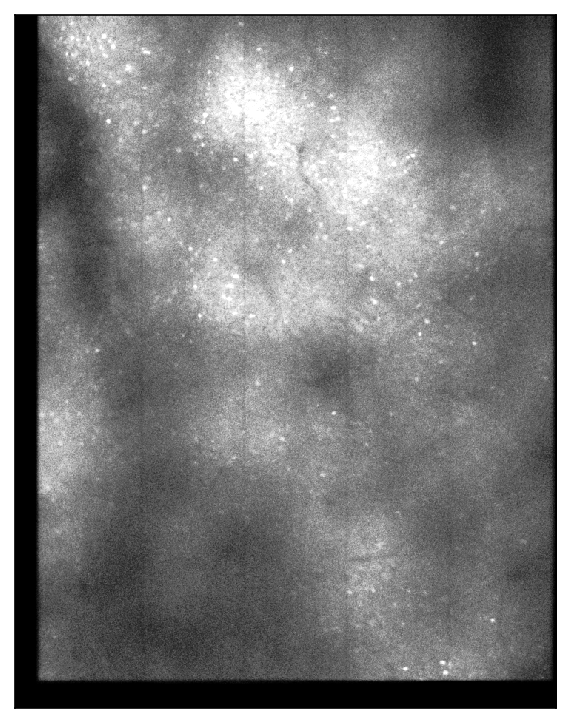

In [39]:
tfu.show_tif(imreg[0])

In [40]:
# job.params['cell_filt_type'] = 'gaussian'
# job.params['npil_filt_xy_um'] = 80
# job.params['sdnorm_exp'] = 0.8
# params_to_sweep = {
#     'cell_filt_xy_um' : (5,10),
#     'npil_filt_xy_um' : (40, 80),
#     'sdnorm_exp' : (0.8,),
# }
# job.sweep_corrmap(params_to_sweep, iter_limit=2)

In [43]:
job.params['npil_filt_type']

'unif'

In [44]:
# job.params['cell_filt_type'] = 'gaussian'

# job.params['voxel_size_um'] = (20, 3.33, 3.33)
# job.params['npil_filt_xy_um'] = 70
# job.params['cell_filt_xy_um'] = 5
# job.params['sdnorm_exp'] = 0.80

'unif'

In [41]:
%%time
job.params['voxel_size_um'] = (20, 3.0, 3.0)
job.params['npil_filt_xy_um'] = 80
job.params['cell_filt_xy_um'] = 7.5
job.params['sdnorm_exp'] = 0.80
corr_map = job.calculate_corr_map()

      Found dir /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19/corrmap
      Updating self.dirs tag corrmap
      Found dir /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19/mov_sub
      Updating self.dirs tag mov_sub
   Saved a copy of params at /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19/corrmap
   Updated main params file
   Computing correlation map of movie with 49804 frames, volume shape: 24, 937, 732
      Running batch 1 of 250
         Loading movie into shared memory
         Subtracting neuropil and applying cell filters
         Reducing filtered movie to compute correlation map
      Running batch 2 of 250
         Loading movie into shared memory
         Subtracting neuropil and applying cell filters
         Reducing filtered movie to compute correlation map
      Running batch 3 of 250
         Loading movie into shared memory
         Subtracting neuropil and a

KeyboardInterrupt: 

In [48]:
res = job.load_corr_map_results()
vmap = res['vmap']
pct50s = n.percentile(vmap, 50, axis=(1,2))
pct99p9s = n.percentile(vmap, 99.9, axis=(1,2))
vmap[0] -= (pct50s[0] - pct50s[1])

In [49]:
# job.params['peak_thresh'] = 0.50
# job.params['detection_timebin'] = 1 
# job.params['percentile'] = 95.0

# job.params['extend_thresh'] = 0.1
# job.params['activity_thresh'] = 7.0

# params_to_sweep = {
#     'percentile' : (95.0, 99.0),
#     'activity_thresh' : (7.0, 15.0),
#     'extend_thresh' : (0.05, 0.075, 0.1, 0.2, 0.3)
# }

# job.sweep_segmentation(params_to_sweep, all_combinations=True, ts = (0,2000), 
#                        patches_to_segment = (20, 50), vmap=vmap)

In [ ]:
job.params['peak_thresh'] = 4.4
# optionally, bin the movie in time to speed up detection
# probably a good idea if you have high framerate (>5 Hz?)
job.params['detection_timebin'] = 1 

# when extending an ROI, compare its activity to its neighboring pixels
# in frames where the fluorescence is above this percentile
job.params['percentile'] = 95.0

job.params['extend_thresh'] = 0.1
job.params['activity_thresh'] = 7.0
job.segment_rois(vmap=vmap)

   Created dir /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19/segmentation with tag segmentation
      Updating self.dirs tag segmentation
   Saved a copy of params at /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19/segmentation
   Updated main params file
   Created dir /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19/rois with tag rois
      Updating self.dirs tag rois
   Saving results to /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19/segmentation and /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19/rois 
dict_keys(['max_img', 'mean_img', 'vmap', 'all_params'])
   Detecting from patch 1 / 80
   Created dir /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19/segmentation/patch-0000 with tag segmentation-patch-0000
         Loading 49.70 GB movie to memory, shape: (38600, 24, 120, 1

In [ ]:
# rois_dir_path = job.combine_patches(n.arange(80), job.dirs['rois'], deduplicate=False,
#                                     parent_dir_name='segmentation', info_use_idx=None)

In [ ]:
job.compute_npil_masks(stats_dir = job.dirs['rois'])


In [ ]:

traces = job.extract_and_deconvolve(stats_dir=job.dirs['rois'])

In [ ]:
job.export_results('/mnt/zeytin-f1/s3d-results/',result_dir_name='rois')

   Created dir /mnt/zeytin-f1/s3d-results/s3d-results-SS003_2024-08-06_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19 to export results
      Loading from /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19/rois/stats_small.npy
      Loading from /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19/rois/info.npy
      Loading from /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19/rois/F.npy
      Loading from /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19/rois/spks.npy
      Loading from /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19/rois/Fneu.npy
      Loading from /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19/rois/iscell.npy
      Overwriting existing /mnt/zeytin-f1/s3d-results/s3d-results-SS003_2024-08-06_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19/s3d-params.npy
      Overwriti